# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate

# IMPORTS

In [2]:
import os
import gc
import json
import torch
import faiss
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModel, AutoModelForCausalLM
)
from sentence_transformers import SentenceTransformer
warnings.filterwarnings('ignore')

/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = './Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = './eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id", "id", "file_name", "filename", "path", "file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]


## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE)
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE)
embedding_model = load_embedding_model()
print("Models loaded.")

Models loaded.


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        batch_results.append(rerank_articles(q, c, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map[a])
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

print("Eval Article:")
article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
print("Eval Image:")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [01:17<00:00, 77.76s/it]

100%|██████████| 1/1 [01:17<00:00, 77.76s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:04<01:42,  4.89s/it]

  9%|▉         | 2/22 [00:06<01:04,  3.21s/it]

 14%|█▎        | 3/22 [00:15<01:44,  5.49s/it]

 18%|█▊        | 4/22 [00:16<01:12,  4.05s/it]

 23%|██▎       | 5/22 [00:18<00:55,  3.29s/it]

 27%|██▋       | 6/22 [00:26<01:17,  4.87s/it]

 32%|███▏      | 7/22 [00:40<01:55,  7.72s/it]

 36%|███▋      | 8/22 [00:54<02:15,  9.67s/it]

 41%|████      | 9/22 [00:55<01:30,  6.94s/it]

 45%|████▌     | 10/22 [00:55<00:59,  4.97s/it]

 50%|█████     | 11/22 [01:00<00:53,  4.86s/it]

 55%|█████▍    | 12/22 [01:04<00:45,  4.56s/it]

 59%|█████▉    | 13/22 [01:11<00:47,  5.29s/it]

 64%|██████▎   | 14/22 [01:16<00:41,  5.19s/it]

 68%|██████▊   | 15/22 [01:28<00:52,  7.44s/it]

 73%|███████▎  | 16/22 [01:30<00:35,  5.83s/it]

 77%|███████▋  | 17/22 [01:33<00:24,  4.99s/it]

 82%|████████▏ | 18/22 [01:36<00:17,  4.36s/it]

 86%|████████▋ | 19/22 [01:38<00:10,  3.66s/it]

 91%|█████████ | 20/22 [01:40<00:05,  2.91s/it]

 95%|█████████▌| 21/22 [01:44<00:03,  3.52s/it]

100%|██████████| 22/22 [01:46<00:00,  2.87s/it]

100%|██████████| 22/22 [01:46<00:00,  4.83s/it]

Eval Article:

Article Retrieval Metrics:
mAP: 0.5701
MRR: 0.5701
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.7727
Recall@50: 0.7727
Eval Image:

Image Retrieval Metrics:
mAP: 0.4068
MRR: 0.4068
Recall@1: 0.2727
Recall@5: 0.6364
Recall@10: 0.6818
Recall@20: 0.6818
Recall@50: 0.6818


# VISUALIZATION

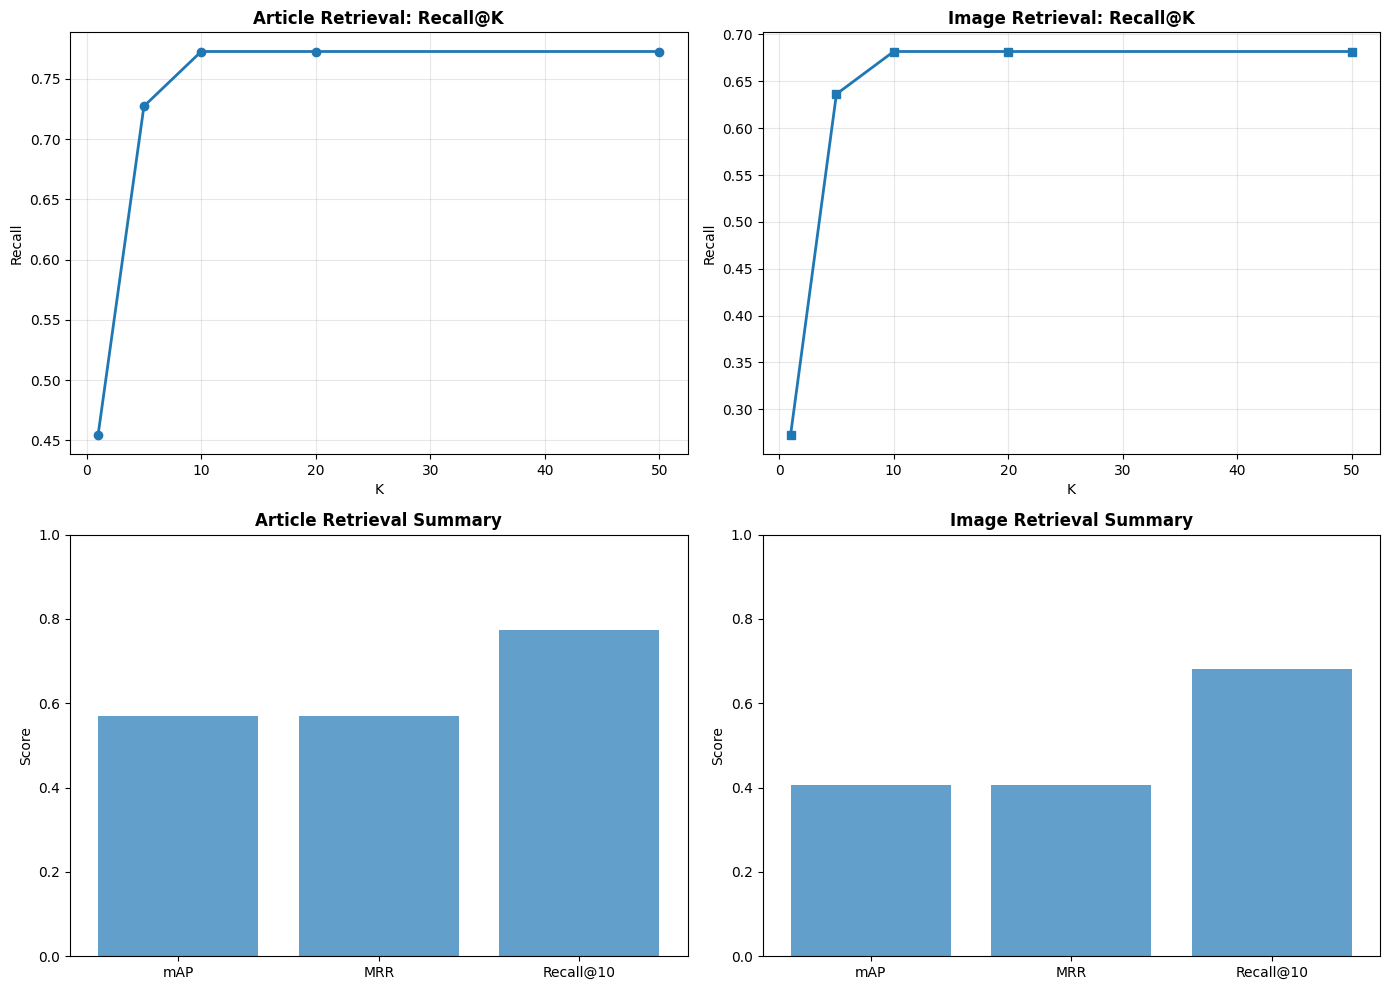

Visualization saved to qwen3_results.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("K")
axes[0, 0].set_ylabel("Recall")
axes[0, 0].grid(True, alpha=0.3)
image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("K")
axes[0, 1].set_ylabel("Recall")
axes[0, 1].grid(True, alpha=0.3)
article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].set_ylabel("Score")
image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].set_ylabel("Score")
plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150, bbox_inches='tight')
plt.show()
print("Visualization saved to qwen3_results.png")

# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        batch_results.append(rerank_articles(q, c, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map[a])
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    row = [qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs))
    rows.append(row)

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:19,  2.37it/s]

  4%|▍         | 2/47 [00:00<00:19,  2.29it/s]

  6%|▋         | 3/47 [00:01<00:19,  2.23it/s]

  9%|▊         | 4/47 [00:01<00:19,  2.15it/s]

 11%|█         | 5/47 [00:02<00:19,  2.18it/s]

 13%|█▎        | 6/47 [00:02<00:19,  2.15it/s]

 15%|█▍        | 7/47 [00:03<00:18,  2.18it/s]

 17%|█▋        | 8/47 [00:03<00:17,  2.26it/s]

 19%|█▉        | 9/47 [00:04<00:16,  2.29it/s]

 21%|██▏       | 10/47 [00:04<00:16,  2.19it/s]

 23%|██▎       | 11/47 [00:04<00:16,  2.24it/s]

 26%|██▌       | 12/47 [00:05<00:15,  2.22it/s]

 28%|██▊       | 13/47 [00:05<00:15,  2.20it/s]

 30%|██▉       | 14/47 [00:06<00:14,  2.32it/s]

 32%|███▏      | 15/47 [00:06<00:13,  2.41it/s]

 34%|███▍      | 16/47 [00:06<00:12,  2.52it/s]

 36%|███▌      | 17/47 [00:07<00:11,  2.54it/s]

 38%|███▊      | 18/47 [00:07<00:11,  2.57it/s]

 40%|████      | 19/47 [00:08<00:11,  2.53it/s]

 43%|████▎     | 20/47 [00:08<00:10,  2.54it/s]

 45%|████▍     | 21/47 [00:08<00:10,  2.45it/s]

 47%|████▋     | 22/47 [00:09<00:10,  2.45it/s]

 49%|████▉     | 23/47 [00:09<00:09,  2.42it/s]

 51%|█████     | 24/47 [00:10<00:10,  2.28it/s]

 53%|█████▎    | 25/47 [00:10<00:09,  2.37it/s]

 55%|█████▌    | 26/47 [00:11<00:08,  2.43it/s]

 57%|█████▋    | 27/47 [00:11<00:08,  2.38it/s]

 60%|█████▉    | 28/47 [00:11<00:07,  2.46it/s]

 62%|██████▏   | 29/47 [00:12<00:07,  2.48it/s]

 64%|██████▍   | 30/47 [00:12<00:06,  2.47it/s]

 66%|██████▌   | 31/47 [00:13<00:06,  2.59it/s]

 68%|██████▊   | 32/47 [00:13<00:05,  2.81it/s]

 70%|███████   | 33/47 [00:13<00:04,  2.81it/s]

 72%|███████▏  | 34/47 [00:14<00:04,  2.88it/s]

 74%|███████▍  | 35/47 [00:14<00:04,  2.99it/s]

 77%|███████▋  | 36/47 [00:14<00:03,  2.88it/s]

 79%|███████▊  | 37/47 [00:15<00:03,  2.78it/s]

 81%|████████  | 38/47 [00:15<00:03,  2.66it/s]

 83%|████████▎ | 39/47 [00:15<00:03,  2.56it/s]

 85%|████████▌ | 40/47 [00:16<00:02,  2.45it/s]

 87%|████████▋ | 41/47 [00:16<00:02,  2.35it/s]

 89%|████████▉ | 42/47 [00:17<00:02,  2.17it/s]

 91%|█████████▏| 43/47 [00:17<00:01,  2.14it/s]

 94%|█████████▎| 44/47 [00:18<00:01,  1.95it/s]

 96%|█████████▌| 45/47 [00:19<00:01,  1.92it/s]

 98%|█████████▊| 46/47 [00:19<00:00,  2.05it/s]

100%|██████████| 47/47 [00:19<00:00,  2.13it/s]

100%|██████████| 47/47 [00:19<00:00,  2.37it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [02:54<2:13:55, 174.69s/it]

  4%|▍         | 2/47 [05:53<2:12:55, 177.23s/it]

  6%|▋         | 3/47 [08:50<2:09:51, 177.09s/it]

  9%|▊         | 4/47 [11:54<2:08:54, 179.87s/it]

 11%|█         | 5/47 [14:54<2:05:57, 179.95s/it]

 13%|█▎        | 6/47 [17:49<2:01:47, 178.23s/it]

 15%|█▍        | 7/47 [20:48<1:58:54, 178.36s/it]

 17%|█▋        | 8/47 [23:49<1:56:33, 179.32s/it]

 19%|█▉        | 9/47 [26:52<1:54:12, 180.32s/it]

 21%|██▏       | 10/47 [29:59<1:52:31, 182.46s/it]

 23%|██▎       | 11/47 [33:08<1:50:43, 184.53s/it]

 26%|██▌       | 12/47 [36:17<1:48:26, 185.89s/it]

 28%|██▊       | 13/47 [39:29<1:46:17, 187.57s/it]

 30%|██▉       | 14/47 [42:34<1:42:46, 186.86s/it]

 32%|███▏      | 15/47 [45:40<1:39:35, 186.74s/it]

 34%|███▍      | 16/47 [48:37<1:34:50, 183.58s/it]

 36%|███▌      | 17/47 [51:36<1:31:05, 182.19s/it]

 38%|███▊      | 18/47 [54:34<1:27:30, 181.05s/it]

 40%|████      | 19/47 [57:35<1:24:27, 180.97s/it]

 43%|████▎     | 20/47 [1:00:37<1:21:34, 181.29s/it]

 45%|████▍     | 21/47 [1:03:39<1:18:37, 181.44s/it]

 47%|████▋     | 22/47 [1:06:41<1:15:40, 181.63s/it]

 49%|████▉     | 23/47 [1:09:43<1:12:42, 181.75s/it]

 51%|█████     | 24/47 [1:12:48<1:10:06, 182.88s/it]

 53%|█████▎    | 25/47 [1:15:45<1:06:21, 180.97s/it]

 55%|█████▌    | 26/47 [1:18:46<1:03:24, 181.18s/it]

 57%|█████▋    | 27/47 [1:21:46<1:00:13, 180.69s/it]

 60%|█████▉    | 28/47 [1:24:47<57:14, 180.76s/it]  

 62%|██████▏   | 29/47 [1:27:43<53:51, 179.51s/it]

 64%|██████▍   | 30/47 [1:30:41<50:40, 178.86s/it]

 66%|██████▌   | 31/47 [1:33:39<47:36, 178.53s/it]

 68%|██████▊   | 32/47 [1:36:34<44:24, 177.61s/it]

 70%|███████   | 33/47 [1:39:31<41:25, 177.56s/it]

 72%|███████▏  | 34/47 [1:42:28<38:25, 177.35s/it]

 74%|███████▍  | 35/47 [1:45:36<36:03, 180.32s/it]

 77%|███████▋  | 36/47 [1:48:34<32:56, 179.66s/it]

 79%|███████▊  | 37/47 [1:51:32<29:51, 179.17s/it]

 81%|████████  | 38/47 [1:54:30<26:50, 178.90s/it]

 83%|████████▎ | 39/47 [1:57:33<24:01, 180.17s/it]

 85%|████████▌ | 40/47 [2:00:47<21:30, 184.35s/it]

 87%|████████▋ | 41/47 [2:03:43<18:10, 181.67s/it]

 89%|████████▉ | 42/47 [2:06:51<15:19, 183.83s/it]

 91%|█████████▏| 43/47 [2:09:57<12:17, 184.35s/it]

 94%|█████████▎| 44/47 [2:13:06<09:17, 185.86s/it]

 96%|█████████▌| 45/47 [2:16:14<06:12, 186.33s/it]

 98%|█████████▊| 46/47 [2:19:16<03:05, 185.16s/it]

100%|██████████| 47/47 [2:21:54<00:00, 176.78s/it]

100%|██████████| 47/47 [2:21:54<00:00, 181.15s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:23<19:15:58, 23.13s/it]

  0%|          | 2/3000 [00:43<18:04:21, 21.70s/it]

  0%|          | 3/3000 [00:46<10:46:22, 12.94s/it]

  0%|          | 4/3000 [00:49<7:40:29,  9.22s/it] 

  0%|          | 5/3000 [00:54<6:23:45,  7.69s/it]

  0%|          | 6/3000 [01:00<5:44:47,  6.91s/it]

  0%|          | 7/3000 [01:09<6:25:41,  7.73s/it]

  0%|          | 8/3000 [01:16<6:19:10,  7.60s/it]

  0%|          | 9/3000 [01:22<5:47:40,  6.97s/it]

  0%|          | 10/3000 [01:29<5:46:43,  6.96s/it]

  0%|          | 11/3000 [01:30<4:20:40,  5.23s/it]

  0%|          | 12/3000 [01:31<3:17:27,  3.97s/it]

  0%|          | 13/3000 [01:41<4:36:57,  5.56s/it]

  0%|          | 14/3000 [01:47<4:50:36,  5.84s/it]

  0%|          | 15/3000 [01:52<4:36:08,  5.55s/it]

  1%|          | 16/3000 [02:07<7:03:14,  8.51s/it]

  1%|          | 17/3000 [02:13<6:24:01,  7.72s/it]

  1%|          | 18/3000 [02:18<5:34:16,  6.73s/it]

  1%|          | 19/3000 [02:23<5:19:01,  6.42s/it]

  1%|          | 20/3000 [02:34<6:26:36,  7.78s/it]

  1%|          | 21/3000 [02:43<6:39:10,  8.04s/it]

  1%|          | 22/3000 [02:56<7:49:59,  9.47s/it]

  1%|          | 23/3000 [03:09<8:45:49, 10.60s/it]

  1%|          | 24/3000 [03:15<7:40:01,  9.27s/it]

  1%|          | 25/3000 [03:22<7:08:35,  8.64s/it]

  1%|          | 26/3000 [03:31<7:05:17,  8.58s/it]

  1%|          | 27/3000 [03:44<8:06:41,  9.82s/it]

  1%|          | 28/3000 [03:47<6:27:06,  7.81s/it]

  1%|          | 29/3000 [03:48<4:49:44,  5.85s/it]

  1%|          | 30/3000 [03:54<4:59:57,  6.06s/it]

  1%|          | 31/3000 [04:02<5:24:28,  6.56s/it]

  1%|          | 32/3000 [04:13<6:21:49,  7.72s/it]

  1%|          | 33/3000 [04:30<8:49:06, 10.70s/it]

  1%|          | 34/3000 [04:43<9:16:06, 11.25s/it]

  1%|          | 35/3000 [04:57<9:57:57, 12.10s/it]

  1%|          | 36/3000 [05:02<8:15:43, 10.03s/it]

  1%|          | 37/3000 [05:06<6:46:11,  8.23s/it]

  1%|▏         | 38/3000 [05:12<6:05:50,  7.41s/it]

  1%|▏         | 39/3000 [05:21<6:32:02,  7.94s/it]

  1%|▏         | 40/3000 [05:24<5:16:03,  6.41s/it]

  1%|▏         | 41/3000 [05:27<4:32:05,  5.52s/it]

  1%|▏         | 42/3000 [05:29<3:39:17,  4.45s/it]

  1%|▏         | 43/3000 [05:36<4:16:46,  5.21s/it]

  1%|▏         | 44/3000 [05:43<4:40:32,  5.69s/it]

  2%|▏         | 45/3000 [05:49<4:43:08,  5.75s/it]

  2%|▏         | 46/3000 [05:55<4:47:42,  5.84s/it]

  2%|▏         | 47/3000 [05:58<4:07:33,  5.03s/it]

  2%|▏         | 48/3000 [06:07<5:10:55,  6.32s/it]

  2%|▏         | 49/3000 [06:10<4:11:19,  5.11s/it]

  2%|▏         | 50/3000 [06:13<3:46:11,  4.60s/it]

  2%|▏         | 51/3000 [06:29<6:34:14,  8.02s/it]

  2%|▏         | 52/3000 [06:34<5:53:51,  7.20s/it]

  2%|▏         | 53/3000 [06:54<8:54:21, 10.88s/it]

  2%|▏         | 54/3000 [07:04<8:39:49, 10.59s/it]

  2%|▏         | 55/3000 [07:23<10:50:58, 13.26s/it]

  2%|▏         | 56/3000 [07:31<9:36:23, 11.75s/it] 

  2%|▏         | 57/3000 [07:37<8:01:32,  9.82s/it]

  2%|▏         | 58/3000 [07:46<7:59:24,  9.78s/it]

  2%|▏         | 59/3000 [07:48<6:01:49,  7.38s/it]

  2%|▏         | 60/3000 [07:51<4:54:02,  6.00s/it]

  2%|▏         | 61/3000 [07:53<3:55:27,  4.81s/it]

  2%|▏         | 62/3000 [08:08<6:22:36,  7.81s/it]

  2%|▏         | 63/3000 [08:12<5:37:42,  6.90s/it]

  2%|▏         | 64/3000 [08:21<6:05:10,  7.46s/it]

  2%|▏         | 65/3000 [08:25<5:04:52,  6.23s/it]

  2%|▏         | 66/3000 [08:34<5:56:47,  7.30s/it]

  2%|▏         | 67/3000 [08:42<5:58:13,  7.33s/it]

  2%|▏         | 68/3000 [08:50<6:07:50,  7.53s/it]

  2%|▏         | 69/3000 [08:59<6:34:34,  8.08s/it]

  2%|▏         | 70/3000 [09:02<5:18:43,  6.53s/it]

  2%|▏         | 71/3000 [09:15<6:51:06,  8.42s/it]

  2%|▏         | 72/3000 [09:20<5:59:21,  7.36s/it]

  2%|▏         | 73/3000 [09:27<5:56:16,  7.30s/it]

  2%|▏         | 74/3000 [09:37<6:40:59,  8.22s/it]

  2%|▎         | 75/3000 [09:59<9:56:35, 12.24s/it]

  3%|▎         | 76/3000 [10:08<9:07:51, 11.24s/it]

  3%|▎         | 77/3000 [10:14<7:51:37,  9.68s/it]

  3%|▎         | 78/3000 [10:20<7:00:35,  8.64s/it]

  3%|▎         | 79/3000 [10:31<7:36:05,  9.37s/it]

  3%|▎         | 80/3000 [10:42<8:01:53,  9.90s/it]

  3%|▎         | 81/3000 [10:49<7:21:14,  9.07s/it]

  3%|▎         | 82/3000 [10:53<5:58:30,  7.37s/it]

  3%|▎         | 83/3000 [10:59<5:33:29,  6.86s/it]

  3%|▎         | 84/3000 [11:04<5:17:57,  6.54s/it]

  3%|▎         | 85/3000 [11:08<4:38:52,  5.74s/it]

  3%|▎         | 86/3000 [11:17<5:20:36,  6.60s/it]

  3%|▎         | 87/3000 [11:21<4:52:17,  6.02s/it]

  3%|▎         | 88/3000 [11:38<7:18:05,  9.03s/it]

  3%|▎         | 89/3000 [11:46<7:13:26,  8.93s/it]

  3%|▎         | 90/3000 [11:57<7:44:39,  9.58s/it]

  3%|▎         | 91/3000 [12:08<8:07:09, 10.05s/it]

  3%|▎         | 92/3000 [12:12<6:27:09,  7.99s/it]

  3%|▎         | 93/3000 [12:19<6:22:15,  7.89s/it]

  3%|▎         | 94/3000 [12:21<4:51:00,  6.01s/it]

  3%|▎         | 95/3000 [12:25<4:22:26,  5.42s/it]

  3%|▎         | 96/3000 [12:29<3:56:35,  4.89s/it]

  3%|▎         | 97/3000 [12:30<3:11:34,  3.96s/it]

  3%|▎         | 98/3000 [12:33<2:48:20,  3.48s/it]

  3%|▎         | 99/3000 [12:34<2:18:45,  2.87s/it]

  3%|▎         | 100/3000 [12:36<1:57:02,  2.42s/it]

  3%|▎         | 101/3000 [12:46<3:48:39,  4.73s/it]

  3%|▎         | 102/3000 [12:51<4:00:47,  4.99s/it]

  3%|▎         | 103/3000 [12:56<3:56:16,  4.89s/it]

  3%|▎         | 104/3000 [13:09<5:55:37,  7.37s/it]

  4%|▎         | 105/3000 [13:10<4:26:51,  5.53s/it]

  4%|▎         | 106/3000 [13:20<5:20:40,  6.65s/it]

  4%|▎         | 107/3000 [13:22<4:12:40,  5.24s/it]

  4%|▎         | 108/3000 [13:36<6:25:36,  8.00s/it]

  4%|▎         | 109/3000 [13:42<6:01:33,  7.50s/it]

  4%|▎         | 110/3000 [14:01<8:43:08, 10.86s/it]

  4%|▎         | 111/3000 [14:06<7:24:02,  9.22s/it]

  4%|▎         | 112/3000 [14:08<5:33:31,  6.93s/it]

  4%|▍         | 113/3000 [14:10<4:27:13,  5.55s/it]

  4%|▍         | 114/3000 [14:29<7:37:08,  9.50s/it]

  4%|▍         | 115/3000 [14:35<6:52:15,  8.57s/it]

  4%|▍         | 116/3000 [14:46<7:21:47,  9.19s/it]

  4%|▍         | 117/3000 [14:52<6:31:12,  8.14s/it]

  4%|▍         | 118/3000 [14:54<5:04:52,  6.35s/it]

  4%|▍         | 119/3000 [14:57<4:18:56,  5.39s/it]

  4%|▍         | 120/3000 [15:03<4:26:14,  5.55s/it]

  4%|▍         | 121/3000 [15:18<6:36:46,  8.27s/it]

  4%|▍         | 122/3000 [15:26<6:40:17,  8.35s/it]

  4%|▍         | 123/3000 [15:37<7:12:13,  9.01s/it]

  4%|▍         | 124/3000 [15:42<6:17:02,  7.87s/it]

  4%|▍         | 125/3000 [15:44<4:53:40,  6.13s/it]

  4%|▍         | 126/3000 [15:49<4:37:22,  5.79s/it]

  4%|▍         | 127/3000 [16:02<6:17:14,  7.88s/it]

  4%|▍         | 128/3000 [16:14<7:13:11,  9.05s/it]

  4%|▍         | 129/3000 [16:29<8:51:21, 11.10s/it]

  4%|▍         | 130/3000 [16:42<9:14:10, 11.59s/it]

  4%|▍         | 131/3000 [16:54<9:16:55, 11.65s/it]

  4%|▍         | 132/3000 [17:19<12:28:37, 15.66s/it]

  4%|▍         | 133/3000 [17:23<9:36:26, 12.06s/it] 

  4%|▍         | 134/3000 [17:42<11:24:26, 14.33s/it]

  4%|▍         | 135/3000 [17:49<9:33:16, 12.01s/it] 

  5%|▍         | 136/3000 [18:06<10:41:32, 13.44s/it]

  5%|▍         | 137/3000 [18:12<8:52:54, 11.17s/it] 

  5%|▍         | 138/3000 [18:25<9:23:53, 11.82s/it]

  5%|▍         | 139/3000 [18:27<7:11:49,  9.06s/it]

  5%|▍         | 140/3000 [18:29<5:26:42,  6.85s/it]

  5%|▍         | 141/3000 [18:31<4:13:29,  5.32s/it]

  5%|▍         | 142/3000 [18:37<4:26:27,  5.59s/it]

  5%|▍         | 143/3000 [18:44<4:42:27,  5.93s/it]

  5%|▍         | 144/3000 [18:54<5:39:59,  7.14s/it]

  5%|▍         | 145/3000 [18:56<4:34:17,  5.76s/it]

  5%|▍         | 146/3000 [19:00<4:02:18,  5.09s/it]

  5%|▍         | 147/3000 [19:05<4:05:39,  5.17s/it]

  5%|▍         | 148/3000 [19:09<3:40:51,  4.65s/it]

  5%|▍         | 149/3000 [19:19<5:02:03,  6.36s/it]

  5%|▌         | 150/3000 [19:20<3:49:12,  4.83s/it]

  5%|▌         | 151/3000 [19:24<3:33:22,  4.49s/it]

  5%|▌         | 152/3000 [19:45<7:29:25,  9.47s/it]

  5%|▌         | 153/3000 [19:52<6:57:25,  8.80s/it]

  5%|▌         | 154/3000 [20:19<11:09:04, 14.11s/it]

  5%|▌         | 155/3000 [20:26<9:24:04, 11.90s/it] 

  5%|▌         | 156/3000 [20:38<9:32:20, 12.07s/it]

  5%|▌         | 157/3000 [20:41<7:26:07,  9.42s/it]

  5%|▌         | 158/3000 [20:57<8:58:48, 11.38s/it]

  5%|▌         | 159/3000 [20:58<6:29:44,  8.23s/it]

  5%|▌         | 160/3000 [21:00<5:05:22,  6.45s/it]

  5%|▌         | 161/3000 [21:12<6:19:09,  8.01s/it]

  5%|▌         | 162/3000 [21:26<7:46:45,  9.87s/it]

  5%|▌         | 163/3000 [21:29<6:10:08,  7.83s/it]

  5%|▌         | 164/3000 [21:46<8:18:25, 10.54s/it]

  6%|▌         | 165/3000 [21:52<7:11:42,  9.14s/it]

  6%|▌         | 166/3000 [21:53<5:22:24,  6.83s/it]

  6%|▌         | 167/3000 [21:56<4:23:21,  5.58s/it]

  6%|▌         | 168/3000 [22:09<6:09:07,  7.82s/it]

  6%|▌         | 169/3000 [22:14<5:22:58,  6.85s/it]

  6%|▌         | 170/3000 [22:15<4:10:19,  5.31s/it]

  6%|▌         | 171/3000 [22:20<3:54:27,  4.97s/it]

  6%|▌         | 172/3000 [22:21<3:01:05,  3.84s/it]

  6%|▌         | 173/3000 [22:28<3:46:07,  4.80s/it]

  6%|▌         | 174/3000 [22:35<4:19:11,  5.50s/it]

  6%|▌         | 175/3000 [22:40<4:13:04,  5.38s/it]

  6%|▌         | 176/3000 [22:44<3:51:32,  4.92s/it]

  6%|▌         | 177/3000 [22:48<3:34:20,  4.56s/it]

  6%|▌         | 178/3000 [22:54<4:04:35,  5.20s/it]

  6%|▌         | 179/3000 [22:59<3:49:24,  4.88s/it]

  6%|▌         | 180/3000 [23:06<4:24:50,  5.63s/it]

  6%|▌         | 181/3000 [23:10<4:01:12,  5.13s/it]

  6%|▌         | 182/3000 [23:16<4:09:56,  5.32s/it]

  6%|▌         | 183/3000 [23:21<4:14:17,  5.42s/it]

  6%|▌         | 184/3000 [23:30<5:01:11,  6.42s/it]

  6%|▌         | 185/3000 [23:33<4:05:52,  5.24s/it]

  6%|▌         | 186/3000 [23:41<4:57:20,  6.34s/it]

  6%|▌         | 187/3000 [23:44<4:08:53,  5.31s/it]

  6%|▋         | 188/3000 [23:53<4:49:05,  6.17s/it]

  6%|▋         | 189/3000 [23:59<4:49:34,  6.18s/it]

  6%|▋         | 190/3000 [24:03<4:27:42,  5.72s/it]

  6%|▋         | 191/3000 [24:07<3:58:00,  5.08s/it]

  6%|▋         | 192/3000 [24:12<4:01:13,  5.15s/it]

  6%|▋         | 193/3000 [24:23<5:21:09,  6.86s/it]

  6%|▋         | 194/3000 [24:28<4:53:00,  6.27s/it]

  6%|▋         | 195/3000 [24:39<5:57:04,  7.64s/it]

  7%|▋         | 196/3000 [24:45<5:32:07,  7.11s/it]

  7%|▋         | 197/3000 [24:53<5:42:44,  7.34s/it]

  7%|▋         | 198/3000 [24:56<4:53:07,  6.28s/it]

  7%|▋         | 199/3000 [25:05<5:20:57,  6.88s/it]

  7%|▋         | 200/3000 [25:10<4:59:23,  6.42s/it]

  7%|▋         | 201/3000 [25:15<4:36:52,  5.94s/it]

  7%|▋         | 202/3000 [25:21<4:33:21,  5.86s/it]

  7%|▋         | 203/3000 [25:26<4:26:50,  5.72s/it]

  7%|▋         | 204/3000 [25:31<4:11:13,  5.39s/it]

  7%|▋         | 205/3000 [25:35<4:04:21,  5.25s/it]

  7%|▋         | 206/3000 [25:45<5:01:51,  6.48s/it]

  7%|▋         | 207/3000 [25:56<6:12:16,  8.00s/it]

  7%|▋         | 208/3000 [26:03<5:50:25,  7.53s/it]

  7%|▋         | 209/3000 [26:22<8:37:44, 11.13s/it]

  7%|▋         | 210/3000 [26:38<9:35:19, 12.37s/it]

  7%|▋         | 211/3000 [26:54<10:33:37, 13.63s/it]

  7%|▋         | 212/3000 [26:57<7:58:54, 10.31s/it] 

  7%|▋         | 213/3000 [27:02<6:42:45,  8.67s/it]

  7%|▋         | 214/3000 [27:11<6:54:55,  8.94s/it]

  7%|▋         | 215/3000 [27:19<6:36:58,  8.55s/it]

  7%|▋         | 216/3000 [27:24<5:53:04,  7.61s/it]

  7%|▋         | 217/3000 [27:29<5:15:40,  6.81s/it]

  7%|▋         | 218/3000 [27:36<5:13:58,  6.77s/it]

  7%|▋         | 219/3000 [27:42<5:12:07,  6.73s/it]

  7%|▋         | 220/3000 [27:52<5:44:12,  7.43s/it]

  7%|▋         | 221/3000 [28:06<7:17:07,  9.44s/it]

  7%|▋         | 222/3000 [28:15<7:11:29,  9.32s/it]

  7%|▋         | 223/3000 [28:20<6:19:56,  8.21s/it]

  7%|▋         | 224/3000 [28:27<6:02:52,  7.84s/it]

  8%|▊         | 225/3000 [28:31<5:00:34,  6.50s/it]

  8%|▊         | 226/3000 [28:43<6:25:02,  8.33s/it]

  8%|▊         | 227/3000 [28:56<7:31:15,  9.76s/it]

  8%|▊         | 228/3000 [29:05<7:14:14,  9.40s/it]

  8%|▊         | 229/3000 [29:10<6:15:54,  8.14s/it]

  8%|▊         | 230/3000 [29:18<6:13:16,  8.09s/it]

  8%|▊         | 231/3000 [29:20<4:43:27,  6.14s/it]

  8%|▊         | 232/3000 [29:27<5:00:48,  6.52s/it]

  8%|▊         | 233/3000 [29:30<4:16:04,  5.55s/it]

  8%|▊         | 234/3000 [29:38<4:41:37,  6.11s/it]

  8%|▊         | 235/3000 [29:45<4:56:46,  6.44s/it]

  8%|▊         | 236/3000 [29:49<4:19:28,  5.63s/it]

  8%|▊         | 237/3000 [29:54<4:13:09,  5.50s/it]

  8%|▊         | 238/3000 [30:10<6:43:49,  8.77s/it]

  8%|▊         | 239/3000 [30:16<6:03:58,  7.91s/it]

  8%|▊         | 240/3000 [30:23<5:41:43,  7.43s/it]

  8%|▊         | 241/3000 [30:34<6:32:36,  8.54s/it]

  8%|▊         | 242/3000 [30:40<6:06:17,  7.97s/it]

  8%|▊         | 243/3000 [30:44<5:12:51,  6.81s/it]

  8%|▊         | 244/3000 [30:56<6:21:19,  8.30s/it]

  8%|▊         | 245/3000 [31:00<5:16:14,  6.89s/it]

  8%|▊         | 246/3000 [31:08<5:36:58,  7.34s/it]

  8%|▊         | 247/3000 [31:14<5:13:09,  6.83s/it]

  8%|▊         | 248/3000 [31:20<4:58:32,  6.51s/it]

  8%|▊         | 249/3000 [31:27<5:16:37,  6.91s/it]

  8%|▊         | 250/3000 [31:31<4:25:30,  5.79s/it]

  8%|▊         | 251/3000 [31:40<5:12:36,  6.82s/it]

  8%|▊         | 252/3000 [31:41<3:56:56,  5.17s/it]

  8%|▊         | 253/3000 [31:46<3:47:06,  4.96s/it]

  8%|▊         | 254/3000 [31:52<4:11:56,  5.51s/it]

  8%|▊         | 255/3000 [31:58<4:06:34,  5.39s/it]

  9%|▊         | 256/3000 [32:01<3:39:59,  4.81s/it]

  9%|▊         | 257/3000 [32:02<2:46:36,  3.64s/it]

  9%|▊         | 258/3000 [32:12<4:08:38,  5.44s/it]

  9%|▊         | 259/3000 [32:16<4:00:26,  5.26s/it]

  9%|▊         | 260/3000 [32:20<3:36:40,  4.74s/it]

  9%|▊         | 261/3000 [32:25<3:35:15,  4.72s/it]

  9%|▊         | 262/3000 [32:29<3:25:35,  4.51s/it]

  9%|▉         | 263/3000 [32:32<3:16:27,  4.31s/it]

  9%|▉         | 264/3000 [32:38<3:33:36,  4.68s/it]

  9%|▉         | 265/3000 [32:45<4:01:50,  5.31s/it]

  9%|▉         | 266/3000 [32:56<5:17:35,  6.97s/it]

  9%|▉         | 267/3000 [33:00<4:36:16,  6.07s/it]

  9%|▉         | 268/3000 [33:15<6:38:58,  8.76s/it]

  9%|▉         | 269/3000 [33:19<5:44:29,  7.57s/it]

  9%|▉         | 270/3000 [33:26<5:24:49,  7.14s/it]

  9%|▉         | 271/3000 [33:30<4:52:10,  6.42s/it]

  9%|▉         | 272/3000 [33:50<7:59:22, 10.54s/it]

  9%|▉         | 273/3000 [33:58<7:18:18,  9.64s/it]

  9%|▉         | 274/3000 [34:05<6:43:16,  8.88s/it]

  9%|▉         | 275/3000 [34:09<5:37:43,  7.44s/it]

  9%|▉         | 276/3000 [34:12<4:39:57,  6.17s/it]

  9%|▉         | 277/3000 [34:17<4:19:39,  5.72s/it]

  9%|▉         | 278/3000 [34:23<4:16:58,  5.66s/it]

  9%|▉         | 279/3000 [34:32<5:10:23,  6.84s/it]

  9%|▉         | 280/3000 [34:38<4:52:16,  6.45s/it]

  9%|▉         | 281/3000 [34:52<6:37:12,  8.77s/it]

  9%|▉         | 282/3000 [34:55<5:27:22,  7.23s/it]

  9%|▉         | 283/3000 [35:00<4:55:16,  6.52s/it]

  9%|▉         | 284/3000 [35:07<4:50:26,  6.42s/it]

 10%|▉         | 285/3000 [35:10<4:08:49,  5.50s/it]

 10%|▉         | 286/3000 [35:14<3:53:05,  5.15s/it]

 10%|▉         | 287/3000 [35:20<3:57:25,  5.25s/it]

 10%|▉         | 288/3000 [35:24<3:49:49,  5.08s/it]

 10%|▉         | 289/3000 [35:30<3:57:55,  5.27s/it]

 10%|▉         | 290/3000 [35:36<4:11:21,  5.57s/it]

 10%|▉         | 291/3000 [35:48<5:32:14,  7.36s/it]

 10%|▉         | 292/3000 [36:08<8:29:48, 11.30s/it]

 10%|▉         | 293/3000 [36:16<7:38:51, 10.17s/it]

 10%|▉         | 294/3000 [36:23<6:54:43,  9.20s/it]

 10%|▉         | 295/3000 [36:31<6:40:25,  8.88s/it]

 10%|▉         | 296/3000 [36:42<7:06:05,  9.45s/it]

 10%|▉         | 297/3000 [36:55<8:02:40, 10.71s/it]

 10%|▉         | 298/3000 [37:07<8:11:47, 10.92s/it]

 10%|▉         | 299/3000 [37:17<7:57:48, 10.61s/it]

 10%|█         | 300/3000 [37:28<8:11:26, 10.92s/it]

 10%|█         | 301/3000 [37:35<7:11:21,  9.59s/it]

 10%|█         | 302/3000 [37:40<6:14:21,  8.33s/it]

 10%|█         | 303/3000 [37:44<5:08:06,  6.85s/it]

 10%|█         | 304/3000 [37:50<4:55:00,  6.57s/it]

 10%|█         | 305/3000 [37:53<4:15:30,  5.69s/it]

 10%|█         | 306/3000 [38:01<4:39:01,  6.21s/it]

 10%|█         | 307/3000 [38:05<4:14:29,  5.67s/it]

 10%|█         | 308/3000 [38:16<5:26:28,  7.28s/it]

 10%|█         | 309/3000 [38:21<4:57:35,  6.64s/it]

 10%|█         | 310/3000 [38:25<4:25:43,  5.93s/it]

 10%|█         | 311/3000 [38:47<7:51:53, 10.53s/it]

 10%|█         | 312/3000 [39:02<8:49:23, 11.82s/it]

 10%|█         | 313/3000 [39:19<10:03:35, 13.48s/it]

 10%|█         | 314/3000 [39:40<11:48:37, 15.83s/it]

 10%|█         | 315/3000 [39:58<12:08:39, 16.28s/it]

 11%|█         | 316/3000 [40:17<12:45:14, 17.11s/it]

 11%|█         | 317/3000 [40:23<10:21:48, 13.91s/it]

 11%|█         | 318/3000 [40:26<7:51:06, 10.54s/it] 

 11%|█         | 319/3000 [40:37<7:54:21, 10.62s/it]

 11%|█         | 320/3000 [40:39<6:02:24,  8.11s/it]

 11%|█         | 321/3000 [40:47<5:57:27,  8.01s/it]

 11%|█         | 322/3000 [40:54<5:49:33,  7.83s/it]

 11%|█         | 323/3000 [40:59<5:17:40,  7.12s/it]

 11%|█         | 324/3000 [41:11<6:18:47,  8.49s/it]

 11%|█         | 325/3000 [41:15<5:12:52,  7.02s/it]

 11%|█         | 326/3000 [41:17<4:09:49,  5.61s/it]

 11%|█         | 327/3000 [41:23<4:19:13,  5.82s/it]

 11%|█         | 328/3000 [41:30<4:33:45,  6.15s/it]

 11%|█         | 329/3000 [41:39<5:12:59,  7.03s/it]

 11%|█         | 330/3000 [41:43<4:29:04,  6.05s/it]

 11%|█         | 331/3000 [41:47<4:02:15,  5.45s/it]

 11%|█         | 332/3000 [41:51<3:42:45,  5.01s/it]

 11%|█         | 333/3000 [41:56<3:43:24,  5.03s/it]

 11%|█         | 334/3000 [41:59<3:13:50,  4.36s/it]

 11%|█         | 335/3000 [42:08<4:20:52,  5.87s/it]

 11%|█         | 336/3000 [42:14<4:13:26,  5.71s/it]

 11%|█         | 337/3000 [42:19<4:11:53,  5.68s/it]

 11%|█▏        | 338/3000 [42:24<3:54:48,  5.29s/it]

 11%|█▏        | 339/3000 [42:27<3:26:39,  4.66s/it]

 11%|█▏        | 340/3000 [42:34<4:01:36,  5.45s/it]

 11%|█▏        | 341/3000 [42:43<4:47:29,  6.49s/it]

 11%|█▏        | 342/3000 [42:54<5:42:33,  7.73s/it]

 11%|█▏        | 343/3000 [43:02<5:49:01,  7.88s/it]

 11%|█▏        | 344/3000 [43:06<4:57:41,  6.72s/it]

 12%|█▏        | 345/3000 [43:10<4:20:48,  5.89s/it]

 12%|█▏        | 346/3000 [43:17<4:31:52,  6.15s/it]

 12%|█▏        | 347/3000 [43:20<3:57:36,  5.37s/it]

 12%|█▏        | 348/3000 [43:27<4:13:24,  5.73s/it]

 12%|█▏        | 349/3000 [43:36<4:59:04,  6.77s/it]

 12%|█▏        | 350/3000 [43:38<3:59:16,  5.42s/it]

 12%|█▏        | 351/3000 [43:49<5:14:50,  7.13s/it]

 12%|█▏        | 352/3000 [43:54<4:39:46,  6.34s/it]

 12%|█▏        | 353/3000 [44:05<5:36:53,  7.64s/it]

 12%|█▏        | 354/3000 [44:07<4:23:11,  5.97s/it]

 12%|█▏        | 355/3000 [44:16<5:11:12,  7.06s/it]

 12%|█▏        | 356/3000 [44:22<4:52:32,  6.64s/it]

 12%|█▏        | 357/3000 [44:29<4:59:56,  6.81s/it]

 12%|█▏        | 358/3000 [44:33<4:15:16,  5.80s/it]

 12%|█▏        | 359/3000 [44:38<4:12:14,  5.73s/it]

 12%|█▏        | 360/3000 [44:47<4:49:47,  6.59s/it]

 12%|█▏        | 361/3000 [44:52<4:38:53,  6.34s/it]

 12%|█▏        | 362/3000 [45:03<5:39:49,  7.73s/it]

 12%|█▏        | 363/3000 [45:05<4:24:39,  6.02s/it]

 12%|█▏        | 364/3000 [45:08<3:36:44,  4.93s/it]

 12%|█▏        | 365/3000 [45:10<3:01:58,  4.14s/it]

 12%|█▏        | 366/3000 [45:15<3:06:25,  4.25s/it]

 12%|█▏        | 367/3000 [45:16<2:34:06,  3.51s/it]

 12%|█▏        | 368/3000 [45:24<3:33:12,  4.86s/it]

 12%|█▏        | 369/3000 [45:29<3:23:44,  4.65s/it]

 12%|█▏        | 370/3000 [45:34<3:30:05,  4.79s/it]

 12%|█▏        | 371/3000 [45:39<3:30:00,  4.79s/it]

 12%|█▏        | 372/3000 [45:42<3:09:48,  4.33s/it]

 12%|█▏        | 373/3000 [45:46<3:11:09,  4.37s/it]

 12%|█▏        | 374/3000 [45:51<3:10:55,  4.36s/it]

 12%|█▎        | 375/3000 [45:55<3:12:38,  4.40s/it]

 13%|█▎        | 376/3000 [45:58<2:48:19,  3.85s/it]

 13%|█▎        | 377/3000 [46:03<3:04:57,  4.23s/it]

 13%|█▎        | 378/3000 [46:08<3:12:20,  4.40s/it]

 13%|█▎        | 379/3000 [46:12<3:09:34,  4.34s/it]

 13%|█▎        | 380/3000 [46:17<3:17:33,  4.52s/it]

 13%|█▎        | 381/3000 [46:26<4:16:54,  5.89s/it]

 13%|█▎        | 382/3000 [46:34<4:40:49,  6.44s/it]

 13%|█▎        | 383/3000 [46:37<4:06:55,  5.66s/it]

 13%|█▎        | 384/3000 [46:43<4:01:01,  5.53s/it]

 13%|█▎        | 385/3000 [46:49<4:12:07,  5.78s/it]

 13%|█▎        | 386/3000 [46:57<4:37:53,  6.38s/it]

 13%|█▎        | 387/3000 [47:04<4:49:13,  6.64s/it]

 13%|█▎        | 388/3000 [47:13<5:15:58,  7.26s/it]

 13%|█▎        | 389/3000 [47:18<4:51:32,  6.70s/it]

 13%|█▎        | 390/3000 [47:21<4:07:27,  5.69s/it]

 13%|█▎        | 391/3000 [47:25<3:39:03,  5.04s/it]

 13%|█▎        | 392/3000 [47:28<3:09:23,  4.36s/it]

 13%|█▎        | 393/3000 [47:37<4:07:49,  5.70s/it]

 13%|█▎        | 394/3000 [47:43<4:12:38,  5.82s/it]

 13%|█▎        | 395/3000 [47:47<3:52:06,  5.35s/it]

 13%|█▎        | 396/3000 [47:48<2:58:48,  4.12s/it]

 13%|█▎        | 397/3000 [47:52<2:49:26,  3.91s/it]

 13%|█▎        | 398/3000 [47:53<2:16:16,  3.14s/it]

 13%|█▎        | 399/3000 [47:57<2:33:09,  3.53s/it]

 13%|█▎        | 400/3000 [48:01<2:33:49,  3.55s/it]

 13%|█▎        | 401/3000 [48:03<2:19:14,  3.21s/it]

 13%|█▎        | 402/3000 [48:07<2:31:03,  3.49s/it]

 13%|█▎        | 403/3000 [48:12<2:41:10,  3.72s/it]

 13%|█▎        | 404/3000 [48:21<3:52:27,  5.37s/it]

 14%|█▎        | 405/3000 [48:27<4:01:13,  5.58s/it]

 14%|█▎        | 406/3000 [48:33<4:06:01,  5.69s/it]

 14%|█▎        | 407/3000 [48:41<4:34:52,  6.36s/it]

 14%|█▎        | 408/3000 [48:49<4:52:55,  6.78s/it]

 14%|█▎        | 409/3000 [48:51<4:00:22,  5.57s/it]

 14%|█▎        | 410/3000 [48:55<3:36:55,  5.03s/it]

 14%|█▎        | 411/3000 [48:58<3:14:09,  4.50s/it]

 14%|█▎        | 412/3000 [49:03<3:20:14,  4.64s/it]

 14%|█▍        | 413/3000 [49:08<3:22:24,  4.69s/it]

 14%|█▍        | 414/3000 [49:16<3:55:53,  5.47s/it]

 14%|█▍        | 415/3000 [49:17<3:01:01,  4.20s/it]

 14%|█▍        | 416/3000 [49:20<2:51:44,  3.99s/it]

 14%|█▍        | 417/3000 [49:23<2:30:03,  3.49s/it]

 14%|█▍        | 418/3000 [49:26<2:33:52,  3.58s/it]

 14%|█▍        | 419/3000 [49:29<2:18:38,  3.22s/it]

 14%|█▍        | 420/3000 [49:32<2:18:49,  3.23s/it]

 14%|█▍        | 421/3000 [49:35<2:11:30,  3.06s/it]

 14%|█▍        | 422/3000 [49:37<2:02:08,  2.84s/it]

 14%|█▍        | 423/3000 [49:39<1:46:18,  2.48s/it]

 14%|█▍        | 424/3000 [49:47<3:03:34,  4.28s/it]

 14%|█▍        | 425/3000 [49:53<3:20:20,  4.67s/it]

 14%|█▍        | 426/3000 [49:56<3:01:15,  4.23s/it]

 14%|█▍        | 427/3000 [50:02<3:31:33,  4.93s/it]

 14%|█▍        | 428/3000 [50:04<2:44:39,  3.84s/it]

 14%|█▍        | 429/3000 [50:10<3:17:51,  4.62s/it]

 14%|█▍        | 430/3000 [50:13<2:57:03,  4.13s/it]

 14%|█▍        | 431/3000 [50:17<2:58:16,  4.16s/it]

 14%|█▍        | 432/3000 [50:21<2:48:46,  3.94s/it]

 14%|█▍        | 433/3000 [50:27<3:16:48,  4.60s/it]

 14%|█▍        | 434/3000 [50:30<3:01:52,  4.25s/it]

 14%|█▍        | 435/3000 [50:37<3:31:06,  4.94s/it]

 15%|█▍        | 436/3000 [50:43<3:41:25,  5.18s/it]

 15%|█▍        | 437/3000 [50:46<3:15:31,  4.58s/it]

 15%|█▍        | 438/3000 [50:48<2:43:41,  3.83s/it]

 15%|█▍        | 439/3000 [50:50<2:16:21,  3.19s/it]

 15%|█▍        | 440/3000 [51:02<4:18:14,  6.05s/it]

 15%|█▍        | 441/3000 [51:12<5:03:27,  7.11s/it]

 15%|█▍        | 442/3000 [51:20<5:17:38,  7.45s/it]

 15%|█▍        | 443/3000 [51:26<4:50:45,  6.82s/it]

 15%|█▍        | 444/3000 [51:34<5:14:09,  7.37s/it]

 15%|█▍        | 445/3000 [51:50<7:07:17, 10.03s/it]

 15%|█▍        | 446/3000 [51:56<6:10:28,  8.70s/it]

 15%|█▍        | 447/3000 [52:03<5:43:18,  8.07s/it]

 15%|█▍        | 448/3000 [52:07<4:58:25,  7.02s/it]

 15%|█▍        | 449/3000 [52:13<4:39:16,  6.57s/it]

 15%|█▌        | 450/3000 [52:21<4:59:39,  7.05s/it]

 15%|█▌        | 451/3000 [52:27<4:50:51,  6.85s/it]

 15%|█▌        | 452/3000 [52:32<4:20:06,  6.13s/it]

 15%|█▌        | 453/3000 [52:36<3:51:07,  5.44s/it]

 15%|█▌        | 454/3000 [52:38<3:11:02,  4.50s/it]

 15%|█▌        | 455/3000 [52:42<3:09:57,  4.48s/it]

 15%|█▌        | 456/3000 [52:51<4:02:55,  5.73s/it]

 15%|█▌        | 457/3000 [52:55<3:46:47,  5.35s/it]

 15%|█▌        | 458/3000 [52:59<3:25:53,  4.86s/it]

 15%|█▌        | 459/3000 [53:06<3:56:04,  5.57s/it]

 15%|█▌        | 460/3000 [53:13<4:12:46,  5.97s/it]

 15%|█▌        | 461/3000 [53:20<4:16:53,  6.07s/it]

 15%|█▌        | 462/3000 [53:25<4:13:13,  5.99s/it]

 15%|█▌        | 463/3000 [53:32<4:19:26,  6.14s/it]

 15%|█▌        | 464/3000 [53:49<6:33:24,  9.31s/it]

 16%|█▌        | 465/3000 [53:55<5:51:31,  8.32s/it]

 16%|█▌        | 466/3000 [54:01<5:26:22,  7.73s/it]

 16%|█▌        | 467/3000 [54:18<7:25:40, 10.56s/it]

 16%|█▌        | 468/3000 [54:24<6:21:54,  9.05s/it]

 16%|█▌        | 469/3000 [54:28<5:19:14,  7.57s/it]

 16%|█▌        | 470/3000 [54:35<5:11:22,  7.38s/it]

 16%|█▌        | 471/3000 [54:38<4:21:07,  6.20s/it]

 16%|█▌        | 472/3000 [54:47<5:00:27,  7.13s/it]

 16%|█▌        | 473/3000 [54:55<5:11:10,  7.39s/it]

 16%|█▌        | 474/3000 [55:04<5:25:17,  7.73s/it]

 16%|█▌        | 475/3000 [55:12<5:28:35,  7.81s/it]

 16%|█▌        | 476/3000 [55:20<5:34:24,  7.95s/it]

 16%|█▌        | 477/3000 [55:33<6:35:02,  9.39s/it]

 16%|█▌        | 478/3000 [55:47<7:31:22, 10.74s/it]

 16%|█▌        | 479/3000 [56:01<8:20:12, 11.91s/it]

 16%|█▌        | 480/3000 [56:11<7:46:38, 11.11s/it]

 16%|█▌        | 481/3000 [56:18<6:53:03,  9.84s/it]

 16%|█▌        | 482/3000 [56:26<6:35:33,  9.43s/it]

 16%|█▌        | 483/3000 [56:31<5:44:53,  8.22s/it]

 16%|█▌        | 484/3000 [56:40<5:53:09,  8.42s/it]

 16%|█▌        | 485/3000 [56:45<5:02:26,  7.22s/it]

 16%|█▌        | 486/3000 [56:56<5:51:59,  8.40s/it]

 16%|█▌        | 487/3000 [56:57<4:23:38,  6.29s/it]

 16%|█▋        | 488/3000 [57:09<5:28:55,  7.86s/it]

 16%|█▋        | 489/3000 [57:14<4:57:40,  7.11s/it]

 16%|█▋        | 490/3000 [57:26<5:54:38,  8.48s/it]

 16%|█▋        | 491/3000 [57:28<4:34:03,  6.55s/it]

 16%|█▋        | 492/3000 [57:38<5:17:45,  7.60s/it]

 16%|█▋        | 493/3000 [57:48<5:48:08,  8.33s/it]

 16%|█▋        | 494/3000 [57:56<5:38:52,  8.11s/it]

 16%|█▋        | 495/3000 [58:10<7:02:31, 10.12s/it]

 17%|█▋        | 496/3000 [58:23<7:29:27, 10.77s/it]

 17%|█▋        | 497/3000 [58:39<8:39:17, 12.45s/it]

 17%|█▋        | 498/3000 [58:53<9:01:34, 12.99s/it]

 17%|█▋        | 499/3000 [58:57<7:00:44, 10.09s/it]

 17%|█▋        | 500/3000 [59:01<5:43:21,  8.24s/it]

 17%|█▋        | 501/3000 [59:03<4:30:53,  6.50s/it]

 17%|█▋        | 502/3000 [59:07<3:58:06,  5.72s/it]

 17%|█▋        | 503/3000 [59:10<3:19:43,  4.80s/it]

 17%|█▋        | 504/3000 [59:15<3:30:14,  5.05s/it]

 17%|█▋        | 505/3000 [59:20<3:29:19,  5.03s/it]

 17%|█▋        | 506/3000 [59:28<4:05:43,  5.91s/it]

 17%|█▋        | 507/3000 [59:36<4:26:25,  6.41s/it]

 17%|█▋        | 508/3000 [59:39<3:43:01,  5.37s/it]

 17%|█▋        | 509/3000 [59:46<4:04:39,  5.89s/it]

 17%|█▋        | 510/3000 [59:50<3:48:10,  5.50s/it]

 17%|█▋        | 511/3000 [59:54<3:22:33,  4.88s/it]

 17%|█▋        | 512/3000 [1:00:01<3:50:32,  5.56s/it]

 17%|█▋        | 513/3000 [1:00:07<3:54:39,  5.66s/it]

 17%|█▋        | 514/3000 [1:00:18<4:59:36,  7.23s/it]

 17%|█▋        | 515/3000 [1:00:22<4:19:17,  6.26s/it]

 17%|█▋        | 516/3000 [1:00:23<3:18:26,  4.79s/it]

 17%|█▋        | 517/3000 [1:00:31<3:51:04,  5.58s/it]

 17%|█▋        | 518/3000 [1:00:35<3:33:58,  5.17s/it]

 17%|█▋        | 519/3000 [1:00:38<3:06:44,  4.52s/it]

 17%|█▋        | 520/3000 [1:00:41<2:47:33,  4.05s/it]

 17%|█▋        | 521/3000 [1:00:46<3:04:56,  4.48s/it]

 17%|█▋        | 522/3000 [1:00:48<2:34:01,  3.73s/it]

 17%|█▋        | 523/3000 [1:00:57<3:31:52,  5.13s/it]

 17%|█▋        | 524/3000 [1:01:00<3:07:57,  4.55s/it]

 18%|█▊        | 525/3000 [1:01:06<3:31:05,  5.12s/it]

 18%|█▊        | 526/3000 [1:01:12<3:35:41,  5.23s/it]

 18%|█▊        | 527/3000 [1:01:21<4:22:11,  6.36s/it]

 18%|█▊        | 528/3000 [1:01:27<4:17:17,  6.25s/it]

 18%|█▊        | 529/3000 [1:01:31<3:53:12,  5.66s/it]

 18%|█▊        | 530/3000 [1:01:40<4:32:22,  6.62s/it]

 18%|█▊        | 531/3000 [1:01:41<3:31:23,  5.14s/it]

 18%|█▊        | 532/3000 [1:01:49<3:57:17,  5.77s/it]

 18%|█▊        | 533/3000 [1:01:57<4:27:40,  6.51s/it]

 18%|█▊        | 534/3000 [1:02:01<3:51:26,  5.63s/it]

 18%|█▊        | 535/3000 [1:02:07<3:58:23,  5.80s/it]

 18%|█▊        | 536/3000 [1:02:10<3:22:01,  4.92s/it]

 18%|█▊        | 537/3000 [1:02:16<3:42:58,  5.43s/it]

 18%|█▊        | 538/3000 [1:02:22<3:49:26,  5.59s/it]

 18%|█▊        | 539/3000 [1:02:25<3:08:59,  4.61s/it]

 18%|█▊        | 540/3000 [1:02:30<3:17:18,  4.81s/it]

 18%|█▊        | 541/3000 [1:02:43<4:57:30,  7.26s/it]

 18%|█▊        | 542/3000 [1:02:46<4:06:05,  6.01s/it]

 18%|█▊        | 543/3000 [1:02:51<3:58:30,  5.82s/it]

 18%|█▊        | 544/3000 [1:02:56<3:39:03,  5.35s/it]

 18%|█▊        | 545/3000 [1:02:59<3:12:31,  4.71s/it]

 18%|█▊        | 546/3000 [1:03:03<3:11:26,  4.68s/it]

 18%|█▊        | 547/3000 [1:03:07<3:02:06,  4.45s/it]

 18%|█▊        | 548/3000 [1:03:13<3:12:54,  4.72s/it]

 18%|█▊        | 549/3000 [1:03:20<3:40:40,  5.40s/it]

 18%|█▊        | 550/3000 [1:03:22<3:00:57,  4.43s/it]

 18%|█▊        | 551/3000 [1:03:31<4:05:12,  6.01s/it]

 18%|█▊        | 552/3000 [1:03:35<3:32:24,  5.21s/it]

 18%|█▊        | 553/3000 [1:03:39<3:19:55,  4.90s/it]

 18%|█▊        | 554/3000 [1:03:44<3:21:28,  4.94s/it]

 18%|█▊        | 555/3000 [1:03:48<3:05:46,  4.56s/it]

 19%|█▊        | 556/3000 [1:03:50<2:40:08,  3.93s/it]

 19%|█▊        | 557/3000 [1:03:53<2:24:46,  3.56s/it]

 19%|█▊        | 558/3000 [1:03:58<2:39:07,  3.91s/it]

 19%|█▊        | 559/3000 [1:04:00<2:21:44,  3.48s/it]

 19%|█▊        | 560/3000 [1:04:05<2:34:33,  3.80s/it]

 19%|█▊        | 561/3000 [1:04:07<2:20:55,  3.47s/it]

 19%|█▊        | 562/3000 [1:04:12<2:39:04,  3.91s/it]

 19%|█▉        | 563/3000 [1:04:15<2:22:02,  3.50s/it]

 19%|█▉        | 564/3000 [1:04:18<2:15:37,  3.34s/it]

 19%|█▉        | 565/3000 [1:04:32<4:34:07,  6.75s/it]

 19%|█▉        | 566/3000 [1:04:37<4:06:54,  6.09s/it]

 19%|█▉        | 567/3000 [1:04:42<3:48:29,  5.63s/it]

 19%|█▉        | 568/3000 [1:04:48<3:55:57,  5.82s/it]

 19%|█▉        | 569/3000 [1:04:53<3:50:57,  5.70s/it]

 19%|█▉        | 570/3000 [1:04:58<3:37:36,  5.37s/it]

 19%|█▉        | 571/3000 [1:05:02<3:18:02,  4.89s/it]

 19%|█▉        | 572/3000 [1:05:05<2:57:11,  4.38s/it]

 19%|█▉        | 573/3000 [1:05:07<2:30:23,  3.72s/it]

 19%|█▉        | 574/3000 [1:05:14<3:10:27,  4.71s/it]

 19%|█▉        | 575/3000 [1:05:20<3:26:07,  5.10s/it]

 19%|█▉        | 576/3000 [1:05:25<3:28:14,  5.15s/it]

 19%|█▉        | 577/3000 [1:05:27<2:46:24,  4.12s/it]

 19%|█▉        | 578/3000 [1:05:29<2:23:30,  3.56s/it]

 19%|█▉        | 579/3000 [1:05:31<2:06:14,  3.13s/it]

 19%|█▉        | 580/3000 [1:05:33<1:44:44,  2.60s/it]

 19%|█▉        | 581/3000 [1:05:37<2:01:22,  3.01s/it]

 19%|█▉        | 582/3000 [1:05:44<2:58:02,  4.42s/it]

 19%|█▉        | 583/3000 [1:05:50<3:16:49,  4.89s/it]

 19%|█▉        | 584/3000 [1:05:55<3:17:16,  4.90s/it]

 20%|█▉        | 585/3000 [1:06:00<3:18:42,  4.94s/it]

 20%|█▉        | 586/3000 [1:06:04<3:07:54,  4.67s/it]

 20%|█▉        | 587/3000 [1:06:08<2:51:21,  4.26s/it]

 20%|█▉        | 588/3000 [1:06:11<2:35:51,  3.88s/it]

 20%|█▉        | 589/3000 [1:06:16<2:52:36,  4.30s/it]

 20%|█▉        | 590/3000 [1:06:18<2:30:44,  3.75s/it]

 20%|█▉        | 591/3000 [1:06:22<2:30:16,  3.74s/it]

 20%|█▉        | 592/3000 [1:06:28<2:51:49,  4.28s/it]

 20%|█▉        | 593/3000 [1:06:32<2:51:50,  4.28s/it]

 20%|█▉        | 594/3000 [1:06:37<2:54:47,  4.36s/it]

 20%|█▉        | 595/3000 [1:06:41<3:01:24,  4.53s/it]

 20%|█▉        | 596/3000 [1:06:45<2:52:47,  4.31s/it]

 20%|█▉        | 597/3000 [1:06:57<4:23:03,  6.57s/it]

 20%|█▉        | 598/3000 [1:07:02<4:01:04,  6.02s/it]

 20%|█▉        | 599/3000 [1:07:07<3:56:00,  5.90s/it]

 20%|██        | 600/3000 [1:07:13<3:47:51,  5.70s/it]

 20%|██        | 601/3000 [1:07:18<3:41:40,  5.54s/it]

 20%|██        | 602/3000 [1:07:23<3:37:24,  5.44s/it]

 20%|██        | 603/3000 [1:07:28<3:26:33,  5.17s/it]

 20%|██        | 604/3000 [1:07:42<5:18:59,  7.99s/it]

 20%|██        | 605/3000 [1:07:48<4:52:26,  7.33s/it]

 20%|██        | 606/3000 [1:07:51<4:06:15,  6.17s/it]

 20%|██        | 607/3000 [1:08:00<4:30:33,  6.78s/it]

 20%|██        | 608/3000 [1:08:04<3:58:04,  5.97s/it]

 20%|██        | 609/3000 [1:08:09<3:45:30,  5.66s/it]

 20%|██        | 610/3000 [1:08:15<3:54:27,  5.89s/it]

 20%|██        | 611/3000 [1:08:22<4:01:53,  6.08s/it]

 20%|██        | 612/3000 [1:08:26<3:46:28,  5.69s/it]

 20%|██        | 613/3000 [1:08:30<3:16:51,  4.95s/it]

 20%|██        | 614/3000 [1:08:33<2:59:05,  4.50s/it]

 20%|██        | 615/3000 [1:08:45<4:32:07,  6.85s/it]

 21%|██        | 616/3000 [1:08:53<4:39:36,  7.04s/it]

 21%|██        | 617/3000 [1:08:59<4:30:35,  6.81s/it]

 21%|██        | 618/3000 [1:09:08<4:52:12,  7.36s/it]

 21%|██        | 619/3000 [1:09:14<4:33:32,  6.89s/it]

 21%|██        | 620/3000 [1:09:18<4:08:41,  6.27s/it]

 21%|██        | 621/3000 [1:09:22<3:38:30,  5.51s/it]

 21%|██        | 622/3000 [1:09:27<3:29:15,  5.28s/it]

 21%|██        | 623/3000 [1:09:32<3:26:54,  5.22s/it]

 21%|██        | 624/3000 [1:09:38<3:40:43,  5.57s/it]

 21%|██        | 625/3000 [1:09:43<3:28:01,  5.26s/it]

 21%|██        | 626/3000 [1:09:49<3:37:44,  5.50s/it]

 21%|██        | 627/3000 [1:09:57<4:04:42,  6.19s/it]

 21%|██        | 628/3000 [1:10:07<4:57:00,  7.51s/it]

 21%|██        | 629/3000 [1:10:23<6:30:20,  9.88s/it]

 21%|██        | 630/3000 [1:10:26<5:15:46,  7.99s/it]

 21%|██        | 631/3000 [1:10:33<5:04:41,  7.72s/it]

 21%|██        | 632/3000 [1:10:41<4:59:09,  7.58s/it]

 21%|██        | 633/3000 [1:10:49<5:11:15,  7.89s/it]

 21%|██        | 634/3000 [1:10:59<5:27:36,  8.31s/it]

 21%|██        | 635/3000 [1:11:07<5:33:55,  8.47s/it]

 21%|██        | 636/3000 [1:11:19<6:12:38,  9.46s/it]

 21%|██        | 637/3000 [1:11:26<5:39:56,  8.63s/it]

 21%|██▏       | 638/3000 [1:11:35<5:51:42,  8.93s/it]

 21%|██▏       | 639/3000 [1:11:39<4:44:17,  7.22s/it]

 21%|██▏       | 640/3000 [1:11:44<4:20:17,  6.62s/it]

 21%|██▏       | 641/3000 [1:11:49<3:56:57,  6.03s/it]

 21%|██▏       | 642/3000 [1:11:56<4:11:58,  6.41s/it]

 21%|██▏       | 643/3000 [1:12:04<4:30:10,  6.88s/it]

 21%|██▏       | 644/3000 [1:12:15<5:20:43,  8.17s/it]

 22%|██▏       | 645/3000 [1:12:21<4:53:46,  7.48s/it]

 22%|██▏       | 646/3000 [1:12:38<6:45:30, 10.34s/it]

 22%|██▏       | 647/3000 [1:12:43<5:40:29,  8.68s/it]

 22%|██▏       | 648/3000 [1:12:49<5:07:56,  7.86s/it]

 22%|██▏       | 649/3000 [1:12:56<5:01:25,  7.69s/it]

 22%|██▏       | 650/3000 [1:13:03<4:50:29,  7.42s/it]

 22%|██▏       | 651/3000 [1:13:06<4:03:02,  6.21s/it]

 22%|██▏       | 652/3000 [1:13:12<3:54:31,  5.99s/it]

 22%|██▏       | 653/3000 [1:13:19<4:13:39,  6.48s/it]

 22%|██▏       | 654/3000 [1:13:25<3:59:48,  6.13s/it]

 22%|██▏       | 655/3000 [1:13:40<5:52:58,  9.03s/it]

 22%|██▏       | 656/3000 [1:13:50<6:03:31,  9.31s/it]

 22%|██▏       | 657/3000 [1:14:01<6:18:24,  9.69s/it]

 22%|██▏       | 658/3000 [1:14:06<5:23:08,  8.28s/it]

 22%|██▏       | 659/3000 [1:14:09<4:24:12,  6.77s/it]

 22%|██▏       | 660/3000 [1:14:11<3:31:37,  5.43s/it]

 22%|██▏       | 661/3000 [1:14:16<3:20:24,  5.14s/it]

 22%|██▏       | 662/3000 [1:14:17<2:38:55,  4.08s/it]

 22%|██▏       | 663/3000 [1:14:20<2:18:30,  3.56s/it]

 22%|██▏       | 664/3000 [1:14:26<2:43:14,  4.19s/it]

 22%|██▏       | 665/3000 [1:14:32<3:08:08,  4.83s/it]

 22%|██▏       | 666/3000 [1:14:37<3:10:26,  4.90s/it]

 22%|██▏       | 667/3000 [1:14:42<3:18:19,  5.10s/it]

 22%|██▏       | 668/3000 [1:14:53<4:18:14,  6.64s/it]

 22%|██▏       | 669/3000 [1:14:57<3:48:47,  5.89s/it]

 22%|██▏       | 670/3000 [1:15:02<3:38:14,  5.62s/it]

 22%|██▏       | 671/3000 [1:15:05<3:09:15,  4.88s/it]

 22%|██▏       | 672/3000 [1:15:11<3:20:48,  5.18s/it]

 22%|██▏       | 673/3000 [1:15:22<4:26:51,  6.88s/it]

 22%|██▏       | 674/3000 [1:15:30<4:46:09,  7.38s/it]

 22%|██▎       | 675/3000 [1:15:32<3:36:37,  5.59s/it]

 23%|██▎       | 676/3000 [1:15:36<3:19:44,  5.16s/it]

 23%|██▎       | 677/3000 [1:15:39<2:54:58,  4.52s/it]

 23%|██▎       | 678/3000 [1:15:46<3:23:56,  5.27s/it]

 23%|██▎       | 679/3000 [1:15:48<2:47:48,  4.34s/it]

 23%|██▎       | 680/3000 [1:15:52<2:40:21,  4.15s/it]

 23%|██▎       | 681/3000 [1:16:03<3:57:27,  6.14s/it]

 23%|██▎       | 682/3000 [1:16:08<3:51:29,  5.99s/it]

 23%|██▎       | 683/3000 [1:16:10<3:08:56,  4.89s/it]

 23%|██▎       | 684/3000 [1:16:12<2:29:31,  3.87s/it]

 23%|██▎       | 685/3000 [1:16:16<2:36:44,  4.06s/it]

 23%|██▎       | 686/3000 [1:16:19<2:21:59,  3.68s/it]

 23%|██▎       | 687/3000 [1:16:29<3:35:15,  5.58s/it]

 23%|██▎       | 688/3000 [1:16:39<4:27:39,  6.95s/it]

 23%|██▎       | 689/3000 [1:16:52<5:37:38,  8.77s/it]

 23%|██▎       | 690/3000 [1:16:58<4:56:46,  7.71s/it]

 23%|██▎       | 691/3000 [1:17:02<4:20:04,  6.76s/it]

 23%|██▎       | 692/3000 [1:17:07<4:02:50,  6.31s/it]

 23%|██▎       | 693/3000 [1:17:14<4:01:13,  6.27s/it]

 23%|██▎       | 694/3000 [1:17:19<3:53:08,  6.07s/it]

 23%|██▎       | 695/3000 [1:17:24<3:38:51,  5.70s/it]

 23%|██▎       | 696/3000 [1:17:27<3:09:25,  4.93s/it]

 23%|██▎       | 697/3000 [1:17:35<3:47:33,  5.93s/it]

 23%|██▎       | 698/3000 [1:17:38<3:12:22,  5.01s/it]

 23%|██▎       | 699/3000 [1:17:44<3:25:01,  5.35s/it]

 23%|██▎       | 700/3000 [1:17:48<3:07:30,  4.89s/it]

 23%|██▎       | 701/3000 [1:17:54<3:20:34,  5.23s/it]

 23%|██▎       | 702/3000 [1:18:00<3:29:42,  5.48s/it]

 23%|██▎       | 703/3000 [1:18:04<3:09:26,  4.95s/it]

 23%|██▎       | 704/3000 [1:18:08<2:57:27,  4.64s/it]

 24%|██▎       | 705/3000 [1:18:18<3:53:14,  6.10s/it]

 24%|██▎       | 706/3000 [1:18:25<4:06:41,  6.45s/it]

 24%|██▎       | 707/3000 [1:18:28<3:27:33,  5.43s/it]

 24%|██▎       | 708/3000 [1:18:40<4:39:35,  7.32s/it]

 24%|██▎       | 709/3000 [1:18:49<5:07:36,  8.06s/it]

 24%|██▎       | 710/3000 [1:18:54<4:24:04,  6.92s/it]

 24%|██▎       | 711/3000 [1:19:00<4:17:42,  6.76s/it]

 24%|██▎       | 712/3000 [1:19:02<3:22:13,  5.30s/it]

 24%|██▍       | 713/3000 [1:19:04<2:42:07,  4.25s/it]

 24%|██▍       | 714/3000 [1:19:05<2:04:57,  3.28s/it]

 24%|██▍       | 715/3000 [1:19:08<2:06:37,  3.33s/it]

 24%|██▍       | 716/3000 [1:19:17<3:07:24,  4.92s/it]

 24%|██▍       | 717/3000 [1:19:22<3:14:23,  5.11s/it]

 24%|██▍       | 718/3000 [1:19:24<2:37:03,  4.13s/it]

 24%|██▍       | 719/3000 [1:19:29<2:45:52,  4.36s/it]

 24%|██▍       | 720/3000 [1:19:32<2:28:08,  3.90s/it]

 24%|██▍       | 721/3000 [1:19:34<2:10:41,  3.44s/it]

 24%|██▍       | 722/3000 [1:19:37<1:59:36,  3.15s/it]

 24%|██▍       | 723/3000 [1:19:45<2:59:35,  4.73s/it]

 24%|██▍       | 724/3000 [1:19:53<3:39:12,  5.78s/it]

 24%|██▍       | 725/3000 [1:19:59<3:41:25,  5.84s/it]

 24%|██▍       | 726/3000 [1:20:09<4:27:03,  7.05s/it]

 24%|██▍       | 727/3000 [1:20:14<4:02:16,  6.40s/it]

 24%|██▍       | 728/3000 [1:20:23<4:33:02,  7.21s/it]

 24%|██▍       | 729/3000 [1:20:25<3:31:09,  5.58s/it]

 24%|██▍       | 730/3000 [1:20:28<2:59:49,  4.75s/it]

 24%|██▍       | 731/3000 [1:20:37<3:52:39,  6.15s/it]

 24%|██▍       | 732/3000 [1:20:44<4:01:16,  6.38s/it]

 24%|██▍       | 733/3000 [1:20:51<4:06:27,  6.52s/it]

 24%|██▍       | 734/3000 [1:21:00<4:34:56,  7.28s/it]

 24%|██▍       | 735/3000 [1:21:10<5:05:13,  8.09s/it]

 25%|██▍       | 736/3000 [1:21:17<4:54:06,  7.79s/it]

 25%|██▍       | 737/3000 [1:21:22<4:16:23,  6.80s/it]

 25%|██▍       | 738/3000 [1:21:25<3:34:57,  5.70s/it]

 25%|██▍       | 739/3000 [1:21:34<4:19:48,  6.89s/it]

 25%|██▍       | 740/3000 [1:21:41<4:15:01,  6.77s/it]

 25%|██▍       | 741/3000 [1:21:45<3:40:34,  5.86s/it]

 25%|██▍       | 742/3000 [1:21:48<3:12:51,  5.12s/it]

 25%|██▍       | 743/3000 [1:21:54<3:24:45,  5.44s/it]

 25%|██▍       | 744/3000 [1:21:58<3:10:01,  5.05s/it]

 25%|██▍       | 745/3000 [1:22:08<4:02:37,  6.46s/it]

 25%|██▍       | 746/3000 [1:22:16<4:22:09,  6.98s/it]

 25%|██▍       | 747/3000 [1:22:19<3:35:20,  5.73s/it]

 25%|██▍       | 748/3000 [1:22:24<3:23:32,  5.42s/it]

 25%|██▍       | 749/3000 [1:22:42<5:45:10,  9.20s/it]

 25%|██▌       | 750/3000 [1:22:50<5:31:33,  8.84s/it]

 25%|██▌       | 751/3000 [1:22:55<4:48:41,  7.70s/it]

 25%|██▌       | 752/3000 [1:22:58<4:01:58,  6.46s/it]

 25%|██▌       | 753/3000 [1:23:02<3:28:20,  5.56s/it]

 25%|██▌       | 754/3000 [1:23:10<3:54:39,  6.27s/it]

 25%|██▌       | 755/3000 [1:23:17<4:08:44,  6.65s/it]

 25%|██▌       | 756/3000 [1:23:27<4:36:21,  7.39s/it]

 25%|██▌       | 757/3000 [1:23:33<4:26:51,  7.14s/it]

 25%|██▌       | 758/3000 [1:23:36<3:39:10,  5.87s/it]

 25%|██▌       | 759/3000 [1:23:43<3:50:00,  6.16s/it]

 25%|██▌       | 760/3000 [1:23:49<3:54:05,  6.27s/it]

 25%|██▌       | 761/3000 [1:23:53<3:30:17,  5.64s/it]

 25%|██▌       | 762/3000 [1:24:05<4:31:44,  7.29s/it]

 25%|██▌       | 763/3000 [1:24:15<5:10:13,  8.32s/it]

 25%|██▌       | 764/3000 [1:24:25<5:20:40,  8.60s/it]

 26%|██▌       | 765/3000 [1:24:29<4:32:52,  7.33s/it]

 26%|██▌       | 766/3000 [1:24:37<4:37:47,  7.46s/it]

 26%|██▌       | 767/3000 [1:24:45<4:46:12,  7.69s/it]

 26%|██▌       | 768/3000 [1:24:53<4:46:10,  7.69s/it]

 26%|██▌       | 769/3000 [1:24:54<3:39:16,  5.90s/it]

 26%|██▌       | 770/3000 [1:24:59<3:27:16,  5.58s/it]

 26%|██▌       | 771/3000 [1:25:12<4:50:25,  7.82s/it]

 26%|██▌       | 772/3000 [1:25:26<5:53:47,  9.53s/it]

 26%|██▌       | 773/3000 [1:25:36<6:06:14,  9.87s/it]

 26%|██▌       | 774/3000 [1:25:42<5:19:51,  8.62s/it]

 26%|██▌       | 775/3000 [1:25:45<4:19:56,  7.01s/it]

 26%|██▌       | 776/3000 [1:25:54<4:39:54,  7.55s/it]

 26%|██▌       | 777/3000 [1:26:01<4:26:21,  7.19s/it]

 26%|██▌       | 778/3000 [1:26:07<4:15:24,  6.90s/it]

 26%|██▌       | 779/3000 [1:26:13<4:06:18,  6.65s/it]

 26%|██▌       | 780/3000 [1:26:21<4:21:16,  7.06s/it]

 26%|██▌       | 781/3000 [1:26:35<5:40:01,  9.19s/it]

 26%|██▌       | 782/3000 [1:26:45<5:43:42,  9.30s/it]

 26%|██▌       | 783/3000 [1:26:46<4:19:04,  7.01s/it]

 26%|██▌       | 784/3000 [1:26:51<3:53:35,  6.32s/it]

 26%|██▌       | 785/3000 [1:26:54<3:13:00,  5.23s/it]

 26%|██▌       | 786/3000 [1:27:03<4:03:48,  6.61s/it]

 26%|██▌       | 787/3000 [1:27:15<4:53:09,  7.95s/it]

 26%|██▋       | 788/3000 [1:27:24<5:12:43,  8.48s/it]

 26%|██▋       | 789/3000 [1:27:34<5:27:57,  8.90s/it]

 26%|██▋       | 790/3000 [1:27:44<5:35:30,  9.11s/it]

 26%|██▋       | 791/3000 [1:27:53<5:33:03,  9.05s/it]

 26%|██▋       | 792/3000 [1:28:05<6:05:56,  9.94s/it]

 26%|██▋       | 793/3000 [1:28:12<5:40:57,  9.27s/it]

 26%|██▋       | 794/3000 [1:28:21<5:30:21,  8.99s/it]

 26%|██▋       | 795/3000 [1:28:28<5:14:49,  8.57s/it]

 27%|██▋       | 796/3000 [1:28:30<4:00:12,  6.54s/it]

 27%|██▋       | 797/3000 [1:28:40<4:32:35,  7.42s/it]

 27%|██▋       | 798/3000 [1:28:54<5:48:24,  9.49s/it]

 27%|██▋       | 799/3000 [1:29:04<5:51:41,  9.59s/it]

 27%|██▋       | 800/3000 [1:29:13<5:43:05,  9.36s/it]

 27%|██▋       | 801/3000 [1:29:25<6:12:31, 10.16s/it]

 27%|██▋       | 802/3000 [1:29:34<6:03:26,  9.92s/it]

 27%|██▋       | 803/3000 [1:29:45<6:17:51, 10.32s/it]

 27%|██▋       | 804/3000 [1:30:00<7:11:21, 11.79s/it]

 27%|██▋       | 805/3000 [1:30:15<7:41:16, 12.61s/it]

 27%|██▋       | 806/3000 [1:30:22<6:39:20, 10.92s/it]

 27%|██▋       | 807/3000 [1:30:27<5:33:51,  9.13s/it]

 27%|██▋       | 808/3000 [1:30:33<4:58:03,  8.16s/it]

 27%|██▋       | 809/3000 [1:30:45<5:46:00,  9.48s/it]

 27%|██▋       | 810/3000 [1:30:53<5:26:10,  8.94s/it]

 27%|██▋       | 811/3000 [1:31:01<5:10:25,  8.51s/it]

 27%|██▋       | 812/3000 [1:31:09<5:06:06,  8.39s/it]

 27%|██▋       | 813/3000 [1:31:23<6:12:03, 10.21s/it]

 27%|██▋       | 814/3000 [1:31:33<6:10:49, 10.18s/it]

 27%|██▋       | 815/3000 [1:31:37<5:06:09,  8.41s/it]

 27%|██▋       | 816/3000 [1:31:55<6:48:21, 11.22s/it]

 27%|██▋       | 817/3000 [1:32:05<6:32:26, 10.79s/it]

 27%|██▋       | 818/3000 [1:32:10<5:32:39,  9.15s/it]

 27%|██▋       | 819/3000 [1:32:22<5:58:46,  9.87s/it]

 27%|██▋       | 820/3000 [1:32:36<6:44:25, 11.13s/it]

 27%|██▋       | 821/3000 [1:32:41<5:37:08,  9.28s/it]

 27%|██▋       | 822/3000 [1:32:49<5:20:45,  8.84s/it]

 27%|██▋       | 823/3000 [1:33:06<6:56:44, 11.49s/it]

 27%|██▋       | 824/3000 [1:33:13<6:08:15, 10.15s/it]

 28%|██▊       | 825/3000 [1:33:18<5:05:47,  8.44s/it]

 28%|██▊       | 826/3000 [1:33:22<4:18:22,  7.13s/it]

 28%|██▊       | 827/3000 [1:33:25<3:38:19,  6.03s/it]

 28%|██▊       | 828/3000 [1:33:48<6:34:21, 10.89s/it]

 28%|██▊       | 829/3000 [1:33:53<5:33:12,  9.21s/it]

 28%|██▊       | 830/3000 [1:34:12<7:20:28, 12.18s/it]

 28%|██▊       | 831/3000 [1:34:16<5:52:14,  9.74s/it]

 28%|██▊       | 832/3000 [1:34:26<5:55:11,  9.83s/it]

 28%|██▊       | 833/3000 [1:34:30<4:50:58,  8.06s/it]

 28%|██▊       | 834/3000 [1:34:32<3:44:22,  6.22s/it]

 28%|██▊       | 835/3000 [1:34:44<4:47:23,  7.96s/it]

 28%|██▊       | 836/3000 [1:34:50<4:25:48,  7.37s/it]

 28%|██▊       | 837/3000 [1:34:55<3:56:04,  6.55s/it]

 28%|██▊       | 838/3000 [1:34:59<3:35:23,  5.98s/it]

 28%|██▊       | 839/3000 [1:35:04<3:24:38,  5.68s/it]

 28%|██▊       | 840/3000 [1:35:08<3:03:21,  5.09s/it]

 28%|██▊       | 841/3000 [1:35:22<4:41:55,  7.83s/it]

 28%|██▊       | 842/3000 [1:35:25<3:51:47,  6.44s/it]

 28%|██▊       | 843/3000 [1:35:49<7:00:44, 11.70s/it]

 28%|██▊       | 844/3000 [1:36:06<7:52:36, 13.15s/it]

 28%|██▊       | 845/3000 [1:36:07<5:46:27,  9.65s/it]

 28%|██▊       | 846/3000 [1:36:36<9:12:29, 15.39s/it]

 28%|██▊       | 847/3000 [1:36:48<8:35:18, 14.36s/it]

 28%|██▊       | 848/3000 [1:36:58<7:43:07, 12.91s/it]

 28%|██▊       | 849/3000 [1:37:10<7:34:32, 12.68s/it]

 28%|██▊       | 850/3000 [1:37:27<8:18:10, 13.90s/it]

 28%|██▊       | 851/3000 [1:37:46<9:14:29, 15.48s/it]

 28%|██▊       | 852/3000 [1:37:58<8:36:09, 14.42s/it]

 28%|██▊       | 853/3000 [1:38:05<7:21:58, 12.35s/it]

 28%|██▊       | 854/3000 [1:38:10<6:03:27, 10.16s/it]

 28%|██▊       | 855/3000 [1:38:22<6:16:51, 10.54s/it]

 29%|██▊       | 856/3000 [1:38:29<5:42:07,  9.57s/it]

 29%|██▊       | 857/3000 [1:38:44<6:39:35, 11.19s/it]

 29%|██▊       | 858/3000 [1:39:01<7:47:14, 13.09s/it]

 29%|██▊       | 859/3000 [1:39:20<8:45:37, 14.73s/it]

 29%|██▊       | 860/3000 [1:39:25<7:02:19, 11.84s/it]

 29%|██▊       | 861/3000 [1:39:29<5:41:07,  9.57s/it]

 29%|██▊       | 862/3000 [1:39:31<4:18:47,  7.26s/it]

 29%|██▉       | 863/3000 [1:39:34<3:28:11,  5.85s/it]

 29%|██▉       | 864/3000 [1:39:39<3:20:50,  5.64s/it]

 29%|██▉       | 865/3000 [1:39:40<2:32:25,  4.28s/it]

 29%|██▉       | 866/3000 [1:39:44<2:29:22,  4.20s/it]

 29%|██▉       | 867/3000 [1:40:04<5:21:04,  9.03s/it]

 29%|██▉       | 868/3000 [1:40:14<5:26:32,  9.19s/it]

 29%|██▉       | 869/3000 [1:40:28<6:18:34, 10.66s/it]

 29%|██▉       | 870/3000 [1:40:35<5:38:39,  9.54s/it]

 29%|██▉       | 871/3000 [1:40:44<5:31:40,  9.35s/it]

 29%|██▉       | 872/3000 [1:40:58<6:24:10, 10.83s/it]

 29%|██▉       | 873/3000 [1:41:13<7:03:01, 11.93s/it]

 29%|██▉       | 874/3000 [1:41:16<5:26:35,  9.22s/it]

 29%|██▉       | 875/3000 [1:41:23<5:11:49,  8.80s/it]

 29%|██▉       | 876/3000 [1:41:41<6:44:05, 11.42s/it]

 29%|██▉       | 877/3000 [1:41:44<5:17:47,  8.98s/it]

 29%|██▉       | 878/3000 [1:41:48<4:25:21,  7.50s/it]

 29%|██▉       | 879/3000 [1:41:54<4:06:06,  6.96s/it]

 29%|██▉       | 880/3000 [1:42:01<4:09:54,  7.07s/it]

 29%|██▉       | 881/3000 [1:42:15<5:24:14,  9.18s/it]

 29%|██▉       | 882/3000 [1:42:45<8:59:20, 15.28s/it]

 29%|██▉       | 883/3000 [1:43:03<9:25:44, 16.03s/it]

 29%|██▉       | 884/3000 [1:43:11<8:07:13, 13.82s/it]

 30%|██▉       | 885/3000 [1:43:19<7:07:00, 12.11s/it]

 30%|██▉       | 886/3000 [1:43:28<6:32:43, 11.15s/it]

 30%|██▉       | 887/3000 [1:43:34<5:39:01,  9.63s/it]

 30%|██▉       | 888/3000 [1:43:41<5:06:20,  8.70s/it]

 30%|██▉       | 889/3000 [1:43:46<4:24:42,  7.52s/it]

 30%|██▉       | 890/3000 [1:43:52<4:07:26,  7.04s/it]

 30%|██▉       | 891/3000 [1:43:56<3:33:28,  6.07s/it]

 30%|██▉       | 892/3000 [1:44:04<3:54:56,  6.69s/it]

 30%|██▉       | 893/3000 [1:44:05<3:00:45,  5.15s/it]

 30%|██▉       | 894/3000 [1:44:25<5:31:14,  9.44s/it]

 30%|██▉       | 895/3000 [1:44:29<4:42:01,  8.04s/it]

 30%|██▉       | 896/3000 [1:44:46<6:13:51, 10.66s/it]

 30%|██▉       | 897/3000 [1:45:09<8:20:11, 14.27s/it]

 30%|██▉       | 898/3000 [1:45:17<7:14:03, 12.39s/it]

 30%|██▉       | 899/3000 [1:45:22<5:56:08, 10.17s/it]

 30%|███       | 900/3000 [1:45:32<5:52:09, 10.06s/it]

 30%|███       | 901/3000 [1:45:39<5:21:10,  9.18s/it]

 30%|███       | 902/3000 [1:45:52<6:02:05, 10.36s/it]

 30%|███       | 903/3000 [1:45:57<5:08:32,  8.83s/it]

 30%|███       | 904/3000 [1:46:10<5:55:16, 10.17s/it]

 30%|███       | 905/3000 [1:46:24<6:28:05, 11.11s/it]

 30%|███       | 906/3000 [1:46:31<5:50:56, 10.06s/it]

 30%|███       | 907/3000 [1:46:33<4:22:11,  7.52s/it]

 30%|███       | 908/3000 [1:46:34<3:17:59,  5.68s/it]

 30%|███       | 909/3000 [1:46:39<3:05:16,  5.32s/it]

 30%|███       | 910/3000 [1:46:46<3:27:42,  5.96s/it]

 30%|███       | 911/3000 [1:46:51<3:15:27,  5.61s/it]

 30%|███       | 912/3000 [1:46:57<3:22:19,  5.81s/it]

 30%|███       | 913/3000 [1:47:06<3:48:31,  6.57s/it]

 30%|███       | 914/3000 [1:47:08<3:08:58,  5.44s/it]

 30%|███       | 915/3000 [1:47:17<3:43:17,  6.43s/it]

 31%|███       | 916/3000 [1:47:25<3:52:29,  6.69s/it]

 31%|███       | 917/3000 [1:47:34<4:21:14,  7.52s/it]

 31%|███       | 918/3000 [1:47:36<3:27:33,  5.98s/it]

 31%|███       | 919/3000 [1:47:40<3:03:33,  5.29s/it]

 31%|███       | 920/3000 [1:47:47<3:17:36,  5.70s/it]

 31%|███       | 921/3000 [1:47:58<4:15:58,  7.39s/it]

 31%|███       | 922/3000 [1:48:08<4:41:13,  8.12s/it]

 31%|███       | 923/3000 [1:48:11<3:48:04,  6.59s/it]

 31%|███       | 924/3000 [1:48:12<2:50:37,  4.93s/it]

 31%|███       | 925/3000 [1:48:15<2:27:09,  4.26s/it]

 31%|███       | 926/3000 [1:48:19<2:30:09,  4.34s/it]

 31%|███       | 927/3000 [1:48:25<2:41:59,  4.69s/it]

 31%|███       | 928/3000 [1:48:30<2:52:50,  5.01s/it]

 31%|███       | 929/3000 [1:48:41<3:55:28,  6.82s/it]

 31%|███       | 930/3000 [1:48:45<3:19:44,  5.79s/it]

 31%|███       | 931/3000 [1:48:50<3:10:01,  5.51s/it]

 31%|███       | 932/3000 [1:48:55<3:08:37,  5.47s/it]

 31%|███       | 933/3000 [1:48:57<2:35:35,  4.52s/it]

 31%|███       | 934/3000 [1:48:59<2:05:11,  3.64s/it]

 31%|███       | 935/3000 [1:49:03<2:04:37,  3.62s/it]

 31%|███       | 936/3000 [1:49:16<3:45:06,  6.54s/it]

 31%|███       | 937/3000 [1:49:31<5:16:36,  9.21s/it]

 31%|███▏      | 938/3000 [1:49:37<4:34:57,  8.00s/it]

 31%|███▏      | 939/3000 [1:49:44<4:26:44,  7.77s/it]

 31%|███▏      | 940/3000 [1:49:48<3:53:02,  6.79s/it]

 31%|███▏      | 941/3000 [1:49:55<3:51:47,  6.75s/it]

 31%|███▏      | 942/3000 [1:50:00<3:38:39,  6.38s/it]

 31%|███▏      | 943/3000 [1:50:02<2:52:31,  5.03s/it]

 31%|███▏      | 944/3000 [1:50:11<3:30:16,  6.14s/it]

 32%|███▏      | 945/3000 [1:50:13<2:48:23,  4.92s/it]

 32%|███▏      | 946/3000 [1:50:18<2:48:28,  4.92s/it]

 32%|███▏      | 947/3000 [1:50:22<2:41:25,  4.72s/it]

 32%|███▏      | 948/3000 [1:50:26<2:31:23,  4.43s/it]

 32%|███▏      | 949/3000 [1:50:32<2:44:16,  4.81s/it]

 32%|███▏      | 950/3000 [1:50:40<3:17:33,  5.78s/it]

 32%|███▏      | 951/3000 [1:50:43<2:48:52,  4.94s/it]

 32%|███▏      | 952/3000 [1:50:45<2:22:11,  4.17s/it]

 32%|███▏      | 953/3000 [1:50:49<2:15:59,  3.99s/it]

 32%|███▏      | 954/3000 [1:50:53<2:15:30,  3.97s/it]

 32%|███▏      | 955/3000 [1:51:03<3:17:22,  5.79s/it]

 32%|███▏      | 956/3000 [1:51:10<3:32:34,  6.24s/it]

 32%|███▏      | 957/3000 [1:51:11<2:37:01,  4.61s/it]

 32%|███▏      | 958/3000 [1:51:12<1:58:43,  3.49s/it]

 32%|███▏      | 959/3000 [1:51:19<2:40:10,  4.71s/it]

 32%|███▏      | 960/3000 [1:51:20<1:59:41,  3.52s/it]

 32%|███▏      | 961/3000 [1:51:21<1:36:47,  2.85s/it]

 32%|███▏      | 962/3000 [1:51:25<1:43:04,  3.03s/it]

 32%|███▏      | 963/3000 [1:51:27<1:34:27,  2.78s/it]

 32%|███▏      | 964/3000 [1:51:32<1:53:29,  3.34s/it]

 32%|███▏      | 965/3000 [1:51:36<2:03:07,  3.63s/it]

 32%|███▏      | 966/3000 [1:51:43<2:40:26,  4.73s/it]

 32%|███▏      | 967/3000 [1:51:51<3:08:40,  5.57s/it]

 32%|███▏      | 968/3000 [1:52:02<4:10:20,  7.39s/it]

 32%|███▏      | 969/3000 [1:52:05<3:27:03,  6.12s/it]

 32%|███▏      | 970/3000 [1:52:08<2:49:46,  5.02s/it]

 32%|███▏      | 971/3000 [1:52:22<4:19:53,  7.69s/it]

 32%|███▏      | 972/3000 [1:52:28<4:09:34,  7.38s/it]

 32%|███▏      | 973/3000 [1:52:30<3:13:42,  5.73s/it]

 32%|███▏      | 974/3000 [1:52:33<2:39:14,  4.72s/it]

 32%|███▎      | 975/3000 [1:52:39<2:59:18,  5.31s/it]

 33%|███▎      | 976/3000 [1:52:49<3:38:04,  6.46s/it]

 33%|███▎      | 977/3000 [1:52:52<3:07:31,  5.56s/it]

 33%|███▎      | 978/3000 [1:52:55<2:45:54,  4.92s/it]

 33%|███▎      | 979/3000 [1:53:06<3:40:03,  6.53s/it]

 33%|███▎      | 980/3000 [1:53:09<3:02:39,  5.43s/it]

 33%|███▎      | 981/3000 [1:53:12<2:38:03,  4.70s/it]

 33%|███▎      | 982/3000 [1:53:19<3:07:57,  5.59s/it]

 33%|███▎      | 983/3000 [1:53:24<2:57:35,  5.28s/it]

 33%|███▎      | 984/3000 [1:53:30<3:06:55,  5.56s/it]

 33%|███▎      | 985/3000 [1:53:34<2:46:23,  4.95s/it]

 33%|███▎      | 986/3000 [1:53:35<2:14:42,  4.01s/it]

 33%|███▎      | 987/3000 [1:53:44<3:00:09,  5.37s/it]

 33%|███▎      | 988/3000 [1:53:50<3:02:55,  5.45s/it]

 33%|███▎      | 989/3000 [1:53:53<2:46:19,  4.96s/it]

 33%|███▎      | 990/3000 [1:53:58<2:44:31,  4.91s/it]

 33%|███▎      | 991/3000 [1:54:02<2:34:52,  4.63s/it]

 33%|███▎      | 992/3000 [1:54:07<2:34:44,  4.62s/it]

 33%|███▎      | 993/3000 [1:54:13<2:55:01,  5.23s/it]

 33%|███▎      | 994/3000 [1:54:22<3:24:04,  6.10s/it]

 33%|███▎      | 995/3000 [1:54:23<2:39:06,  4.76s/it]

 33%|███▎      | 996/3000 [1:54:29<2:48:43,  5.05s/it]

 33%|███▎      | 997/3000 [1:54:36<3:04:57,  5.54s/it]

 33%|███▎      | 998/3000 [1:54:37<2:25:54,  4.37s/it]

 33%|███▎      | 999/3000 [1:54:45<3:04:22,  5.53s/it]

 33%|███▎      | 1000/3000 [1:54:49<2:48:32,  5.06s/it]

 33%|███▎      | 1001/3000 [1:54:53<2:33:30,  4.61s/it]

 33%|███▎      | 1002/3000 [1:54:59<2:44:34,  4.94s/it]

 33%|███▎      | 1003/3000 [1:55:03<2:35:35,  4.67s/it]

 33%|███▎      | 1004/3000 [1:55:12<3:23:11,  6.11s/it]

 34%|███▎      | 1005/3000 [1:55:22<4:03:39,  7.33s/it]

 34%|███▎      | 1006/3000 [1:55:32<4:27:35,  8.05s/it]

 34%|███▎      | 1007/3000 [1:55:36<3:44:24,  6.76s/it]

 34%|███▎      | 1008/3000 [1:55:43<3:44:09,  6.75s/it]

 34%|███▎      | 1009/3000 [1:55:48<3:25:53,  6.20s/it]

 34%|███▎      | 1010/3000 [1:55:51<3:00:09,  5.43s/it]

 34%|███▎      | 1011/3000 [1:55:53<2:19:59,  4.22s/it]

 34%|███▎      | 1012/3000 [1:55:56<2:13:39,  4.03s/it]

 34%|███▍      | 1013/3000 [1:55:58<1:54:55,  3.47s/it]

 34%|███▍      | 1014/3000 [1:56:05<2:23:32,  4.34s/it]

 34%|███▍      | 1015/3000 [1:56:12<2:48:59,  5.11s/it]

 34%|███▍      | 1016/3000 [1:56:22<3:39:00,  6.62s/it]

 34%|███▍      | 1017/3000 [1:56:24<2:51:01,  5.17s/it]

 34%|███▍      | 1018/3000 [1:56:29<2:55:08,  5.30s/it]

 34%|███▍      | 1019/3000 [1:56:36<3:08:41,  5.72s/it]

 34%|███▍      | 1020/3000 [1:56:38<2:35:56,  4.73s/it]

 34%|███▍      | 1021/3000 [1:56:45<2:55:07,  5.31s/it]

 34%|███▍      | 1022/3000 [1:56:52<3:09:54,  5.76s/it]

 34%|███▍      | 1023/3000 [1:57:02<3:53:58,  7.10s/it]

 34%|███▍      | 1024/3000 [1:57:04<3:04:46,  5.61s/it]

 34%|███▍      | 1025/3000 [1:57:06<2:27:47,  4.49s/it]

 34%|███▍      | 1026/3000 [1:57:08<2:04:59,  3.80s/it]

 34%|███▍      | 1027/3000 [1:57:10<1:50:13,  3.35s/it]

 34%|███▍      | 1028/3000 [1:57:13<1:38:08,  2.99s/it]

 34%|███▍      | 1029/3000 [1:57:18<2:01:09,  3.69s/it]

 34%|███▍      | 1030/3000 [1:57:23<2:11:58,  4.02s/it]

 34%|███▍      | 1031/3000 [1:57:27<2:19:24,  4.25s/it]

 34%|███▍      | 1032/3000 [1:57:32<2:24:06,  4.39s/it]

 34%|███▍      | 1033/3000 [1:57:36<2:17:07,  4.18s/it]

 34%|███▍      | 1034/3000 [1:57:39<2:08:44,  3.93s/it]

 34%|███▍      | 1035/3000 [1:57:43<2:02:34,  3.74s/it]

 35%|███▍      | 1036/3000 [1:57:48<2:17:45,  4.21s/it]

 35%|███▍      | 1037/3000 [1:57:49<1:44:39,  3.20s/it]

 35%|███▍      | 1038/3000 [1:57:56<2:25:58,  4.46s/it]

 35%|███▍      | 1039/3000 [1:58:01<2:27:41,  4.52s/it]

 35%|███▍      | 1040/3000 [1:58:08<2:58:48,  5.47s/it]

 35%|███▍      | 1041/3000 [1:58:27<5:03:51,  9.31s/it]

 35%|███▍      | 1042/3000 [1:58:38<5:19:38,  9.80s/it]

 35%|███▍      | 1043/3000 [1:58:48<5:29:28, 10.10s/it]

 35%|███▍      | 1044/3000 [1:59:04<6:24:12, 11.79s/it]

 35%|███▍      | 1045/3000 [1:59:11<5:40:22, 10.45s/it]

 35%|███▍      | 1046/3000 [1:59:16<4:45:58,  8.78s/it]

 35%|███▍      | 1047/3000 [1:59:22<4:15:26,  7.85s/it]

 35%|███▍      | 1048/3000 [1:59:25<3:23:08,  6.24s/it]

 35%|███▍      | 1049/3000 [1:59:31<3:24:57,  6.30s/it]

 35%|███▌      | 1050/3000 [1:59:42<4:10:38,  7.71s/it]

 35%|███▌      | 1051/3000 [1:59:57<5:20:52,  9.88s/it]

 35%|███▌      | 1052/3000 [2:00:06<5:10:15,  9.56s/it]

 35%|███▌      | 1053/3000 [2:00:13<4:49:49,  8.93s/it]

 35%|███▌      | 1054/3000 [2:00:20<4:29:02,  8.30s/it]

 35%|███▌      | 1055/3000 [2:00:25<3:53:32,  7.20s/it]

 35%|███▌      | 1056/3000 [2:00:33<4:04:31,  7.55s/it]

 35%|███▌      | 1057/3000 [2:00:42<4:17:45,  7.96s/it]

 35%|███▌      | 1058/3000 [2:00:45<3:27:21,  6.41s/it]

 35%|███▌      | 1059/3000 [2:00:55<4:08:00,  7.67s/it]

 35%|███▌      | 1060/3000 [2:01:00<3:36:31,  6.70s/it]

 35%|███▌      | 1061/3000 [2:01:08<3:51:08,  7.15s/it]

 35%|███▌      | 1062/3000 [2:01:16<3:59:37,  7.42s/it]

 35%|███▌      | 1063/3000 [2:01:22<3:49:13,  7.10s/it]

 35%|███▌      | 1064/3000 [2:01:30<3:58:08,  7.38s/it]

 36%|███▌      | 1065/3000 [2:01:41<4:30:24,  8.38s/it]

 36%|███▌      | 1066/3000 [2:01:49<4:20:47,  8.09s/it]

 36%|███▌      | 1067/3000 [2:01:59<4:44:47,  8.84s/it]

 36%|███▌      | 1068/3000 [2:02:07<4:38:16,  8.64s/it]

 36%|███▌      | 1069/3000 [2:02:13<4:14:09,  7.90s/it]

 36%|███▌      | 1070/3000 [2:02:22<4:17:35,  8.01s/it]

 36%|███▌      | 1071/3000 [2:02:31<4:28:23,  8.35s/it]

 36%|███▌      | 1072/3000 [2:02:44<5:16:38,  9.85s/it]

 36%|███▌      | 1073/3000 [2:02:53<5:02:54,  9.43s/it]

 36%|███▌      | 1074/3000 [2:02:59<4:30:05,  8.41s/it]

 36%|███▌      | 1075/3000 [2:03:07<4:30:30,  8.43s/it]

 36%|███▌      | 1076/3000 [2:03:18<4:56:10,  9.24s/it]

 36%|███▌      | 1077/3000 [2:03:25<4:27:37,  8.35s/it]

 36%|███▌      | 1078/3000 [2:03:33<4:25:00,  8.27s/it]

 36%|███▌      | 1079/3000 [2:03:43<4:44:09,  8.88s/it]

 36%|███▌      | 1080/3000 [2:03:44<3:31:47,  6.62s/it]

 36%|███▌      | 1081/3000 [2:03:46<2:45:27,  5.17s/it]

 36%|███▌      | 1082/3000 [2:03:52<2:54:42,  5.47s/it]

 36%|███▌      | 1083/3000 [2:04:02<3:37:02,  6.79s/it]

 36%|███▌      | 1084/3000 [2:04:11<3:56:34,  7.41s/it]

 36%|███▌      | 1085/3000 [2:04:22<4:34:07,  8.59s/it]

 36%|███▌      | 1086/3000 [2:04:26<3:49:04,  7.18s/it]

 36%|███▌      | 1087/3000 [2:04:34<3:58:52,  7.49s/it]

 36%|███▋      | 1088/3000 [2:04:47<4:45:15,  8.95s/it]

 36%|███▋      | 1089/3000 [2:04:55<4:42:09,  8.86s/it]

 36%|███▋      | 1090/3000 [2:04:57<3:31:39,  6.65s/it]

 36%|███▋      | 1091/3000 [2:05:06<3:53:01,  7.32s/it]

 36%|███▋      | 1092/3000 [2:05:12<3:43:35,  7.03s/it]

 36%|███▋      | 1093/3000 [2:05:18<3:27:14,  6.52s/it]

 36%|███▋      | 1094/3000 [2:05:26<3:43:37,  7.04s/it]

 36%|███▋      | 1095/3000 [2:05:30<3:17:05,  6.21s/it]

 37%|███▋      | 1096/3000 [2:05:31<2:30:48,  4.75s/it]

 37%|███▋      | 1097/3000 [2:05:36<2:26:28,  4.62s/it]

 37%|███▋      | 1098/3000 [2:05:40<2:23:50,  4.54s/it]

 37%|███▋      | 1099/3000 [2:05:44<2:15:30,  4.28s/it]

 37%|███▋      | 1100/3000 [2:05:47<2:01:52,  3.85s/it]

 37%|███▋      | 1101/3000 [2:05:49<1:50:12,  3.48s/it]

 37%|███▋      | 1102/3000 [2:05:58<2:42:39,  5.14s/it]

 37%|███▋      | 1103/3000 [2:06:00<2:07:06,  4.02s/it]

 37%|███▋      | 1104/3000 [2:06:11<3:17:59,  6.27s/it]

 37%|███▋      | 1105/3000 [2:06:23<4:09:15,  7.89s/it]

 37%|███▋      | 1106/3000 [2:06:28<3:46:24,  7.17s/it]

 37%|███▋      | 1107/3000 [2:06:46<5:30:33, 10.48s/it]

 37%|███▋      | 1108/3000 [2:06:51<4:34:16,  8.70s/it]

 37%|███▋      | 1109/3000 [2:06:53<3:32:38,  6.75s/it]

 37%|███▋      | 1110/3000 [2:06:55<2:47:11,  5.31s/it]

 37%|███▋      | 1111/3000 [2:06:56<2:03:06,  3.91s/it]

 37%|███▋      | 1112/3000 [2:06:58<1:41:52,  3.24s/it]

 37%|███▋      | 1113/3000 [2:07:08<2:47:22,  5.32s/it]

 37%|███▋      | 1114/3000 [2:07:11<2:31:00,  4.80s/it]

 37%|███▋      | 1115/3000 [2:07:21<3:16:08,  6.24s/it]

 37%|███▋      | 1116/3000 [2:07:31<3:50:54,  7.35s/it]

 37%|███▋      | 1117/3000 [2:07:36<3:26:48,  6.59s/it]

 37%|███▋      | 1118/3000 [2:07:47<4:06:58,  7.87s/it]

 37%|███▋      | 1119/3000 [2:07:53<3:49:32,  7.32s/it]

 37%|███▋      | 1120/3000 [2:07:58<3:36:19,  6.90s/it]

 37%|███▋      | 1121/3000 [2:08:11<4:28:29,  8.57s/it]

 37%|███▋      | 1122/3000 [2:08:22<4:48:23,  9.21s/it]

 37%|███▋      | 1123/3000 [2:08:24<3:41:23,  7.08s/it]

 37%|███▋      | 1124/3000 [2:08:37<4:38:12,  8.90s/it]

 38%|███▊      | 1125/3000 [2:08:46<4:37:05,  8.87s/it]

 38%|███▊      | 1126/3000 [2:08:56<4:53:28,  9.40s/it]

 38%|███▊      | 1127/3000 [2:09:12<5:47:47, 11.14s/it]

 38%|███▊      | 1128/3000 [2:09:25<6:10:27, 11.87s/it]

 38%|███▊      | 1129/3000 [2:09:32<5:24:17, 10.40s/it]

 38%|███▊      | 1130/3000 [2:09:39<4:47:13,  9.22s/it]

 38%|███▊      | 1131/3000 [2:09:44<4:07:48,  7.96s/it]

 38%|███▊      | 1132/3000 [2:09:54<4:29:57,  8.67s/it]

 38%|███▊      | 1133/3000 [2:09:58<3:45:39,  7.25s/it]

 38%|███▊      | 1134/3000 [2:10:08<4:09:32,  8.02s/it]

 38%|███▊      | 1135/3000 [2:10:14<3:49:28,  7.38s/it]

 38%|███▊      | 1136/3000 [2:10:22<3:58:18,  7.67s/it]

 38%|███▊      | 1137/3000 [2:10:27<3:31:55,  6.83s/it]

 38%|███▊      | 1138/3000 [2:10:33<3:30:27,  6.78s/it]

 38%|███▊      | 1139/3000 [2:10:37<3:02:24,  5.88s/it]

 38%|███▊      | 1140/3000 [2:10:41<2:41:45,  5.22s/it]

 38%|███▊      | 1141/3000 [2:10:46<2:39:03,  5.13s/it]

 38%|███▊      | 1142/3000 [2:10:55<3:17:21,  6.37s/it]

 38%|███▊      | 1143/3000 [2:10:58<2:42:44,  5.26s/it]

 38%|███▊      | 1144/3000 [2:10:58<2:00:32,  3.90s/it]

 38%|███▊      | 1145/3000 [2:11:06<2:35:32,  5.03s/it]

 38%|███▊      | 1146/3000 [2:11:13<2:52:47,  5.59s/it]

 38%|███▊      | 1147/3000 [2:11:19<2:58:36,  5.78s/it]

 38%|███▊      | 1148/3000 [2:11:32<4:02:10,  7.85s/it]

 38%|███▊      | 1149/3000 [2:11:35<3:20:02,  6.48s/it]

 38%|███▊      | 1150/3000 [2:11:43<3:32:54,  6.91s/it]

 38%|███▊      | 1151/3000 [2:11:49<3:21:58,  6.55s/it]

 38%|███▊      | 1152/3000 [2:11:56<3:26:56,  6.72s/it]

 38%|███▊      | 1153/3000 [2:12:01<3:12:28,  6.25s/it]

 38%|███▊      | 1154/3000 [2:12:13<4:00:19,  7.81s/it]

 38%|███▊      | 1155/3000 [2:12:22<4:16:51,  8.35s/it]

 39%|███▊      | 1156/3000 [2:12:28<3:50:06,  7.49s/it]

 39%|███▊      | 1157/3000 [2:12:30<3:02:19,  5.94s/it]

 39%|███▊      | 1158/3000 [2:12:35<2:58:29,  5.81s/it]

 39%|███▊      | 1159/3000 [2:12:42<3:01:20,  5.91s/it]

 39%|███▊      | 1160/3000 [2:12:46<2:45:36,  5.40s/it]

 39%|███▊      | 1161/3000 [2:12:54<3:11:23,  6.24s/it]

 39%|███▊      | 1162/3000 [2:12:56<2:28:44,  4.86s/it]

 39%|███▉      | 1163/3000 [2:13:00<2:22:11,  4.64s/it]

 39%|███▉      | 1164/3000 [2:13:14<3:51:11,  7.56s/it]

 39%|███▉      | 1165/3000 [2:13:16<2:54:56,  5.72s/it]

 39%|███▉      | 1166/3000 [2:13:27<3:50:25,  7.54s/it]

 39%|███▉      | 1167/3000 [2:13:38<4:20:05,  8.51s/it]

 39%|███▉      | 1168/3000 [2:13:53<5:17:24, 10.40s/it]

 39%|███▉      | 1169/3000 [2:14:04<5:20:25, 10.50s/it]

 39%|███▉      | 1170/3000 [2:14:05<3:54:34,  7.69s/it]

 39%|███▉      | 1171/3000 [2:14:07<3:04:27,  6.05s/it]

 39%|███▉      | 1172/3000 [2:14:10<2:34:43,  5.08s/it]

 39%|███▉      | 1173/3000 [2:14:14<2:28:18,  4.87s/it]

 39%|███▉      | 1174/3000 [2:14:18<2:20:04,  4.60s/it]

 39%|███▉      | 1175/3000 [2:14:25<2:40:16,  5.27s/it]

 39%|███▉      | 1176/3000 [2:14:39<3:58:46,  7.85s/it]

 39%|███▉      | 1177/3000 [2:14:48<4:05:10,  8.07s/it]

 39%|███▉      | 1178/3000 [2:14:54<3:53:43,  7.70s/it]

 39%|███▉      | 1179/3000 [2:15:09<4:58:21,  9.83s/it]

 39%|███▉      | 1180/3000 [2:15:14<4:14:59,  8.41s/it]

 39%|███▉      | 1181/3000 [2:15:25<4:40:51,  9.26s/it]

 39%|███▉      | 1182/3000 [2:15:37<5:00:03,  9.90s/it]

 39%|███▉      | 1183/3000 [2:15:44<4:31:50,  8.98s/it]

 39%|███▉      | 1184/3000 [2:15:49<3:57:07,  7.83s/it]

 40%|███▉      | 1185/3000 [2:15:57<3:59:08,  7.91s/it]

 40%|███▉      | 1186/3000 [2:15:58<2:58:51,  5.92s/it]

 40%|███▉      | 1187/3000 [2:16:02<2:36:33,  5.18s/it]

 40%|███▉      | 1188/3000 [2:16:09<2:59:15,  5.94s/it]

 40%|███▉      | 1189/3000 [2:16:12<2:25:21,  4.82s/it]

 40%|███▉      | 1190/3000 [2:16:16<2:23:47,  4.77s/it]

 40%|███▉      | 1191/3000 [2:16:17<1:49:09,  3.62s/it]

 40%|███▉      | 1192/3000 [2:16:18<1:23:29,  2.77s/it]

 40%|███▉      | 1193/3000 [2:16:23<1:47:38,  3.57s/it]

 40%|███▉      | 1194/3000 [2:16:26<1:40:04,  3.32s/it]

 40%|███▉      | 1195/3000 [2:16:32<1:58:24,  3.94s/it]

 40%|███▉      | 1196/3000 [2:16:37<2:09:49,  4.32s/it]

 40%|███▉      | 1197/3000 [2:16:39<1:51:22,  3.71s/it]

 40%|███▉      | 1198/3000 [2:16:44<1:59:27,  3.98s/it]

 40%|███▉      | 1199/3000 [2:16:48<2:01:40,  4.05s/it]

 40%|████      | 1200/3000 [2:16:51<1:57:34,  3.92s/it]

 40%|████      | 1201/3000 [2:17:00<2:43:20,  5.45s/it]

 40%|████      | 1202/3000 [2:17:08<3:05:04,  6.18s/it]

 40%|████      | 1203/3000 [2:17:12<2:42:08,  5.41s/it]

 40%|████      | 1204/3000 [2:17:15<2:22:34,  4.76s/it]

 40%|████      | 1205/3000 [2:17:21<2:31:33,  5.07s/it]

 40%|████      | 1206/3000 [2:17:30<3:05:04,  6.19s/it]

 40%|████      | 1207/3000 [2:17:40<3:37:25,  7.28s/it]

 40%|████      | 1208/3000 [2:17:48<3:45:21,  7.55s/it]

 40%|████      | 1209/3000 [2:17:55<3:42:29,  7.45s/it]

 40%|████      | 1210/3000 [2:18:00<3:22:38,  6.79s/it]

 40%|████      | 1211/3000 [2:18:05<2:59:30,  6.02s/it]

 40%|████      | 1212/3000 [2:18:08<2:37:36,  5.29s/it]

 40%|████      | 1213/3000 [2:18:17<3:12:58,  6.48s/it]

 40%|████      | 1214/3000 [2:18:24<3:13:34,  6.50s/it]

 40%|████      | 1215/3000 [2:18:28<2:50:01,  5.72s/it]

 41%|████      | 1216/3000 [2:18:29<2:06:14,  4.25s/it]

 41%|████      | 1217/3000 [2:18:33<2:04:55,  4.20s/it]

 41%|████      | 1218/3000 [2:18:41<2:45:32,  5.57s/it]

 41%|████      | 1219/3000 [2:18:44<2:20:55,  4.75s/it]

 41%|████      | 1220/3000 [2:18:49<2:21:49,  4.78s/it]

 41%|████      | 1221/3000 [2:18:54<2:20:26,  4.74s/it]

 41%|████      | 1222/3000 [2:18:59<2:23:31,  4.84s/it]

 41%|████      | 1223/3000 [2:19:02<2:08:24,  4.34s/it]

 41%|████      | 1224/3000 [2:19:07<2:17:45,  4.65s/it]

 41%|████      | 1225/3000 [2:19:14<2:37:09,  5.31s/it]

 41%|████      | 1226/3000 [2:19:18<2:25:47,  4.93s/it]

 41%|████      | 1227/3000 [2:19:21<2:02:51,  4.16s/it]

 41%|████      | 1228/3000 [2:19:30<2:45:14,  5.60s/it]

 41%|████      | 1229/3000 [2:19:32<2:17:00,  4.64s/it]

 41%|████      | 1230/3000 [2:19:34<1:55:03,  3.90s/it]

 41%|████      | 1231/3000 [2:19:36<1:40:08,  3.40s/it]

 41%|████      | 1232/3000 [2:19:44<2:18:52,  4.71s/it]

 41%|████      | 1233/3000 [2:19:49<2:18:32,  4.70s/it]

 41%|████      | 1234/3000 [2:19:55<2:33:09,  5.20s/it]

 41%|████      | 1235/3000 [2:19:59<2:22:28,  4.84s/it]

 41%|████      | 1236/3000 [2:20:01<1:57:43,  4.00s/it]

 41%|████      | 1237/3000 [2:20:03<1:34:37,  3.22s/it]

 41%|████▏     | 1238/3000 [2:20:13<2:36:40,  5.33s/it]

 41%|████▏     | 1239/3000 [2:20:16<2:18:44,  4.73s/it]

 41%|████▏     | 1240/3000 [2:20:18<1:52:22,  3.83s/it]

 41%|████▏     | 1241/3000 [2:20:34<3:39:19,  7.48s/it]

 41%|████▏     | 1242/3000 [2:20:38<3:09:59,  6.48s/it]

 41%|████▏     | 1243/3000 [2:20:45<3:08:40,  6.44s/it]

 41%|████▏     | 1244/3000 [2:20:54<3:33:58,  7.31s/it]

 42%|████▏     | 1245/3000 [2:20:56<2:44:48,  5.63s/it]

 42%|████▏     | 1246/3000 [2:21:01<2:46:32,  5.70s/it]

 42%|████▏     | 1247/3000 [2:21:06<2:36:40,  5.36s/it]

 42%|████▏     | 1248/3000 [2:21:09<2:19:43,  4.79s/it]

 42%|████▏     | 1249/3000 [2:21:21<3:20:22,  6.87s/it]

 42%|████▏     | 1250/3000 [2:21:31<3:42:20,  7.62s/it]

 42%|████▏     | 1251/3000 [2:21:36<3:21:05,  6.90s/it]

 42%|████▏     | 1252/3000 [2:21:44<3:35:43,  7.41s/it]

 42%|████▏     | 1253/3000 [2:21:53<3:45:13,  7.74s/it]

 42%|████▏     | 1254/3000 [2:21:58<3:26:02,  7.08s/it]

 42%|████▏     | 1255/3000 [2:22:02<2:54:57,  6.02s/it]

 42%|████▏     | 1256/3000 [2:22:10<3:11:17,  6.58s/it]

 42%|████▏     | 1257/3000 [2:22:12<2:28:49,  5.12s/it]

 42%|████▏     | 1258/3000 [2:22:17<2:28:48,  5.13s/it]

 42%|████▏     | 1259/3000 [2:22:21<2:24:43,  4.99s/it]

 42%|████▏     | 1260/3000 [2:22:27<2:32:01,  5.24s/it]

 42%|████▏     | 1261/3000 [2:22:31<2:20:24,  4.84s/it]

 42%|████▏     | 1262/3000 [2:22:37<2:27:29,  5.09s/it]

 42%|████▏     | 1263/3000 [2:22:48<3:19:45,  6.90s/it]

 42%|████▏     | 1264/3000 [2:22:58<3:44:41,  7.77s/it]

 42%|████▏     | 1265/3000 [2:22:59<2:47:10,  5.78s/it]

 42%|████▏     | 1266/3000 [2:23:15<4:13:03,  8.76s/it]

 42%|████▏     | 1267/3000 [2:23:19<3:39:27,  7.60s/it]

 42%|████▏     | 1268/3000 [2:23:23<3:07:17,  6.49s/it]

 42%|████▏     | 1269/3000 [2:23:34<3:41:00,  7.66s/it]

 42%|████▏     | 1270/3000 [2:23:43<3:52:08,  8.05s/it]

 42%|████▏     | 1271/3000 [2:23:44<2:57:15,  6.15s/it]

 42%|████▏     | 1272/3000 [2:23:49<2:45:02,  5.73s/it]

 42%|████▏     | 1273/3000 [2:23:59<3:21:18,  6.99s/it]

 42%|████▏     | 1274/3000 [2:24:16<4:44:42,  9.90s/it]

 42%|████▎     | 1275/3000 [2:24:27<4:55:45, 10.29s/it]

 43%|████▎     | 1276/3000 [2:24:45<5:58:41, 12.48s/it]

 43%|████▎     | 1277/3000 [2:24:55<5:44:23, 11.99s/it]

 43%|████▎     | 1278/3000 [2:25:04<5:11:19, 10.85s/it]

 43%|████▎     | 1279/3000 [2:25:10<4:32:10,  9.49s/it]

 43%|████▎     | 1280/3000 [2:25:14<3:47:40,  7.94s/it]

 43%|████▎     | 1281/3000 [2:25:19<3:22:42,  7.08s/it]

 43%|████▎     | 1282/3000 [2:25:30<3:49:40,  8.02s/it]

 43%|████▎     | 1283/3000 [2:25:37<3:40:33,  7.71s/it]

 43%|████▎     | 1284/3000 [2:25:51<4:41:15,  9.83s/it]

 43%|████▎     | 1285/3000 [2:25:55<3:47:53,  7.97s/it]

 43%|████▎     | 1286/3000 [2:26:02<3:38:10,  7.64s/it]

 43%|████▎     | 1287/3000 [2:26:10<3:44:42,  7.87s/it]

 43%|████▎     | 1288/3000 [2:26:25<4:47:55, 10.09s/it]

 43%|████▎     | 1289/3000 [2:26:40<5:28:53, 11.53s/it]

 43%|████▎     | 1290/3000 [2:26:42<4:07:13,  8.67s/it]

 43%|████▎     | 1291/3000 [2:26:44<3:07:19,  6.58s/it]

 43%|████▎     | 1292/3000 [2:26:45<2:21:50,  4.98s/it]

 43%|████▎     | 1293/3000 [2:26:47<1:52:07,  3.94s/it]

 43%|████▎     | 1294/3000 [2:26:48<1:32:06,  3.24s/it]

 43%|████▎     | 1295/3000 [2:26:54<1:50:44,  3.90s/it]

 43%|████▎     | 1296/3000 [2:27:02<2:29:29,  5.26s/it]

 43%|████▎     | 1297/3000 [2:27:09<2:38:42,  5.59s/it]

 43%|████▎     | 1298/3000 [2:27:16<2:51:12,  6.04s/it]

 43%|████▎     | 1299/3000 [2:27:25<3:18:48,  7.01s/it]

 43%|████▎     | 1300/3000 [2:27:28<2:43:51,  5.78s/it]

 43%|████▎     | 1301/3000 [2:27:36<3:00:49,  6.39s/it]

 43%|████▎     | 1302/3000 [2:27:44<3:15:17,  6.90s/it]

 43%|████▎     | 1303/3000 [2:27:45<2:27:42,  5.22s/it]

 43%|████▎     | 1304/3000 [2:27:58<3:33:00,  7.54s/it]

 44%|████▎     | 1305/3000 [2:28:02<3:01:51,  6.44s/it]

 44%|████▎     | 1306/3000 [2:28:17<4:14:07,  9.00s/it]

 44%|████▎     | 1307/3000 [2:28:35<5:28:44, 11.65s/it]

 44%|████▎     | 1308/3000 [2:28:37<4:04:44,  8.68s/it]

 44%|████▎     | 1309/3000 [2:28:38<3:07:07,  6.64s/it]

 44%|████▎     | 1310/3000 [2:28:46<3:12:12,  6.82s/it]

 44%|████▎     | 1311/3000 [2:28:47<2:28:06,  5.26s/it]

 44%|████▎     | 1312/3000 [2:28:53<2:34:30,  5.49s/it]

 44%|████▍     | 1313/3000 [2:28:59<2:35:44,  5.54s/it]

 44%|████▍     | 1314/3000 [2:29:02<2:18:31,  4.93s/it]

 44%|████▍     | 1315/3000 [2:29:08<2:22:19,  5.07s/it]

 44%|████▍     | 1316/3000 [2:29:11<2:07:13,  4.53s/it]

 44%|████▍     | 1317/3000 [2:29:20<2:42:52,  5.81s/it]

 44%|████▍     | 1318/3000 [2:29:37<4:19:29,  9.26s/it]

 44%|████▍     | 1319/3000 [2:29:47<4:25:42,  9.48s/it]

 44%|████▍     | 1320/3000 [2:29:51<3:39:08,  7.83s/it]

 44%|████▍     | 1321/3000 [2:29:54<2:59:36,  6.42s/it]

 44%|████▍     | 1322/3000 [2:30:09<4:09:58,  8.94s/it]

 44%|████▍     | 1323/3000 [2:30:12<3:18:03,  7.09s/it]

 44%|████▍     | 1324/3000 [2:30:26<4:17:54,  9.23s/it]

 44%|████▍     | 1325/3000 [2:30:33<3:58:07,  8.53s/it]

 44%|████▍     | 1326/3000 [2:30:37<3:23:29,  7.29s/it]

 44%|████▍     | 1327/3000 [2:30:40<2:46:18,  5.96s/it]

 44%|████▍     | 1328/3000 [2:30:45<2:35:41,  5.59s/it]

 44%|████▍     | 1329/3000 [2:30:52<2:46:48,  5.99s/it]

 44%|████▍     | 1330/3000 [2:30:57<2:35:34,  5.59s/it]

 44%|████▍     | 1331/3000 [2:31:01<2:27:02,  5.29s/it]

 44%|████▍     | 1332/3000 [2:31:05<2:15:57,  4.89s/it]

 44%|████▍     | 1333/3000 [2:31:09<2:10:11,  4.69s/it]

 44%|████▍     | 1334/3000 [2:31:15<2:19:29,  5.02s/it]

 44%|████▍     | 1335/3000 [2:31:17<1:55:06,  4.15s/it]

 45%|████▍     | 1336/3000 [2:31:23<2:08:56,  4.65s/it]

 45%|████▍     | 1337/3000 [2:31:27<2:00:13,  4.34s/it]

 45%|████▍     | 1338/3000 [2:31:35<2:33:32,  5.54s/it]

 45%|████▍     | 1339/3000 [2:31:55<4:35:54,  9.97s/it]

 45%|████▍     | 1340/3000 [2:32:00<3:48:16,  8.25s/it]

 45%|████▍     | 1341/3000 [2:32:10<4:04:56,  8.86s/it]

 45%|████▍     | 1342/3000 [2:32:16<3:38:12,  7.90s/it]

 45%|████▍     | 1343/3000 [2:32:37<5:28:23, 11.89s/it]

 45%|████▍     | 1344/3000 [2:32:48<5:20:17, 11.60s/it]

 45%|████▍     | 1345/3000 [2:32:55<4:46:03, 10.37s/it]

 45%|████▍     | 1346/3000 [2:33:02<4:13:06,  9.18s/it]

 45%|████▍     | 1347/3000 [2:33:03<3:12:29,  6.99s/it]

 45%|████▍     | 1348/3000 [2:33:13<3:33:38,  7.76s/it]

 45%|████▍     | 1349/3000 [2:33:17<3:03:06,  6.65s/it]

 45%|████▌     | 1350/3000 [2:33:19<2:26:00,  5.31s/it]

 45%|████▌     | 1351/3000 [2:33:33<3:32:35,  7.74s/it]

 45%|████▌     | 1352/3000 [2:33:39<3:20:19,  7.29s/it]

 45%|████▌     | 1353/3000 [2:33:47<3:24:20,  7.44s/it]

 45%|████▌     | 1354/3000 [2:33:54<3:24:52,  7.47s/it]

 45%|████▌     | 1355/3000 [2:33:57<2:45:30,  6.04s/it]

 45%|████▌     | 1356/3000 [2:34:08<3:29:57,  7.66s/it]

 45%|████▌     | 1357/3000 [2:34:21<4:12:15,  9.21s/it]

 45%|████▌     | 1358/3000 [2:34:26<3:39:36,  8.02s/it]

 45%|████▌     | 1359/3000 [2:34:35<3:44:00,  8.19s/it]

 45%|████▌     | 1360/3000 [2:34:39<3:11:15,  7.00s/it]

 45%|████▌     | 1361/3000 [2:34:42<2:34:57,  5.67s/it]

 45%|████▌     | 1362/3000 [2:34:48<2:42:45,  5.96s/it]

 45%|████▌     | 1363/3000 [2:34:56<2:58:32,  6.54s/it]

 45%|████▌     | 1364/3000 [2:34:59<2:29:06,  5.47s/it]

 46%|████▌     | 1365/3000 [2:35:04<2:24:25,  5.30s/it]

 46%|████▌     | 1366/3000 [2:35:11<2:38:31,  5.82s/it]

 46%|████▌     | 1367/3000 [2:35:19<2:55:35,  6.45s/it]

 46%|████▌     | 1368/3000 [2:35:25<2:47:35,  6.16s/it]

 46%|████▌     | 1369/3000 [2:35:33<3:03:48,  6.76s/it]

 46%|████▌     | 1370/3000 [2:35:43<3:31:04,  7.77s/it]

 46%|████▌     | 1371/3000 [2:35:56<4:11:04,  9.25s/it]

 46%|████▌     | 1372/3000 [2:36:06<4:22:19,  9.67s/it]

 46%|████▌     | 1373/3000 [2:36:13<3:58:18,  8.79s/it]

 46%|████▌     | 1374/3000 [2:36:16<3:09:54,  7.01s/it]

 46%|████▌     | 1375/3000 [2:36:19<2:35:11,  5.73s/it]

 46%|████▌     | 1376/3000 [2:36:23<2:27:15,  5.44s/it]

 46%|████▌     | 1377/3000 [2:36:31<2:41:58,  5.99s/it]

 46%|████▌     | 1378/3000 [2:36:37<2:44:13,  6.07s/it]

 46%|████▌     | 1379/3000 [2:36:42<2:34:24,  5.72s/it]

 46%|████▌     | 1380/3000 [2:36:51<3:01:27,  6.72s/it]

 46%|████▌     | 1381/3000 [2:36:59<3:13:19,  7.16s/it]

 46%|████▌     | 1382/3000 [2:37:08<3:25:16,  7.61s/it]

 46%|████▌     | 1383/3000 [2:37:23<4:26:16,  9.88s/it]

 46%|████▌     | 1384/3000 [2:37:31<4:09:30,  9.26s/it]

 46%|████▌     | 1385/3000 [2:37:37<3:41:49,  8.24s/it]

 46%|████▌     | 1386/3000 [2:37:54<4:57:53, 11.07s/it]

 46%|████▌     | 1387/3000 [2:37:58<3:55:11,  8.75s/it]

 46%|████▋     | 1388/3000 [2:38:16<5:08:56, 11.50s/it]

 46%|████▋     | 1389/3000 [2:38:20<4:15:32,  9.52s/it]

 46%|████▋     | 1390/3000 [2:38:24<3:30:06,  7.83s/it]

 46%|████▋     | 1391/3000 [2:38:37<4:08:37,  9.27s/it]

 46%|████▋     | 1392/3000 [2:38:39<3:09:31,  7.07s/it]

 46%|████▋     | 1393/3000 [2:38:47<3:14:25,  7.26s/it]

 46%|████▋     | 1394/3000 [2:38:50<2:40:25,  5.99s/it]

 46%|████▋     | 1395/3000 [2:38:56<2:41:25,  6.03s/it]

 47%|████▋     | 1396/3000 [2:38:59<2:18:42,  5.19s/it]

 47%|████▋     | 1397/3000 [2:39:06<2:35:18,  5.81s/it]

 47%|████▋     | 1398/3000 [2:39:08<2:06:21,  4.73s/it]

 47%|████▋     | 1399/3000 [2:39:14<2:14:41,  5.05s/it]

 47%|████▋     | 1400/3000 [2:39:28<3:23:56,  7.65s/it]

 47%|████▋     | 1401/3000 [2:39:33<3:03:21,  6.88s/it]

 47%|████▋     | 1402/3000 [2:39:53<4:46:27, 10.76s/it]

 47%|████▋     | 1403/3000 [2:40:02<4:31:36, 10.20s/it]

 47%|████▋     | 1404/3000 [2:40:30<6:56:42, 15.67s/it]

 47%|████▋     | 1405/3000 [2:40:43<6:37:22, 14.95s/it]

 47%|████▋     | 1406/3000 [2:40:46<5:02:02, 11.37s/it]

 47%|████▋     | 1407/3000 [2:40:54<4:31:23, 10.22s/it]

 47%|████▋     | 1408/3000 [2:40:58<3:43:25,  8.42s/it]

 47%|████▋     | 1409/3000 [2:41:00<2:47:04,  6.30s/it]

 47%|████▋     | 1410/3000 [2:41:03<2:27:36,  5.57s/it]

 47%|████▋     | 1411/3000 [2:41:07<2:07:47,  4.83s/it]

 47%|████▋     | 1412/3000 [2:41:08<1:41:03,  3.82s/it]

 47%|████▋     | 1413/3000 [2:41:13<1:47:06,  4.05s/it]

 47%|████▋     | 1414/3000 [2:41:16<1:45:21,  3.99s/it]

 47%|████▋     | 1415/3000 [2:41:21<1:49:52,  4.16s/it]

 47%|████▋     | 1416/3000 [2:41:29<2:19:18,  5.28s/it]

 47%|████▋     | 1417/3000 [2:41:43<3:29:01,  7.92s/it]

 47%|████▋     | 1418/3000 [2:42:04<5:09:04, 11.72s/it]

 47%|████▋     | 1419/3000 [2:42:22<6:02:58, 13.78s/it]

 47%|████▋     | 1420/3000 [2:42:36<6:07:20, 13.95s/it]

 47%|████▋     | 1421/3000 [2:42:46<5:35:51, 12.76s/it]

 47%|████▋     | 1422/3000 [2:42:51<4:29:55, 10.26s/it]

 47%|████▋     | 1423/3000 [2:43:05<4:59:11, 11.38s/it]

 47%|████▋     | 1424/3000 [2:43:13<4:32:59, 10.39s/it]

 48%|████▊     | 1425/3000 [2:43:17<3:38:49,  8.34s/it]

 48%|████▊     | 1426/3000 [2:43:27<3:51:46,  8.84s/it]

 48%|████▊     | 1427/3000 [2:43:28<2:54:14,  6.65s/it]

 48%|████▊     | 1428/3000 [2:43:31<2:26:11,  5.58s/it]

 48%|████▊     | 1429/3000 [2:43:41<3:00:38,  6.90s/it]

 48%|████▊     | 1430/3000 [2:43:46<2:44:35,  6.29s/it]

 48%|████▊     | 1431/3000 [2:43:53<2:49:29,  6.48s/it]

 48%|████▊     | 1432/3000 [2:44:05<3:35:53,  8.26s/it]

 48%|████▊     | 1433/3000 [2:44:10<3:10:40,  7.30s/it]

 48%|████▊     | 1434/3000 [2:44:21<3:34:00,  8.20s/it]

 48%|████▊     | 1435/3000 [2:44:26<3:10:17,  7.30s/it]

 48%|████▊     | 1436/3000 [2:44:32<3:00:14,  6.91s/it]

 48%|████▊     | 1437/3000 [2:44:39<2:57:42,  6.82s/it]

 48%|████▊     | 1438/3000 [2:44:46<3:03:43,  7.06s/it]

 48%|████▊     | 1439/3000 [2:44:51<2:47:45,  6.45s/it]

 48%|████▊     | 1440/3000 [2:44:53<2:14:09,  5.16s/it]

 48%|████▊     | 1441/3000 [2:44:55<1:47:45,  4.15s/it]

 48%|████▊     | 1442/3000 [2:44:57<1:31:51,  3.54s/it]

 48%|████▊     | 1443/3000 [2:45:01<1:35:06,  3.67s/it]

 48%|████▊     | 1444/3000 [2:45:04<1:31:44,  3.54s/it]

 48%|████▊     | 1445/3000 [2:45:09<1:39:26,  3.84s/it]

 48%|████▊     | 1446/3000 [2:45:14<1:49:05,  4.21s/it]

 48%|████▊     | 1447/3000 [2:45:17<1:43:17,  3.99s/it]

 48%|████▊     | 1448/3000 [2:45:19<1:24:12,  3.26s/it]

 48%|████▊     | 1449/3000 [2:45:20<1:04:40,  2.50s/it]

 48%|████▊     | 1450/3000 [2:45:26<1:34:49,  3.67s/it]

 48%|████▊     | 1451/3000 [2:45:33<1:59:56,  4.65s/it]

 48%|████▊     | 1452/3000 [2:45:37<1:51:34,  4.32s/it]

 48%|████▊     | 1453/3000 [2:45:44<2:13:33,  5.18s/it]

 48%|████▊     | 1454/3000 [2:45:47<1:57:55,  4.58s/it]

 48%|████▊     | 1455/3000 [2:45:52<2:03:22,  4.79s/it]

 49%|████▊     | 1456/3000 [2:45:55<1:44:31,  4.06s/it]

 49%|████▊     | 1457/3000 [2:46:04<2:23:31,  5.58s/it]

 49%|████▊     | 1458/3000 [2:46:13<2:48:22,  6.55s/it]

 49%|████▊     | 1459/3000 [2:46:15<2:15:44,  5.29s/it]

 49%|████▊     | 1460/3000 [2:46:17<1:49:06,  4.25s/it]

 49%|████▊     | 1461/3000 [2:46:19<1:35:33,  3.73s/it]

 49%|████▊     | 1462/3000 [2:46:39<3:36:53,  8.46s/it]

 49%|████▉     | 1463/3000 [2:46:52<4:13:15,  9.89s/it]

 49%|████▉     | 1464/3000 [2:47:04<4:27:31, 10.45s/it]

 49%|████▉     | 1465/3000 [2:47:10<3:51:21,  9.04s/it]

 49%|████▉     | 1466/3000 [2:47:21<4:07:48,  9.69s/it]

 49%|████▉     | 1467/3000 [2:47:30<4:03:36,  9.53s/it]

 49%|████▉     | 1468/3000 [2:47:37<3:41:32,  8.68s/it]

 49%|████▉     | 1469/3000 [2:47:53<4:41:29, 11.03s/it]

 49%|████▉     | 1470/3000 [2:47:56<3:39:50,  8.62s/it]

 49%|████▉     | 1471/3000 [2:48:01<3:09:12,  7.42s/it]

 49%|████▉     | 1472/3000 [2:48:09<3:15:18,  7.67s/it]

 49%|████▉     | 1473/3000 [2:48:16<3:11:07,  7.51s/it]

 49%|████▉     | 1474/3000 [2:48:19<2:33:46,  6.05s/it]

 49%|████▉     | 1475/3000 [2:48:27<2:46:59,  6.57s/it]

 49%|████▉     | 1476/3000 [2:48:37<3:16:03,  7.72s/it]

 49%|████▉     | 1477/3000 [2:48:39<2:29:07,  5.88s/it]

 49%|████▉     | 1478/3000 [2:49:00<4:27:25, 10.54s/it]

 49%|████▉     | 1479/3000 [2:49:15<5:03:26, 11.97s/it]

 49%|████▉     | 1480/3000 [2:49:22<4:20:57, 10.30s/it]

 49%|████▉     | 1481/3000 [2:49:23<3:14:26,  7.68s/it]

 49%|████▉     | 1482/3000 [2:49:25<2:32:11,  6.02s/it]

 49%|████▉     | 1483/3000 [2:49:35<3:00:38,  7.14s/it]

 49%|████▉     | 1484/3000 [2:49:44<3:15:25,  7.73s/it]

 50%|████▉     | 1485/3000 [2:49:52<3:17:43,  7.83s/it]

 50%|████▉     | 1486/3000 [2:49:55<2:40:55,  6.38s/it]

 50%|████▉     | 1487/3000 [2:50:07<3:21:20,  7.98s/it]

 50%|████▉     | 1488/3000 [2:50:12<2:56:09,  6.99s/it]

 50%|████▉     | 1489/3000 [2:50:15<2:31:23,  6.01s/it]

 50%|████▉     | 1490/3000 [2:50:20<2:19:31,  5.54s/it]

 50%|████▉     | 1491/3000 [2:50:28<2:38:25,  6.30s/it]

 50%|████▉     | 1492/3000 [2:50:33<2:32:11,  6.06s/it]

 50%|████▉     | 1493/3000 [2:50:37<2:17:05,  5.46s/it]

 50%|████▉     | 1494/3000 [2:50:43<2:18:52,  5.53s/it]

 50%|████▉     | 1495/3000 [2:50:48<2:12:10,  5.27s/it]

 50%|████▉     | 1496/3000 [2:50:55<2:25:55,  5.82s/it]

 50%|████▉     | 1497/3000 [2:51:00<2:22:47,  5.70s/it]

 50%|████▉     | 1498/3000 [2:51:06<2:24:11,  5.76s/it]

 50%|████▉     | 1499/3000 [2:51:10<2:10:12,  5.20s/it]

 50%|█████     | 1500/3000 [2:51:11<1:37:48,  3.91s/it]

 50%|█████     | 1501/3000 [2:51:14<1:30:02,  3.60s/it]

 50%|█████     | 1502/3000 [2:51:20<1:44:51,  4.20s/it]

 50%|█████     | 1503/3000 [2:51:31<2:35:25,  6.23s/it]

 50%|█████     | 1504/3000 [2:51:38<2:43:40,  6.56s/it]

 50%|█████     | 1505/3000 [2:51:45<2:46:19,  6.68s/it]

 50%|█████     | 1506/3000 [2:51:50<2:31:35,  6.09s/it]

 50%|█████     | 1507/3000 [2:52:13<4:42:47, 11.36s/it]

 50%|█████     | 1508/3000 [2:52:33<5:49:20, 14.05s/it]

 50%|█████     | 1509/3000 [2:52:37<4:28:20, 10.80s/it]

 50%|█████     | 1510/3000 [2:52:53<5:11:42, 12.55s/it]

 50%|█████     | 1511/3000 [2:52:55<3:52:03,  9.35s/it]

 50%|█████     | 1512/3000 [2:53:02<3:33:29,  8.61s/it]

 50%|█████     | 1513/3000 [2:53:11<3:34:02,  8.64s/it]

 50%|█████     | 1514/3000 [2:53:18<3:24:11,  8.24s/it]

 50%|█████     | 1515/3000 [2:53:29<3:41:23,  8.95s/it]

 51%|█████     | 1516/3000 [2:53:33<3:09:05,  7.65s/it]

 51%|█████     | 1517/3000 [2:53:37<2:39:14,  6.44s/it]

 51%|█████     | 1518/3000 [2:53:46<2:56:12,  7.13s/it]

 51%|█████     | 1519/3000 [2:53:47<2:13:26,  5.41s/it]

 51%|█████     | 1520/3000 [2:53:55<2:31:17,  6.13s/it]

 51%|█████     | 1521/3000 [2:53:57<2:00:35,  4.89s/it]

 51%|█████     | 1522/3000 [2:53:59<1:42:07,  4.15s/it]

 51%|█████     | 1523/3000 [2:54:00<1:17:57,  3.17s/it]

 51%|█████     | 1524/3000 [2:54:10<2:06:12,  5.13s/it]

 51%|█████     | 1525/3000 [2:54:20<2:45:23,  6.73s/it]

 51%|█████     | 1526/3000 [2:54:32<3:18:32,  8.08s/it]

 51%|█████     | 1527/3000 [2:54:39<3:16:21,  8.00s/it]

 51%|█████     | 1528/3000 [2:54:51<3:43:00,  9.09s/it]

 51%|█████     | 1529/3000 [2:55:00<3:40:32,  9.00s/it]

 51%|█████     | 1530/3000 [2:55:06<3:19:27,  8.14s/it]

 51%|█████     | 1531/3000 [2:55:10<2:50:45,  6.97s/it]

 51%|█████     | 1532/3000 [2:55:18<2:59:02,  7.32s/it]

 51%|█████     | 1533/3000 [2:55:27<3:09:22,  7.75s/it]

 51%|█████     | 1534/3000 [2:55:40<3:46:27,  9.27s/it]

 51%|█████     | 1535/3000 [2:55:53<4:11:03, 10.28s/it]

 51%|█████     | 1536/3000 [2:56:01<3:56:32,  9.69s/it]

 51%|█████     | 1537/3000 [2:56:05<3:12:44,  7.90s/it]

 51%|█████▏    | 1538/3000 [2:56:10<2:50:59,  7.02s/it]

 51%|█████▏    | 1539/3000 [2:56:15<2:38:27,  6.51s/it]

 51%|█████▏    | 1540/3000 [2:56:21<2:35:05,  6.37s/it]

 51%|█████▏    | 1541/3000 [2:56:25<2:20:13,  5.77s/it]

 51%|█████▏    | 1542/3000 [2:56:32<2:30:01,  6.17s/it]

 51%|█████▏    | 1543/3000 [2:56:42<2:53:30,  7.14s/it]

 51%|█████▏    | 1544/3000 [2:56:50<2:59:31,  7.40s/it]

 52%|█████▏    | 1545/3000 [2:56:58<3:03:57,  7.59s/it]

 52%|█████▏    | 1546/3000 [2:57:06<3:10:13,  7.85s/it]

 52%|█████▏    | 1547/3000 [2:57:09<2:35:44,  6.43s/it]

 52%|█████▏    | 1548/3000 [2:57:10<1:53:13,  4.68s/it]

 52%|█████▏    | 1549/3000 [2:57:21<2:41:41,  6.69s/it]

 52%|█████▏    | 1550/3000 [2:57:24<2:14:48,  5.58s/it]

 52%|█████▏    | 1551/3000 [2:57:28<2:00:29,  4.99s/it]

 52%|█████▏    | 1552/3000 [2:57:36<2:25:31,  6.03s/it]

 52%|█████▏    | 1553/3000 [2:57:41<2:14:43,  5.59s/it]

 52%|█████▏    | 1554/3000 [2:57:48<2:24:24,  5.99s/it]

 52%|█████▏    | 1555/3000 [2:58:01<3:15:09,  8.10s/it]

 52%|█████▏    | 1556/3000 [2:58:04<2:36:49,  6.52s/it]

 52%|█████▏    | 1557/3000 [2:58:24<4:14:03, 10.56s/it]

 52%|█████▏    | 1558/3000 [2:58:31<3:48:16,  9.50s/it]

 52%|█████▏    | 1559/3000 [2:58:44<4:13:38, 10.56s/it]

 52%|█████▏    | 1560/3000 [2:58:53<4:04:45, 10.20s/it]

 52%|█████▏    | 1561/3000 [2:58:57<3:21:22,  8.40s/it]

 52%|█████▏    | 1562/3000 [2:59:01<2:45:44,  6.92s/it]

 52%|█████▏    | 1563/3000 [2:59:03<2:10:49,  5.46s/it]

 52%|█████▏    | 1564/3000 [2:59:13<2:40:49,  6.72s/it]

 52%|█████▏    | 1565/3000 [2:59:22<3:03:24,  7.67s/it]

 52%|█████▏    | 1566/3000 [2:59:32<3:18:22,  8.30s/it]

 52%|█████▏    | 1567/3000 [2:59:36<2:47:31,  7.01s/it]

 52%|█████▏    | 1568/3000 [2:59:47<3:12:12,  8.05s/it]

 52%|█████▏    | 1569/3000 [2:59:51<2:48:10,  7.05s/it]

 52%|█████▏    | 1570/3000 [2:59:53<2:10:58,  5.50s/it]

 52%|█████▏    | 1571/3000 [2:59:58<2:01:49,  5.12s/it]

 52%|█████▏    | 1572/3000 [3:00:12<3:07:56,  7.90s/it]

 52%|█████▏    | 1573/3000 [3:00:21<3:18:39,  8.35s/it]

 52%|█████▏    | 1574/3000 [3:00:43<4:51:58, 12.29s/it]

 52%|█████▎    | 1575/3000 [3:00:48<3:58:14, 10.03s/it]

 53%|█████▎    | 1576/3000 [3:00:55<3:41:19,  9.33s/it]

 53%|█████▎    | 1577/3000 [3:01:02<3:22:49,  8.55s/it]

 53%|█████▎    | 1578/3000 [3:01:12<3:29:37,  8.85s/it]

 53%|█████▎    | 1579/3000 [3:01:17<3:04:43,  7.80s/it]

 53%|█████▎    | 1580/3000 [3:01:22<2:48:13,  7.11s/it]

 53%|█████▎    | 1581/3000 [3:01:32<3:08:35,  7.97s/it]

 53%|█████▎    | 1582/3000 [3:01:36<2:39:42,  6.76s/it]

 53%|█████▎    | 1583/3000 [3:01:41<2:27:36,  6.25s/it]

 53%|█████▎    | 1584/3000 [3:01:45<2:05:54,  5.34s/it]

 53%|█████▎    | 1585/3000 [3:01:54<2:34:31,  6.55s/it]

 53%|█████▎    | 1586/3000 [3:02:22<5:08:58, 13.11s/it]

 53%|█████▎    | 1587/3000 [3:02:29<4:19:32, 11.02s/it]

 53%|█████▎    | 1588/3000 [3:02:35<3:50:27,  9.79s/it]

 53%|█████▎    | 1589/3000 [3:02:40<3:11:44,  8.15s/it]

 53%|█████▎    | 1590/3000 [3:02:51<3:32:51,  9.06s/it]

 53%|█████▎    | 1591/3000 [3:02:57<3:08:51,  8.04s/it]

 53%|█████▎    | 1592/3000 [3:03:10<3:48:17,  9.73s/it]

 53%|█████▎    | 1593/3000 [3:03:18<3:32:27,  9.06s/it]

 53%|█████▎    | 1594/3000 [3:03:24<3:09:24,  8.08s/it]

 53%|█████▎    | 1595/3000 [3:03:29<2:54:05,  7.43s/it]

 53%|█████▎    | 1596/3000 [3:03:35<2:43:31,  6.99s/it]

 53%|█████▎    | 1597/3000 [3:03:44<2:55:27,  7.50s/it]

 53%|█████▎    | 1598/3000 [3:03:52<2:59:40,  7.69s/it]

 53%|█████▎    | 1599/3000 [3:03:56<2:30:45,  6.46s/it]

 53%|█████▎    | 1600/3000 [3:04:05<2:51:54,  7.37s/it]

 53%|█████▎    | 1601/3000 [3:04:12<2:48:44,  7.24s/it]

 53%|█████▎    | 1602/3000 [3:04:16<2:22:48,  6.13s/it]

 53%|█████▎    | 1603/3000 [3:04:22<2:25:28,  6.25s/it]

 53%|█████▎    | 1604/3000 [3:04:35<3:08:34,  8.11s/it]

 54%|█████▎    | 1605/3000 [3:04:40<2:48:19,  7.24s/it]

 54%|█████▎    | 1606/3000 [3:04:47<2:46:42,  7.18s/it]

 54%|█████▎    | 1607/3000 [3:04:48<2:06:24,  5.44s/it]

 54%|█████▎    | 1608/3000 [3:04:53<1:57:20,  5.06s/it]

 54%|█████▎    | 1609/3000 [3:04:55<1:41:55,  4.40s/it]

 54%|█████▎    | 1610/3000 [3:05:07<2:34:44,  6.68s/it]

 54%|█████▎    | 1611/3000 [3:05:12<2:16:28,  5.90s/it]

 54%|█████▎    | 1612/3000 [3:05:13<1:46:48,  4.62s/it]

 54%|█████▍    | 1613/3000 [3:05:15<1:25:54,  3.72s/it]

 54%|█████▍    | 1614/3000 [3:05:20<1:34:54,  4.11s/it]

 54%|█████▍    | 1615/3000 [3:05:22<1:19:14,  3.43s/it]

 54%|█████▍    | 1616/3000 [3:05:25<1:22:05,  3.56s/it]

 54%|█████▍    | 1617/3000 [3:05:31<1:35:23,  4.14s/it]

 54%|█████▍    | 1618/3000 [3:05:40<2:07:39,  5.54s/it]

 54%|█████▍    | 1619/3000 [3:05:44<2:00:28,  5.23s/it]

 54%|█████▍    | 1620/3000 [3:05:55<2:38:27,  6.89s/it]

 54%|█████▍    | 1621/3000 [3:06:01<2:34:53,  6.74s/it]

 54%|█████▍    | 1622/3000 [3:06:07<2:25:28,  6.33s/it]

 54%|█████▍    | 1623/3000 [3:06:10<2:04:37,  5.43s/it]

 54%|█████▍    | 1624/3000 [3:06:16<2:09:58,  5.67s/it]

 54%|█████▍    | 1625/3000 [3:06:20<1:59:03,  5.20s/it]

 54%|█████▍    | 1626/3000 [3:06:41<3:42:51,  9.73s/it]

 54%|█████▍    | 1627/3000 [3:06:42<2:45:19,  7.22s/it]

 54%|█████▍    | 1628/3000 [3:06:49<2:41:27,  7.06s/it]

 54%|█████▍    | 1629/3000 [3:06:55<2:35:21,  6.80s/it]

 54%|█████▍    | 1630/3000 [3:06:59<2:16:06,  5.96s/it]

 54%|█████▍    | 1631/3000 [3:07:10<2:52:56,  7.58s/it]

 54%|█████▍    | 1632/3000 [3:07:20<3:06:48,  8.19s/it]

 54%|█████▍    | 1633/3000 [3:07:27<2:57:08,  7.78s/it]

 54%|█████▍    | 1634/3000 [3:07:33<2:45:40,  7.28s/it]

 55%|█████▍    | 1635/3000 [3:07:35<2:07:44,  5.61s/it]

 55%|█████▍    | 1636/3000 [3:07:49<3:05:50,  8.17s/it]

 55%|█████▍    | 1637/3000 [3:07:53<2:37:06,  6.92s/it]

 55%|█████▍    | 1638/3000 [3:08:02<2:53:23,  7.64s/it]

 55%|█████▍    | 1639/3000 [3:08:07<2:37:10,  6.93s/it]

 55%|█████▍    | 1640/3000 [3:08:16<2:49:52,  7.49s/it]

 55%|█████▍    | 1641/3000 [3:08:26<3:06:05,  8.22s/it]

 55%|█████▍    | 1642/3000 [3:08:32<2:46:49,  7.37s/it]

 55%|█████▍    | 1643/3000 [3:08:39<2:49:04,  7.48s/it]

 55%|█████▍    | 1644/3000 [3:08:47<2:52:28,  7.63s/it]

 55%|█████▍    | 1645/3000 [3:08:49<2:14:08,  5.94s/it]

 55%|█████▍    | 1646/3000 [3:09:00<2:48:41,  7.47s/it]

 55%|█████▍    | 1647/3000 [3:09:03<2:14:36,  5.97s/it]

 55%|█████▍    | 1648/3000 [3:09:06<1:53:51,  5.05s/it]

 55%|█████▍    | 1649/3000 [3:09:15<2:21:30,  6.28s/it]

 55%|█████▌    | 1650/3000 [3:09:24<2:41:42,  7.19s/it]

 55%|█████▌    | 1651/3000 [3:09:33<2:52:45,  7.68s/it]

 55%|█████▌    | 1652/3000 [3:09:44<3:16:01,  8.72s/it]

 55%|█████▌    | 1653/3000 [3:09:48<2:42:16,  7.23s/it]

 55%|█████▌    | 1654/3000 [3:09:55<2:39:25,  7.11s/it]

 55%|█████▌    | 1655/3000 [3:10:07<3:16:31,  8.77s/it]

 55%|█████▌    | 1656/3000 [3:10:18<3:29:36,  9.36s/it]

 55%|█████▌    | 1657/3000 [3:10:28<3:36:35,  9.68s/it]

 55%|█████▌    | 1658/3000 [3:10:34<3:09:37,  8.48s/it]

 55%|█████▌    | 1659/3000 [3:10:42<3:02:32,  8.17s/it]

 55%|█████▌    | 1660/3000 [3:10:49<2:54:31,  7.81s/it]

 55%|█████▌    | 1661/3000 [3:10:52<2:26:16,  6.55s/it]

 55%|█████▌    | 1662/3000 [3:11:03<2:55:03,  7.85s/it]

 55%|█████▌    | 1663/3000 [3:11:10<2:49:52,  7.62s/it]

 55%|█████▌    | 1664/3000 [3:11:24<3:31:10,  9.48s/it]

 56%|█████▌    | 1665/3000 [3:11:27<2:46:38,  7.49s/it]

 56%|█████▌    | 1666/3000 [3:11:31<2:24:14,  6.49s/it]

 56%|█████▌    | 1667/3000 [3:11:33<1:56:10,  5.23s/it]

 56%|█████▌    | 1668/3000 [3:11:37<1:45:51,  4.77s/it]

 56%|█████▌    | 1669/3000 [3:11:44<1:59:56,  5.41s/it]

 56%|█████▌    | 1670/3000 [3:11:53<2:26:14,  6.60s/it]

 56%|█████▌    | 1671/3000 [3:12:02<2:38:18,  7.15s/it]

 56%|█████▌    | 1672/3000 [3:12:11<2:55:21,  7.92s/it]

 56%|█████▌    | 1673/3000 [3:12:14<2:18:33,  6.26s/it]

 56%|█████▌    | 1674/3000 [3:12:25<2:48:43,  7.63s/it]

 56%|█████▌    | 1675/3000 [3:12:29<2:26:58,  6.66s/it]

 56%|█████▌    | 1676/3000 [3:12:39<2:46:28,  7.54s/it]

 56%|█████▌    | 1677/3000 [3:12:49<3:03:21,  8.32s/it]

 56%|█████▌    | 1678/3000 [3:13:00<3:21:50,  9.16s/it]

 56%|█████▌    | 1679/3000 [3:13:07<3:09:11,  8.59s/it]

 56%|█████▌    | 1680/3000 [3:13:13<2:50:58,  7.77s/it]

 56%|█████▌    | 1681/3000 [3:13:22<3:01:25,  8.25s/it]

 56%|█████▌    | 1682/3000 [3:13:26<2:31:49,  6.91s/it]

 56%|█████▌    | 1683/3000 [3:13:30<2:14:44,  6.14s/it]

 56%|█████▌    | 1684/3000 [3:13:35<2:03:06,  5.61s/it]

 56%|█████▌    | 1685/3000 [3:13:40<1:57:37,  5.37s/it]

 56%|█████▌    | 1686/3000 [3:13:51<2:37:55,  7.21s/it]

 56%|█████▌    | 1687/3000 [3:13:57<2:31:29,  6.92s/it]

 56%|█████▋    | 1688/3000 [3:14:03<2:23:09,  6.55s/it]

 56%|█████▋    | 1689/3000 [3:14:14<2:54:32,  7.99s/it]

 56%|█████▋    | 1690/3000 [3:14:26<3:14:52,  8.93s/it]

 56%|█████▋    | 1691/3000 [3:14:31<2:50:12,  7.80s/it]

 56%|█████▋    | 1692/3000 [3:14:35<2:29:44,  6.87s/it]

 56%|█████▋    | 1693/3000 [3:14:40<2:12:44,  6.09s/it]

 56%|█████▋    | 1694/3000 [3:14:44<2:04:02,  5.70s/it]

 56%|█████▋    | 1695/3000 [3:15:04<3:36:32,  9.96s/it]

 57%|█████▋    | 1696/3000 [3:15:16<3:46:14, 10.41s/it]

 57%|█████▋    | 1697/3000 [3:15:19<2:58:39,  8.23s/it]

 57%|█████▋    | 1698/3000 [3:15:29<3:09:08,  8.72s/it]

 57%|█████▋    | 1699/3000 [3:15:37<3:08:37,  8.70s/it]

 57%|█████▋    | 1700/3000 [3:15:46<3:09:50,  8.76s/it]

 57%|█████▋    | 1701/3000 [3:15:55<3:11:35,  8.85s/it]

 57%|█████▋    | 1702/3000 [3:16:01<2:47:55,  7.76s/it]

 57%|█████▋    | 1703/3000 [3:16:16<3:37:01, 10.04s/it]

 57%|█████▋    | 1704/3000 [3:16:27<3:41:52, 10.27s/it]

 57%|█████▋    | 1705/3000 [3:16:34<3:23:05,  9.41s/it]

 57%|█████▋    | 1706/3000 [3:16:41<3:07:26,  8.69s/it]

 57%|█████▋    | 1707/3000 [3:16:47<2:50:02,  7.89s/it]

 57%|█████▋    | 1708/3000 [3:16:53<2:33:35,  7.13s/it]

 57%|█████▋    | 1709/3000 [3:17:04<3:00:42,  8.40s/it]

 57%|█████▋    | 1710/3000 [3:17:08<2:29:47,  6.97s/it]

 57%|█████▋    | 1711/3000 [3:17:15<2:29:35,  6.96s/it]

 57%|█████▋    | 1712/3000 [3:17:22<2:31:13,  7.04s/it]

 57%|█████▋    | 1713/3000 [3:17:24<1:57:16,  5.47s/it]

 57%|█████▋    | 1714/3000 [3:17:26<1:34:43,  4.42s/it]

 57%|█████▋    | 1715/3000 [3:17:30<1:34:32,  4.41s/it]

 57%|█████▋    | 1716/3000 [3:17:40<2:09:06,  6.03s/it]

 57%|█████▋    | 1717/3000 [3:17:51<2:42:55,  7.62s/it]

 57%|█████▋    | 1718/3000 [3:17:57<2:30:21,  7.04s/it]

 57%|█████▋    | 1719/3000 [3:18:07<2:50:51,  8.00s/it]

 57%|█████▋    | 1720/3000 [3:18:09<2:15:03,  6.33s/it]

 57%|█████▋    | 1721/3000 [3:18:13<1:55:00,  5.39s/it]

 57%|█████▋    | 1722/3000 [3:18:14<1:28:55,  4.17s/it]

 57%|█████▋    | 1723/3000 [3:18:17<1:24:21,  3.96s/it]

 57%|█████▋    | 1724/3000 [3:18:22<1:27:51,  4.13s/it]

 57%|█████▊    | 1725/3000 [3:18:31<1:59:00,  5.60s/it]

 58%|█████▊    | 1726/3000 [3:18:33<1:34:50,  4.47s/it]

 58%|█████▊    | 1727/3000 [3:18:44<2:16:19,  6.43s/it]

 58%|█████▊    | 1728/3000 [3:18:46<1:46:35,  5.03s/it]

 58%|█████▊    | 1729/3000 [3:18:47<1:26:25,  4.08s/it]

 58%|█████▊    | 1730/3000 [3:18:56<1:51:53,  5.29s/it]

 58%|█████▊    | 1731/3000 [3:19:13<3:07:54,  8.88s/it]

 58%|█████▊    | 1732/3000 [3:19:26<3:33:28, 10.10s/it]

 58%|█████▊    | 1733/3000 [3:19:38<3:48:36, 10.83s/it]

 58%|█████▊    | 1734/3000 [3:19:45<3:22:51,  9.61s/it]

 58%|█████▊    | 1735/3000 [3:19:55<3:26:23,  9.79s/it]

 58%|█████▊    | 1736/3000 [3:19:59<2:49:20,  8.04s/it]

 58%|█████▊    | 1737/3000 [3:20:02<2:15:08,  6.42s/it]

 58%|█████▊    | 1738/3000 [3:20:14<2:48:47,  8.03s/it]

 58%|█████▊    | 1739/3000 [3:20:16<2:11:59,  6.28s/it]

 58%|█████▊    | 1740/3000 [3:20:18<1:46:22,  5.07s/it]

 58%|█████▊    | 1741/3000 [3:20:32<2:43:38,  7.80s/it]

 58%|█████▊    | 1742/3000 [3:20:37<2:21:02,  6.73s/it]

 58%|█████▊    | 1743/3000 [3:20:38<1:47:31,  5.13s/it]

 58%|█████▊    | 1744/3000 [3:20:54<2:55:57,  8.41s/it]

 58%|█████▊    | 1745/3000 [3:21:00<2:42:11,  7.75s/it]

 58%|█████▊    | 1746/3000 [3:21:10<2:57:07,  8.47s/it]

 58%|█████▊    | 1747/3000 [3:21:25<3:34:41, 10.28s/it]

 58%|█████▊    | 1748/3000 [3:21:31<3:11:35,  9.18s/it]

 58%|█████▊    | 1749/3000 [3:21:33<2:24:00,  6.91s/it]

 58%|█████▊    | 1750/3000 [3:21:36<1:56:56,  5.61s/it]

 58%|█████▊    | 1751/3000 [3:21:37<1:32:43,  4.45s/it]

 58%|█████▊    | 1752/3000 [3:21:40<1:20:36,  3.88s/it]

 58%|█████▊    | 1753/3000 [3:21:46<1:35:49,  4.61s/it]

 58%|█████▊    | 1754/3000 [3:21:49<1:25:00,  4.09s/it]

 58%|█████▊    | 1755/3000 [3:21:54<1:30:15,  4.35s/it]

 59%|█████▊    | 1756/3000 [3:22:00<1:37:49,  4.72s/it]

 59%|█████▊    | 1757/3000 [3:22:07<1:51:21,  5.38s/it]

 59%|█████▊    | 1758/3000 [3:22:14<2:06:59,  6.13s/it]

 59%|█████▊    | 1759/3000 [3:22:23<2:22:04,  6.87s/it]

 59%|█████▊    | 1760/3000 [3:22:30<2:20:40,  6.81s/it]

 59%|█████▊    | 1761/3000 [3:22:43<3:02:15,  8.83s/it]

 59%|█████▊    | 1762/3000 [3:23:00<3:52:36, 11.27s/it]

 59%|█████▉    | 1763/3000 [3:23:08<3:33:12, 10.34s/it]

 59%|█████▉    | 1764/3000 [3:23:16<3:15:10,  9.47s/it]

 59%|█████▉    | 1765/3000 [3:23:22<2:57:14,  8.61s/it]

 59%|█████▉    | 1766/3000 [3:23:27<2:32:44,  7.43s/it]

 59%|█████▉    | 1767/3000 [3:23:30<2:02:59,  5.98s/it]

 59%|█████▉    | 1768/3000 [3:23:33<1:45:19,  5.13s/it]

 59%|█████▉    | 1769/3000 [3:23:35<1:26:37,  4.22s/it]

 59%|█████▉    | 1770/3000 [3:23:41<1:38:54,  4.82s/it]

 59%|█████▉    | 1771/3000 [3:23:42<1:16:18,  3.73s/it]

 59%|█████▉    | 1772/3000 [3:23:52<1:50:16,  5.39s/it]

 59%|█████▉    | 1773/3000 [3:23:58<1:56:43,  5.71s/it]

 59%|█████▉    | 1774/3000 [3:24:06<2:11:56,  6.46s/it]

 59%|█████▉    | 1775/3000 [3:24:15<2:25:32,  7.13s/it]

 59%|█████▉    | 1776/3000 [3:24:21<2:16:38,  6.70s/it]

 59%|█████▉    | 1777/3000 [3:24:28<2:17:10,  6.73s/it]

 59%|█████▉    | 1778/3000 [3:24:31<1:57:15,  5.76s/it]

 59%|█████▉    | 1779/3000 [3:24:39<2:13:31,  6.56s/it]

 59%|█████▉    | 1780/3000 [3:24:48<2:27:47,  7.27s/it]

 59%|█████▉    | 1781/3000 [3:24:54<2:20:46,  6.93s/it]

 59%|█████▉    | 1782/3000 [3:24:58<2:02:24,  6.03s/it]

 59%|█████▉    | 1783/3000 [3:25:00<1:35:27,  4.71s/it]

 59%|█████▉    | 1784/3000 [3:25:17<2:47:50,  8.28s/it]

 60%|█████▉    | 1785/3000 [3:25:21<2:23:42,  7.10s/it]

 60%|█████▉    | 1786/3000 [3:25:41<3:40:33, 10.90s/it]

 60%|█████▉    | 1787/3000 [3:25:44<2:51:58,  8.51s/it]

 60%|█████▉    | 1788/3000 [3:25:46<2:16:35,  6.76s/it]

 60%|█████▉    | 1789/3000 [3:25:48<1:48:20,  5.37s/it]

 60%|█████▉    | 1790/3000 [3:25:52<1:37:29,  4.83s/it]

 60%|█████▉    | 1791/3000 [3:26:00<1:55:59,  5.76s/it]

 60%|█████▉    | 1792/3000 [3:26:08<2:08:30,  6.38s/it]

 60%|█████▉    | 1793/3000 [3:26:12<1:55:09,  5.72s/it]

 60%|█████▉    | 1794/3000 [3:26:18<1:55:41,  5.76s/it]

 60%|█████▉    | 1795/3000 [3:26:22<1:44:35,  5.21s/it]

 60%|█████▉    | 1796/3000 [3:26:25<1:32:44,  4.62s/it]

 60%|█████▉    | 1797/3000 [3:26:30<1:34:32,  4.72s/it]

 60%|█████▉    | 1798/3000 [3:26:47<2:47:07,  8.34s/it]

 60%|█████▉    | 1799/3000 [3:26:53<2:37:14,  7.86s/it]

 60%|██████    | 1800/3000 [3:27:06<3:02:44,  9.14s/it]

 60%|██████    | 1801/3000 [3:27:22<3:45:15, 11.27s/it]

 60%|██████    | 1802/3000 [3:27:33<3:44:04, 11.22s/it]

 60%|██████    | 1803/3000 [3:27:53<4:34:00, 13.73s/it]

 60%|██████    | 1804/3000 [3:27:59<3:47:40, 11.42s/it]

 60%|██████    | 1805/3000 [3:28:01<2:51:55,  8.63s/it]

 60%|██████    | 1806/3000 [3:28:05<2:28:14,  7.45s/it]

 60%|██████    | 1807/3000 [3:28:14<2:33:31,  7.72s/it]

 60%|██████    | 1808/3000 [3:28:18<2:12:49,  6.69s/it]

 60%|██████    | 1809/3000 [3:28:20<1:46:38,  5.37s/it]

 60%|██████    | 1810/3000 [3:28:23<1:28:31,  4.46s/it]

 60%|██████    | 1811/3000 [3:28:30<1:47:45,  5.44s/it]

 60%|██████    | 1812/3000 [3:28:37<1:53:58,  5.76s/it]

 60%|██████    | 1813/3000 [3:28:43<1:54:14,  5.77s/it]

 60%|██████    | 1814/3000 [3:28:44<1:26:24,  4.37s/it]

 60%|██████    | 1815/3000 [3:28:49<1:29:34,  4.54s/it]

 61%|██████    | 1816/3000 [3:28:51<1:14:37,  3.78s/it]

 61%|██████    | 1817/3000 [3:29:06<2:22:30,  7.23s/it]

 61%|██████    | 1818/3000 [3:29:21<3:07:15,  9.51s/it]

 61%|██████    | 1819/3000 [3:29:37<3:45:06, 11.44s/it]

 61%|██████    | 1820/3000 [3:29:41<3:01:53,  9.25s/it]

 61%|██████    | 1821/3000 [3:29:55<3:29:57, 10.69s/it]

 61%|██████    | 1822/3000 [3:30:00<2:53:39,  8.85s/it]

 61%|██████    | 1823/3000 [3:30:07<2:47:23,  8.53s/it]

 61%|██████    | 1824/3000 [3:30:12<2:23:51,  7.34s/it]

 61%|██████    | 1825/3000 [3:30:24<2:50:02,  8.68s/it]

 61%|██████    | 1826/3000 [3:30:31<2:38:58,  8.12s/it]

 61%|██████    | 1827/3000 [3:30:37<2:30:22,  7.69s/it]

 61%|██████    | 1828/3000 [3:30:45<2:32:06,  7.79s/it]

 61%|██████    | 1829/3000 [3:30:47<1:55:50,  5.94s/it]

 61%|██████    | 1830/3000 [3:30:54<2:02:39,  6.29s/it]

 61%|██████    | 1831/3000 [3:30:57<1:45:39,  5.42s/it]

 61%|██████    | 1832/3000 [3:31:01<1:35:03,  4.88s/it]

 61%|██████    | 1833/3000 [3:31:05<1:31:40,  4.71s/it]

 61%|██████    | 1834/3000 [3:31:12<1:42:55,  5.30s/it]

 61%|██████    | 1835/3000 [3:31:13<1:16:27,  3.94s/it]

 61%|██████    | 1836/3000 [3:31:15<1:07:38,  3.49s/it]

 61%|██████    | 1837/3000 [3:31:29<2:05:28,  6.47s/it]

 61%|██████▏   | 1838/3000 [3:31:38<2:19:51,  7.22s/it]

 61%|██████▏   | 1839/3000 [3:32:10<4:48:54, 14.93s/it]

 61%|██████▏   | 1840/3000 [3:32:30<5:16:40, 16.38s/it]

 61%|██████▏   | 1841/3000 [3:32:49<5:29:53, 17.08s/it]

 61%|██████▏   | 1842/3000 [3:32:52<4:07:16, 12.81s/it]

 61%|██████▏   | 1843/3000 [3:33:00<3:41:22, 11.48s/it]

 61%|██████▏   | 1844/3000 [3:33:04<2:58:03,  9.24s/it]

 62%|██████▏   | 1845/3000 [3:33:13<2:55:52,  9.14s/it]

 62%|██████▏   | 1846/3000 [3:33:18<2:32:53,  7.95s/it]

 62%|██████▏   | 1847/3000 [3:33:28<2:42:39,  8.46s/it]

 62%|██████▏   | 1848/3000 [3:33:30<2:07:41,  6.65s/it]

 62%|██████▏   | 1849/3000 [3:33:38<2:11:03,  6.83s/it]

 62%|██████▏   | 1850/3000 [3:33:39<1:41:26,  5.29s/it]

 62%|██████▏   | 1851/3000 [3:33:42<1:27:22,  4.56s/it]

 62%|██████▏   | 1852/3000 [3:33:48<1:33:06,  4.87s/it]

 62%|██████▏   | 1853/3000 [3:33:50<1:20:08,  4.19s/it]

 62%|██████▏   | 1854/3000 [3:33:56<1:26:19,  4.52s/it]

 62%|██████▏   | 1855/3000 [3:34:07<2:05:04,  6.55s/it]

 62%|██████▏   | 1856/3000 [3:34:13<2:03:11,  6.46s/it]

 62%|██████▏   | 1857/3000 [3:34:15<1:39:16,  5.21s/it]

 62%|██████▏   | 1858/3000 [3:34:19<1:26:54,  4.57s/it]

 62%|██████▏   | 1859/3000 [3:34:25<1:35:32,  5.02s/it]

 62%|██████▏   | 1860/3000 [3:34:37<2:15:30,  7.13s/it]

 62%|██████▏   | 1861/3000 [3:34:39<1:45:49,  5.57s/it]

 62%|██████▏   | 1862/3000 [3:34:40<1:23:58,  4.43s/it]

 62%|██████▏   | 1863/3000 [3:34:58<2:40:47,  8.49s/it]

 62%|██████▏   | 1864/3000 [3:35:00<2:04:26,  6.57s/it]

 62%|██████▏   | 1865/3000 [3:35:04<1:46:22,  5.62s/it]

 62%|██████▏   | 1866/3000 [3:35:07<1:34:20,  4.99s/it]

 62%|██████▏   | 1867/3000 [3:35:11<1:26:23,  4.57s/it]

 62%|██████▏   | 1868/3000 [3:35:19<1:45:53,  5.61s/it]

 62%|██████▏   | 1869/3000 [3:35:20<1:20:50,  4.29s/it]

 62%|██████▏   | 1870/3000 [3:35:27<1:32:09,  4.89s/it]

 62%|██████▏   | 1871/3000 [3:35:29<1:17:02,  4.09s/it]

 62%|██████▏   | 1872/3000 [3:35:33<1:15:38,  4.02s/it]

 62%|██████▏   | 1873/3000 [3:35:45<2:03:11,  6.56s/it]

 62%|██████▏   | 1874/3000 [3:35:58<2:36:14,  8.33s/it]

 62%|██████▎   | 1875/3000 [3:36:07<2:41:25,  8.61s/it]

 63%|██████▎   | 1876/3000 [3:36:14<2:32:47,  8.16s/it]

 63%|██████▎   | 1877/3000 [3:36:20<2:22:17,  7.60s/it]

 63%|██████▎   | 1878/3000 [3:36:23<1:56:16,  6.22s/it]

 63%|██████▎   | 1879/3000 [3:36:29<1:52:18,  6.01s/it]

 63%|██████▎   | 1880/3000 [3:36:30<1:28:21,  4.73s/it]

 63%|██████▎   | 1881/3000 [3:36:32<1:11:31,  3.83s/it]

 63%|██████▎   | 1882/3000 [3:36:35<1:03:05,  3.39s/it]

 63%|██████▎   | 1883/3000 [3:36:42<1:26:06,  4.63s/it]

 63%|██████▎   | 1884/3000 [3:36:45<1:17:58,  4.19s/it]

 63%|██████▎   | 1885/3000 [3:36:51<1:27:08,  4.69s/it]

 63%|██████▎   | 1886/3000 [3:36:54<1:19:04,  4.26s/it]

 63%|██████▎   | 1887/3000 [3:36:56<1:05:47,  3.55s/it]

 63%|██████▎   | 1888/3000 [3:37:05<1:32:35,  5.00s/it]

 63%|██████▎   | 1889/3000 [3:37:08<1:26:11,  4.66s/it]

 63%|██████▎   | 1890/3000 [3:37:09<1:05:01,  3.51s/it]

 63%|██████▎   | 1891/3000 [3:37:17<1:28:42,  4.80s/it]

 63%|██████▎   | 1892/3000 [3:37:19<1:13:48,  4.00s/it]

 63%|██████▎   | 1893/3000 [3:37:22<1:05:59,  3.58s/it]

 63%|██████▎   | 1894/3000 [3:37:28<1:20:53,  4.39s/it]

 63%|██████▎   | 1895/3000 [3:37:35<1:37:08,  5.27s/it]

 63%|██████▎   | 1896/3000 [3:37:36<1:13:16,  3.98s/it]

 63%|██████▎   | 1897/3000 [3:37:41<1:16:49,  4.18s/it]

 63%|██████▎   | 1898/3000 [3:37:45<1:15:53,  4.13s/it]

 63%|██████▎   | 1899/3000 [3:37:54<1:39:27,  5.42s/it]

 63%|██████▎   | 1900/3000 [3:38:00<1:43:33,  5.65s/it]

 63%|██████▎   | 1901/3000 [3:38:02<1:22:56,  4.53s/it]

 63%|██████▎   | 1902/3000 [3:38:06<1:22:55,  4.53s/it]

 63%|██████▎   | 1903/3000 [3:38:22<2:24:04,  7.88s/it]

 63%|██████▎   | 1904/3000 [3:38:24<1:52:49,  6.18s/it]

 64%|██████▎   | 1905/3000 [3:38:32<2:02:19,  6.70s/it]

 64%|██████▎   | 1906/3000 [3:38:45<2:37:11,  8.62s/it]

 64%|██████▎   | 1907/3000 [3:38:47<1:59:47,  6.58s/it]

 64%|██████▎   | 1908/3000 [3:39:02<2:44:57,  9.06s/it]

 64%|██████▎   | 1909/3000 [3:39:13<2:54:52,  9.62s/it]

 64%|██████▎   | 1910/3000 [3:39:18<2:31:21,  8.33s/it]

 64%|██████▎   | 1911/3000 [3:39:22<2:06:54,  6.99s/it]

 64%|██████▎   | 1912/3000 [3:39:36<2:43:22,  9.01s/it]

 64%|██████▍   | 1913/3000 [3:39:40<2:20:34,  7.76s/it]

 64%|██████▍   | 1914/3000 [3:39:49<2:23:58,  7.95s/it]

 64%|██████▍   | 1915/3000 [3:39:52<1:59:40,  6.62s/it]

 64%|██████▍   | 1916/3000 [3:39:53<1:29:21,  4.95s/it]

 64%|██████▍   | 1917/3000 [3:39:55<1:10:07,  3.88s/it]

 64%|██████▍   | 1918/3000 [3:40:02<1:25:26,  4.74s/it]

 64%|██████▍   | 1919/3000 [3:40:03<1:08:19,  3.79s/it]

 64%|██████▍   | 1920/3000 [3:40:09<1:21:45,  4.54s/it]

 64%|██████▍   | 1921/3000 [3:40:10<1:02:53,  3.50s/it]

 64%|██████▍   | 1922/3000 [3:40:20<1:36:52,  5.39s/it]

 64%|██████▍   | 1923/3000 [3:40:23<1:20:27,  4.48s/it]

 64%|██████▍   | 1924/3000 [3:40:31<1:41:57,  5.68s/it]

 64%|██████▍   | 1925/3000 [3:40:37<1:44:19,  5.82s/it]

 64%|██████▍   | 1926/3000 [3:40:39<1:22:09,  4.59s/it]

 64%|██████▍   | 1927/3000 [3:40:41<1:05:53,  3.68s/it]

 64%|██████▍   | 1928/3000 [3:40:58<2:21:44,  7.93s/it]

 64%|██████▍   | 1929/3000 [3:41:09<2:34:37,  8.66s/it]

 64%|██████▍   | 1930/3000 [3:41:10<1:55:52,  6.50s/it]

 64%|██████▍   | 1931/3000 [3:41:27<2:49:40,  9.52s/it]

 64%|██████▍   | 1932/3000 [3:41:36<2:48:15,  9.45s/it]

 64%|██████▍   | 1933/3000 [3:41:57<3:50:12, 12.95s/it]

 64%|██████▍   | 1934/3000 [3:42:05<3:21:56, 11.37s/it]

 64%|██████▍   | 1935/3000 [3:42:08<2:38:24,  8.92s/it]

 65%|██████▍   | 1936/3000 [3:42:11<2:05:07,  7.06s/it]

 65%|██████▍   | 1937/3000 [3:42:14<1:47:17,  6.06s/it]

 65%|██████▍   | 1938/3000 [3:42:18<1:34:57,  5.36s/it]

 65%|██████▍   | 1939/3000 [3:42:21<1:23:03,  4.70s/it]

 65%|██████▍   | 1940/3000 [3:42:23<1:08:04,  3.85s/it]

 65%|██████▍   | 1941/3000 [3:42:30<1:23:51,  4.75s/it]

 65%|██████▍   | 1942/3000 [3:42:37<1:35:24,  5.41s/it]

 65%|██████▍   | 1943/3000 [3:42:40<1:19:49,  4.53s/it]

 65%|██████▍   | 1944/3000 [3:42:48<1:39:53,  5.68s/it]

 65%|██████▍   | 1945/3000 [3:42:55<1:49:33,  6.23s/it]

 65%|██████▍   | 1946/3000 [3:43:02<1:52:14,  6.39s/it]

 65%|██████▍   | 1947/3000 [3:43:14<2:19:48,  7.97s/it]

 65%|██████▍   | 1948/3000 [3:43:14<1:41:23,  5.78s/it]

 65%|██████▍   | 1949/3000 [3:43:24<1:58:39,  6.77s/it]

 65%|██████▌   | 1950/3000 [3:43:26<1:36:38,  5.52s/it]

 65%|██████▌   | 1951/3000 [3:43:27<1:14:13,  4.25s/it]

 65%|██████▌   | 1952/3000 [3:43:30<1:04:36,  3.70s/it]

 65%|██████▌   | 1953/3000 [3:43:47<2:16:23,  7.82s/it]

 65%|██████▌   | 1954/3000 [3:43:54<2:07:59,  7.34s/it]

 65%|██████▌   | 1955/3000 [3:43:57<1:47:34,  6.18s/it]

 65%|██████▌   | 1956/3000 [3:44:01<1:37:29,  5.60s/it]

 65%|██████▌   | 1957/3000 [3:44:09<1:50:44,  6.37s/it]

 65%|██████▌   | 1958/3000 [3:44:12<1:30:30,  5.21s/it]

 65%|██████▌   | 1959/3000 [3:44:14<1:12:42,  4.19s/it]

 65%|██████▌   | 1960/3000 [3:44:16<1:00:32,  3.49s/it]

 65%|██████▌   | 1961/3000 [3:44:18<55:12,  3.19s/it]  

 65%|██████▌   | 1962/3000 [3:44:24<1:09:25,  4.01s/it]

 65%|██████▌   | 1963/3000 [3:44:28<1:08:01,  3.94s/it]

 65%|██████▌   | 1964/3000 [3:44:29<55:01,  3.19s/it]  

 66%|██████▌   | 1965/3000 [3:44:32<50:26,  2.92s/it]

 66%|██████▌   | 1966/3000 [3:44:38<1:09:42,  4.05s/it]

 66%|██████▌   | 1967/3000 [3:44:41<1:05:32,  3.81s/it]

 66%|██████▌   | 1968/3000 [3:44:54<1:48:35,  6.31s/it]

 66%|██████▌   | 1969/3000 [3:44:55<1:22:43,  4.81s/it]

 66%|██████▌   | 1970/3000 [3:45:01<1:28:14,  5.14s/it]

 66%|██████▌   | 1971/3000 [3:45:10<1:51:17,  6.49s/it]

 66%|██████▌   | 1972/3000 [3:45:14<1:35:29,  5.57s/it]

 66%|██████▌   | 1973/3000 [3:45:19<1:31:28,  5.34s/it]

 66%|██████▌   | 1974/3000 [3:45:27<1:48:49,  6.36s/it]

 66%|██████▌   | 1975/3000 [3:45:37<2:05:35,  7.35s/it]

 66%|██████▌   | 1976/3000 [3:45:39<1:36:54,  5.68s/it]

 66%|██████▌   | 1977/3000 [3:45:40<1:14:36,  4.38s/it]

 66%|██████▌   | 1978/3000 [3:45:59<2:26:36,  8.61s/it]

 66%|██████▌   | 1979/3000 [3:46:02<1:58:11,  6.95s/it]

 66%|██████▌   | 1980/3000 [3:46:08<1:54:47,  6.75s/it]

 66%|██████▌   | 1981/3000 [3:46:14<1:48:59,  6.42s/it]

 66%|██████▌   | 1982/3000 [3:46:18<1:37:03,  5.72s/it]

 66%|██████▌   | 1983/3000 [3:46:21<1:26:22,  5.10s/it]

 66%|██████▌   | 1984/3000 [3:46:27<1:28:41,  5.24s/it]

 66%|██████▌   | 1985/3000 [3:46:29<1:14:36,  4.41s/it]

 66%|██████▌   | 1986/3000 [3:46:32<1:03:04,  3.73s/it]

 66%|██████▌   | 1987/3000 [3:46:36<1:07:51,  4.02s/it]

 66%|██████▋   | 1988/3000 [3:46:42<1:14:30,  4.42s/it]

 66%|██████▋   | 1989/3000 [3:46:46<1:12:58,  4.33s/it]

 66%|██████▋   | 1990/3000 [3:46:53<1:26:41,  5.15s/it]

 66%|██████▋   | 1991/3000 [3:47:04<1:56:35,  6.93s/it]

 66%|██████▋   | 1992/3000 [3:47:07<1:39:11,  5.90s/it]

 66%|██████▋   | 1993/3000 [3:47:20<2:13:53,  7.98s/it]

 66%|██████▋   | 1994/3000 [3:47:22<1:42:13,  6.10s/it]

 66%|██████▋   | 1995/3000 [3:47:25<1:24:27,  5.04s/it]

 67%|██████▋   | 1996/3000 [3:47:29<1:19:57,  4.78s/it]

 67%|██████▋   | 1997/3000 [3:47:36<1:34:08,  5.63s/it]

 67%|██████▋   | 1998/3000 [3:47:42<1:34:54,  5.68s/it]

 67%|██████▋   | 1999/3000 [3:47:45<1:19:30,  4.77s/it]

 67%|██████▋   | 2000/3000 [3:47:46<1:03:19,  3.80s/it]

 67%|██████▋   | 2001/3000 [3:47:49<55:13,  3.32s/it]  

 67%|██████▋   | 2002/3000 [3:47:52<55:11,  3.32s/it]

 67%|██████▋   | 2003/3000 [3:47:58<1:07:38,  4.07s/it]

 67%|██████▋   | 2004/3000 [3:48:01<1:04:58,  3.91s/it]

 67%|██████▋   | 2005/3000 [3:48:07<1:11:52,  4.33s/it]

 67%|██████▋   | 2006/3000 [3:48:13<1:22:14,  4.96s/it]

 67%|██████▋   | 2007/3000 [3:48:25<1:57:47,  7.12s/it]

 67%|██████▋   | 2008/3000 [3:48:26<1:26:59,  5.26s/it]

 67%|██████▋   | 2009/3000 [3:48:29<1:16:02,  4.60s/it]

 67%|██████▋   | 2010/3000 [3:48:32<1:08:21,  4.14s/it]

 67%|██████▋   | 2011/3000 [3:48:36<1:04:49,  3.93s/it]

 67%|██████▋   | 2012/3000 [3:48:43<1:19:42,  4.84s/it]

 67%|██████▋   | 2013/3000 [3:48:47<1:18:22,  4.76s/it]

 67%|██████▋   | 2014/3000 [3:48:51<1:11:37,  4.36s/it]

 67%|██████▋   | 2015/3000 [3:48:54<1:05:57,  4.02s/it]

 67%|██████▋   | 2016/3000 [3:49:02<1:27:41,  5.35s/it]

 67%|██████▋   | 2017/3000 [3:49:07<1:25:51,  5.24s/it]

 67%|██████▋   | 2018/3000 [3:49:11<1:18:59,  4.83s/it]

 67%|██████▋   | 2019/3000 [3:49:13<1:06:43,  4.08s/it]

 67%|██████▋   | 2020/3000 [3:49:20<1:19:39,  4.88s/it]

 67%|██████▋   | 2021/3000 [3:49:26<1:23:32,  5.12s/it]

 67%|██████▋   | 2022/3000 [3:49:28<1:07:44,  4.16s/it]

 67%|██████▋   | 2023/3000 [3:49:34<1:17:10,  4.74s/it]

 67%|██████▋   | 2024/3000 [3:49:40<1:23:57,  5.16s/it]

 68%|██████▊   | 2025/3000 [3:49:46<1:25:42,  5.27s/it]

 68%|██████▊   | 2026/3000 [3:49:51<1:24:47,  5.22s/it]

 68%|██████▊   | 2027/3000 [3:49:52<1:05:47,  4.06s/it]

 68%|██████▊   | 2028/3000 [3:50:03<1:38:04,  6.05s/it]

 68%|██████▊   | 2029/3000 [3:50:17<2:15:42,  8.39s/it]

 68%|██████▊   | 2030/3000 [3:50:17<1:38:59,  6.12s/it]

 68%|██████▊   | 2031/3000 [3:50:24<1:43:15,  6.39s/it]

 68%|██████▊   | 2032/3000 [3:50:36<2:08:34,  7.97s/it]

 68%|██████▊   | 2033/3000 [3:50:39<1:42:10,  6.34s/it]

 68%|██████▊   | 2034/3000 [3:50:41<1:22:32,  5.13s/it]

 68%|██████▊   | 2035/3000 [3:50:43<1:07:42,  4.21s/it]

 68%|██████▊   | 2036/3000 [3:50:44<52:49,  3.29s/it]  

 68%|██████▊   | 2037/3000 [3:50:46<46:23,  2.89s/it]

 68%|██████▊   | 2038/3000 [3:50:48<43:31,  2.71s/it]

 68%|██████▊   | 2039/3000 [3:50:52<49:48,  3.11s/it]

 68%|██████▊   | 2040/3000 [3:50:58<1:04:04,  4.00s/it]

 68%|██████▊   | 2041/3000 [3:51:01<55:18,  3.46s/it]  

 68%|██████▊   | 2042/3000 [3:51:12<1:31:31,  5.73s/it]

 68%|██████▊   | 2043/3000 [3:51:14<1:16:08,  4.77s/it]

 68%|██████▊   | 2044/3000 [3:51:38<2:46:06, 10.43s/it]

 68%|██████▊   | 2045/3000 [3:51:43<2:19:31,  8.77s/it]

 68%|██████▊   | 2046/3000 [3:51:45<1:48:05,  6.80s/it]

 68%|██████▊   | 2047/3000 [3:51:48<1:28:05,  5.55s/it]

 68%|██████▊   | 2048/3000 [3:51:49<1:10:31,  4.44s/it]

 68%|██████▊   | 2049/3000 [3:51:57<1:27:07,  5.50s/it]

 68%|██████▊   | 2050/3000 [3:52:02<1:23:16,  5.26s/it]

 68%|██████▊   | 2051/3000 [3:52:09<1:31:51,  5.81s/it]

 68%|██████▊   | 2052/3000 [3:52:11<1:13:30,  4.65s/it]

 68%|██████▊   | 2053/3000 [3:52:13<1:00:55,  3.86s/it]

 68%|██████▊   | 2054/3000 [3:52:31<2:08:23,  8.14s/it]

 68%|██████▊   | 2055/3000 [3:52:35<1:48:50,  6.91s/it]

 69%|██████▊   | 2056/3000 [3:52:39<1:31:58,  5.85s/it]

 69%|██████▊   | 2057/3000 [3:52:46<1:38:51,  6.29s/it]

 69%|██████▊   | 2058/3000 [3:52:51<1:34:38,  6.03s/it]

 69%|██████▊   | 2059/3000 [3:52:54<1:16:52,  4.90s/it]

 69%|██████▊   | 2060/3000 [3:52:56<1:06:37,  4.25s/it]

 69%|██████▊   | 2061/3000 [3:52:58<55:59,  3.58s/it]  

 69%|██████▊   | 2062/3000 [3:53:00<47:57,  3.07s/it]

 69%|██████▉   | 2063/3000 [3:53:05<56:39,  3.63s/it]

 69%|██████▉   | 2064/3000 [3:53:11<1:04:55,  4.16s/it]

 69%|██████▉   | 2065/3000 [3:53:14<59:36,  3.83s/it]  

 69%|██████▉   | 2066/3000 [3:53:16<52:48,  3.39s/it]

 69%|██████▉   | 2067/3000 [3:53:21<58:35,  3.77s/it]

 69%|██████▉   | 2068/3000 [3:53:24<53:58,  3.47s/it]

 69%|██████▉   | 2069/3000 [3:53:27<53:05,  3.42s/it]

 69%|██████▉   | 2070/3000 [3:53:35<1:16:09,  4.91s/it]

 69%|██████▉   | 2071/3000 [3:53:51<2:05:17,  8.09s/it]

 69%|██████▉   | 2072/3000 [3:53:56<1:53:48,  7.36s/it]

 69%|██████▉   | 2073/3000 [3:53:59<1:32:34,  5.99s/it]

 69%|██████▉   | 2074/3000 [3:54:01<1:15:30,  4.89s/it]

 69%|██████▉   | 2075/3000 [3:54:06<1:13:01,  4.74s/it]

 69%|██████▉   | 2076/3000 [3:54:26<2:22:24,  9.25s/it]

 69%|██████▉   | 2077/3000 [3:54:28<1:48:59,  7.08s/it]

 69%|██████▉   | 2078/3000 [3:54:30<1:26:07,  5.60s/it]

 69%|██████▉   | 2079/3000 [3:54:46<2:12:25,  8.63s/it]

 69%|██████▉   | 2080/3000 [3:54:46<1:36:07,  6.27s/it]

 69%|██████▉   | 2081/3000 [3:54:51<1:29:39,  5.85s/it]

 69%|██████▉   | 2082/3000 [3:54:55<1:18:48,  5.15s/it]

 69%|██████▉   | 2083/3000 [3:55:03<1:32:49,  6.07s/it]

 69%|██████▉   | 2084/3000 [3:55:10<1:36:26,  6.32s/it]

 70%|██████▉   | 2085/3000 [3:55:12<1:17:47,  5.10s/it]

 70%|██████▉   | 2086/3000 [3:55:14<1:04:46,  4.25s/it]

 70%|██████▉   | 2087/3000 [3:55:19<1:04:26,  4.23s/it]

 70%|██████▉   | 2088/3000 [3:55:24<1:08:53,  4.53s/it]

 70%|██████▉   | 2089/3000 [3:55:27<1:00:55,  4.01s/it]

 70%|██████▉   | 2090/3000 [3:55:34<1:17:49,  5.13s/it]

 70%|██████▉   | 2091/3000 [3:55:39<1:16:34,  5.05s/it]

 70%|██████▉   | 2092/3000 [3:55:42<1:07:11,  4.44s/it]

 70%|██████▉   | 2093/3000 [3:55:49<1:15:48,  5.01s/it]

 70%|██████▉   | 2094/3000 [3:55:54<1:15:54,  5.03s/it]

 70%|██████▉   | 2095/3000 [3:55:58<1:15:01,  4.97s/it]

 70%|██████▉   | 2096/3000 [3:56:01<1:02:09,  4.13s/it]

 70%|██████▉   | 2097/3000 [3:56:02<50:24,  3.35s/it]  

 70%|██████▉   | 2098/3000 [3:56:07<55:25,  3.69s/it]

 70%|██████▉   | 2099/3000 [3:56:17<1:27:07,  5.80s/it]

 70%|███████   | 2100/3000 [3:56:19<1:09:47,  4.65s/it]

 70%|███████   | 2101/3000 [3:56:21<58:27,  3.90s/it]  

 70%|███████   | 2102/3000 [3:56:33<1:31:36,  6.12s/it]

 70%|███████   | 2103/3000 [3:56:40<1:38:17,  6.57s/it]

 70%|███████   | 2104/3000 [3:56:45<1:30:05,  6.03s/it]

 70%|███████   | 2105/3000 [3:56:57<1:53:50,  7.63s/it]

 70%|███████   | 2106/3000 [3:57:03<1:49:17,  7.34s/it]

 70%|███████   | 2107/3000 [3:57:07<1:33:35,  6.29s/it]

 70%|███████   | 2108/3000 [3:57:15<1:41:15,  6.81s/it]

 70%|███████   | 2109/3000 [3:57:21<1:37:04,  6.54s/it]

 70%|███████   | 2110/3000 [3:57:23<1:17:25,  5.22s/it]

 70%|███████   | 2111/3000 [3:57:28<1:16:05,  5.14s/it]

 70%|███████   | 2112/3000 [3:57:32<1:13:03,  4.94s/it]

 70%|███████   | 2113/3000 [3:57:38<1:16:24,  5.17s/it]

 70%|███████   | 2114/3000 [3:57:48<1:34:52,  6.42s/it]

 70%|███████   | 2115/3000 [3:57:51<1:21:55,  5.55s/it]

 71%|███████   | 2116/3000 [3:57:56<1:18:01,  5.30s/it]

 71%|███████   | 2117/3000 [3:57:56<56:48,  3.86s/it]  

 71%|███████   | 2118/3000 [3:58:01<1:00:41,  4.13s/it]

 71%|███████   | 2119/3000 [3:58:03<51:13,  3.49s/it]  

 71%|███████   | 2120/3000 [3:58:13<1:19:33,  5.42s/it]

 71%|███████   | 2121/3000 [3:58:15<1:02:43,  4.28s/it]

 71%|███████   | 2122/3000 [3:58:16<51:21,  3.51s/it]  

 71%|███████   | 2123/3000 [3:58:21<55:00,  3.76s/it]

 71%|███████   | 2124/3000 [3:58:33<1:33:56,  6.43s/it]

 71%|███████   | 2125/3000 [3:58:46<1:59:54,  8.22s/it]

 71%|███████   | 2126/3000 [3:58:57<2:12:26,  9.09s/it]

 71%|███████   | 2127/3000 [3:59:00<1:44:56,  7.21s/it]

 71%|███████   | 2128/3000 [3:59:08<1:50:10,  7.58s/it]

 71%|███████   | 2129/3000 [3:59:12<1:35:36,  6.59s/it]

 71%|███████   | 2130/3000 [3:59:21<1:42:56,  7.10s/it]

 71%|███████   | 2131/3000 [3:59:32<2:00:43,  8.34s/it]

 71%|███████   | 2132/3000 [3:59:38<1:52:15,  7.76s/it]

 71%|███████   | 2133/3000 [3:59:43<1:38:35,  6.82s/it]

 71%|███████   | 2134/3000 [3:59:46<1:23:17,  5.77s/it]

 71%|███████   | 2135/3000 [3:59:59<1:53:44,  7.89s/it]

 71%|███████   | 2136/3000 [4:00:03<1:37:53,  6.80s/it]

 71%|███████   | 2137/3000 [4:00:19<2:17:10,  9.54s/it]

 71%|███████▏  | 2138/3000 [4:00:37<2:53:58, 12.11s/it]

 71%|███████▏  | 2139/3000 [4:00:44<2:29:33, 10.42s/it]

 71%|███████▏  | 2140/3000 [4:00:59<2:50:33, 11.90s/it]

 71%|███████▏  | 2141/3000 [4:01:01<2:07:52,  8.93s/it]

 71%|███████▏  | 2142/3000 [4:01:03<1:37:01,  6.79s/it]

 71%|███████▏  | 2143/3000 [4:01:09<1:35:30,  6.69s/it]

 71%|███████▏  | 2144/3000 [4:01:25<2:14:14,  9.41s/it]

 72%|███████▏  | 2145/3000 [4:01:28<1:47:29,  7.54s/it]

 72%|███████▏  | 2146/3000 [4:01:36<1:45:47,  7.43s/it]

 72%|███████▏  | 2147/3000 [4:01:42<1:43:11,  7.26s/it]

 72%|███████▏  | 2148/3000 [4:01:59<2:22:34, 10.04s/it]

 72%|███████▏  | 2149/3000 [4:02:04<2:00:26,  8.49s/it]

 72%|███████▏  | 2150/3000 [4:02:13<2:04:28,  8.79s/it]

 72%|███████▏  | 2151/3000 [4:02:16<1:39:00,  7.00s/it]

 72%|███████▏  | 2152/3000 [4:02:29<2:02:41,  8.68s/it]

 72%|███████▏  | 2153/3000 [4:02:32<1:38:44,  7.00s/it]

 72%|███████▏  | 2154/3000 [4:02:34<1:18:46,  5.59s/it]

 72%|███████▏  | 2155/3000 [4:02:36<1:03:50,  4.53s/it]

 72%|███████▏  | 2156/3000 [4:02:46<1:25:01,  6.04s/it]

 72%|███████▏  | 2157/3000 [4:02:50<1:16:22,  5.44s/it]

 72%|███████▏  | 2158/3000 [4:03:00<1:34:31,  6.74s/it]

 72%|███████▏  | 2159/3000 [4:03:04<1:22:53,  5.91s/it]

 72%|███████▏  | 2160/3000 [4:03:08<1:16:24,  5.46s/it]

 72%|███████▏  | 2161/3000 [4:03:13<1:15:19,  5.39s/it]

 72%|███████▏  | 2162/3000 [4:03:16<1:05:19,  4.68s/it]

 72%|███████▏  | 2163/3000 [4:03:21<1:04:07,  4.60s/it]

 72%|███████▏  | 2164/3000 [4:03:29<1:19:14,  5.69s/it]

 72%|███████▏  | 2165/3000 [4:03:32<1:08:47,  4.94s/it]

 72%|███████▏  | 2166/3000 [4:03:42<1:28:42,  6.38s/it]

 72%|███████▏  | 2167/3000 [4:03:45<1:17:07,  5.56s/it]

 72%|███████▏  | 2168/3000 [4:03:49<1:08:01,  4.91s/it]

 72%|███████▏  | 2169/3000 [4:03:51<56:12,  4.06s/it]  

 72%|███████▏  | 2170/3000 [4:03:55<56:16,  4.07s/it]

 72%|███████▏  | 2171/3000 [4:04:01<1:04:55,  4.70s/it]

 72%|███████▏  | 2172/3000 [4:04:11<1:26:44,  6.29s/it]

 72%|███████▏  | 2173/3000 [4:04:13<1:07:51,  4.92s/it]

 72%|███████▏  | 2174/3000 [4:04:16<59:03,  4.29s/it]  

 72%|███████▎  | 2175/3000 [4:04:28<1:31:31,  6.66s/it]

 73%|███████▎  | 2176/3000 [4:04:42<2:01:12,  8.83s/it]

 73%|███████▎  | 2177/3000 [4:04:50<1:58:10,  8.62s/it]

 73%|███████▎  | 2178/3000 [4:04:52<1:30:52,  6.63s/it]

 73%|███████▎  | 2179/3000 [4:04:57<1:24:05,  6.15s/it]

 73%|███████▎  | 2180/3000 [4:05:08<1:45:04,  7.69s/it]

 73%|███████▎  | 2181/3000 [4:05:12<1:29:43,  6.57s/it]

 73%|███████▎  | 2182/3000 [4:05:16<1:19:07,  5.80s/it]

 73%|███████▎  | 2183/3000 [4:05:22<1:20:17,  5.90s/it]

 73%|███████▎  | 2184/3000 [4:05:25<1:08:28,  5.03s/it]

 73%|███████▎  | 2185/3000 [4:05:32<1:15:01,  5.52s/it]

 73%|███████▎  | 2186/3000 [4:05:33<56:50,  4.19s/it]  

 73%|███████▎  | 2187/3000 [4:05:43<1:19:34,  5.87s/it]

 73%|███████▎  | 2188/3000 [4:05:46<1:06:45,  4.93s/it]

 73%|███████▎  | 2189/3000 [4:05:52<1:11:46,  5.31s/it]

 73%|███████▎  | 2190/3000 [4:05:53<55:35,  4.12s/it]  

 73%|███████▎  | 2191/3000 [4:06:00<1:07:46,  5.03s/it]

 73%|███████▎  | 2192/3000 [4:06:05<1:07:19,  5.00s/it]

 73%|███████▎  | 2193/3000 [4:06:18<1:40:34,  7.48s/it]

 73%|███████▎  | 2194/3000 [4:06:32<2:06:35,  9.42s/it]

 73%|███████▎  | 2195/3000 [4:06:35<1:38:25,  7.34s/it]

 73%|███████▎  | 2196/3000 [4:06:37<1:16:54,  5.74s/it]

 73%|███████▎  | 2197/3000 [4:06:46<1:31:55,  6.87s/it]

 73%|███████▎  | 2198/3000 [4:06:51<1:23:03,  6.21s/it]

 73%|███████▎  | 2199/3000 [4:06:57<1:23:27,  6.25s/it]

 73%|███████▎  | 2200/3000 [4:07:01<1:12:45,  5.46s/it]

 73%|███████▎  | 2201/3000 [4:07:07<1:13:27,  5.52s/it]

 73%|███████▎  | 2202/3000 [4:07:19<1:40:07,  7.53s/it]

 73%|███████▎  | 2203/3000 [4:07:31<2:00:22,  9.06s/it]

 73%|███████▎  | 2204/3000 [4:07:33<1:30:00,  6.78s/it]

 74%|███████▎  | 2205/3000 [4:07:34<1:06:37,  5.03s/it]

 74%|███████▎  | 2206/3000 [4:07:39<1:05:50,  4.97s/it]

 74%|███████▎  | 2207/3000 [4:07:44<1:06:44,  5.05s/it]

 74%|███████▎  | 2208/3000 [4:07:54<1:27:01,  6.59s/it]

 74%|███████▎  | 2209/3000 [4:08:02<1:31:50,  6.97s/it]

 74%|███████▎  | 2210/3000 [4:08:05<1:17:34,  5.89s/it]

 74%|███████▎  | 2211/3000 [4:08:07<58:41,  4.46s/it]  

 74%|███████▎  | 2212/3000 [4:08:09<51:19,  3.91s/it]

 74%|███████▍  | 2213/3000 [4:08:10<39:16,  2.99s/it]

 74%|███████▍  | 2214/3000 [4:08:24<1:21:43,  6.24s/it]

 74%|███████▍  | 2215/3000 [4:08:26<1:04:08,  4.90s/it]

 74%|███████▍  | 2216/3000 [4:08:28<54:52,  4.20s/it]  

 74%|███████▍  | 2217/3000 [4:08:35<1:05:18,  5.00s/it]

 74%|███████▍  | 2218/3000 [4:08:38<58:15,  4.47s/it]  

 74%|███████▍  | 2219/3000 [4:08:43<59:09,  4.55s/it]

 74%|███████▍  | 2220/3000 [4:09:10<2:27:02, 11.31s/it]

 74%|███████▍  | 2221/3000 [4:09:21<2:25:59, 11.24s/it]

 74%|███████▍  | 2222/3000 [4:09:25<1:57:04,  9.03s/it]

 74%|███████▍  | 2223/3000 [4:09:28<1:33:43,  7.24s/it]

 74%|███████▍  | 2224/3000 [4:09:42<1:59:03,  9.21s/it]

 74%|███████▍  | 2225/3000 [4:09:58<2:25:34, 11.27s/it]

 74%|███████▍  | 2226/3000 [4:10:04<2:05:41,  9.74s/it]

 74%|███████▍  | 2227/3000 [4:10:13<2:02:08,  9.48s/it]

 74%|███████▍  | 2228/3000 [4:10:21<1:56:08,  9.03s/it]

 74%|███████▍  | 2229/3000 [4:10:37<2:22:32, 11.09s/it]

 74%|███████▍  | 2230/3000 [4:10:43<2:02:23,  9.54s/it]

 74%|███████▍  | 2231/3000 [4:10:48<1:45:36,  8.24s/it]

 74%|███████▍  | 2232/3000 [4:11:03<2:12:43, 10.37s/it]

 74%|███████▍  | 2233/3000 [4:11:06<1:44:37,  8.18s/it]

 74%|███████▍  | 2234/3000 [4:11:16<1:50:01,  8.62s/it]

 74%|███████▍  | 2235/3000 [4:11:19<1:27:04,  6.83s/it]

 75%|███████▍  | 2236/3000 [4:11:25<1:26:28,  6.79s/it]

 75%|███████▍  | 2237/3000 [4:11:29<1:15:56,  5.97s/it]

 75%|███████▍  | 2238/3000 [4:11:31<57:55,  4.56s/it]  

 75%|███████▍  | 2239/3000 [4:11:33<50:24,  3.97s/it]

 75%|███████▍  | 2240/3000 [4:11:34<37:50,  2.99s/it]

 75%|███████▍  | 2241/3000 [4:11:35<29:15,  2.31s/it]

 75%|███████▍  | 2242/3000 [4:11:37<30:29,  2.41s/it]

 75%|███████▍  | 2243/3000 [4:11:50<1:10:39,  5.60s/it]

 75%|███████▍  | 2244/3000 [4:11:54<1:02:23,  4.95s/it]

 75%|███████▍  | 2245/3000 [4:11:59<1:01:55,  4.92s/it]

 75%|███████▍  | 2246/3000 [4:12:02<55:53,  4.45s/it]  

 75%|███████▍  | 2247/3000 [4:12:11<1:12:30,  5.78s/it]

 75%|███████▍  | 2248/3000 [4:12:17<1:13:12,  5.84s/it]

 75%|███████▍  | 2249/3000 [4:12:25<1:21:21,  6.50s/it]

 75%|███████▌  | 2250/3000 [4:12:31<1:19:42,  6.38s/it]

 75%|███████▌  | 2251/3000 [4:12:47<1:54:12,  9.15s/it]

 75%|███████▌  | 2252/3000 [4:12:47<1:22:38,  6.63s/it]

 75%|███████▌  | 2253/3000 [4:12:51<1:12:07,  5.79s/it]

 75%|███████▌  | 2254/3000 [4:12:53<56:48,  4.57s/it]  

 75%|███████▌  | 2255/3000 [4:12:54<44:31,  3.59s/it]

 75%|███████▌  | 2256/3000 [4:12:58<46:39,  3.76s/it]

 75%|███████▌  | 2257/3000 [4:13:05<56:51,  4.59s/it]

 75%|███████▌  | 2258/3000 [4:13:15<1:15:30,  6.11s/it]

 75%|███████▌  | 2259/3000 [4:13:20<1:10:46,  5.73s/it]

 75%|███████▌  | 2260/3000 [4:13:23<1:03:49,  5.17s/it]

 75%|███████▌  | 2261/3000 [4:13:33<1:18:36,  6.38s/it]

 75%|███████▌  | 2262/3000 [4:13:42<1:30:50,  7.39s/it]

 75%|███████▌  | 2263/3000 [4:13:49<1:29:51,  7.32s/it]

 75%|███████▌  | 2264/3000 [4:14:02<1:47:57,  8.80s/it]

 76%|███████▌  | 2265/3000 [4:14:07<1:33:16,  7.61s/it]

 76%|███████▌  | 2266/3000 [4:14:09<1:14:40,  6.10s/it]

 76%|███████▌  | 2267/3000 [4:14:15<1:14:51,  6.13s/it]

 76%|███████▌  | 2268/3000 [4:14:21<1:13:09,  6.00s/it]

 76%|███████▌  | 2269/3000 [4:14:26<1:09:08,  5.67s/it]

 76%|███████▌  | 2270/3000 [4:14:36<1:25:57,  7.07s/it]

 76%|███████▌  | 2271/3000 [4:14:43<1:24:24,  6.95s/it]

 76%|███████▌  | 2272/3000 [4:14:52<1:31:58,  7.58s/it]

 76%|███████▌  | 2273/3000 [4:14:54<1:11:21,  5.89s/it]

 76%|███████▌  | 2274/3000 [4:14:56<56:49,  4.70s/it]  

 76%|███████▌  | 2275/3000 [4:15:02<1:03:15,  5.24s/it]

 76%|███████▌  | 2276/3000 [4:15:04<51:59,  4.31s/it]  

 76%|███████▌  | 2277/3000 [4:15:10<56:20,  4.68s/it]

 76%|███████▌  | 2278/3000 [4:15:25<1:33:28,  7.77s/it]

 76%|███████▌  | 2279/3000 [4:15:30<1:24:39,  7.05s/it]

 76%|███████▌  | 2280/3000 [4:15:38<1:27:53,  7.32s/it]

 76%|███████▌  | 2281/3000 [4:15:43<1:16:47,  6.41s/it]

 76%|███████▌  | 2282/3000 [4:15:51<1:22:12,  6.87s/it]

 76%|███████▌  | 2283/3000 [4:16:04<1:46:46,  8.94s/it]

 76%|███████▌  | 2284/3000 [4:16:10<1:35:18,  7.99s/it]

 76%|███████▌  | 2285/3000 [4:16:13<1:15:44,  6.36s/it]

 76%|███████▌  | 2286/3000 [4:16:17<1:08:23,  5.75s/it]

 76%|███████▌  | 2287/3000 [4:16:19<55:25,  4.66s/it]  

 76%|███████▋  | 2288/3000 [4:16:35<1:36:36,  8.14s/it]

 76%|███████▋  | 2289/3000 [4:16:53<2:08:55, 10.88s/it]

 76%|███████▋  | 2290/3000 [4:16:56<1:42:20,  8.65s/it]

 76%|███████▋  | 2291/3000 [4:17:04<1:38:07,  8.30s/it]

 76%|███████▋  | 2292/3000 [4:17:15<1:47:36,  9.12s/it]

 76%|███████▋  | 2293/3000 [4:17:20<1:32:39,  7.86s/it]

 76%|███████▋  | 2294/3000 [4:17:23<1:17:41,  6.60s/it]

 76%|███████▋  | 2295/3000 [4:17:29<1:15:50,  6.45s/it]

 77%|███████▋  | 2296/3000 [4:17:38<1:23:06,  7.08s/it]

 77%|███████▋  | 2297/3000 [4:17:41<1:09:09,  5.90s/it]

 77%|███████▋  | 2298/3000 [4:17:44<59:37,  5.10s/it]  

 77%|███████▋  | 2299/3000 [4:17:55<1:20:53,  6.92s/it]

 77%|███████▋  | 2300/3000 [4:17:57<1:00:33,  5.19s/it]

 77%|███████▋  | 2301/3000 [4:18:03<1:06:09,  5.68s/it]

 77%|███████▋  | 2302/3000 [4:18:06<57:06,  4.91s/it]  

 77%|███████▋  | 2303/3000 [4:18:15<1:11:10,  6.13s/it]

 77%|███████▋  | 2304/3000 [4:18:22<1:10:53,  6.11s/it]

 77%|███████▋  | 2305/3000 [4:18:31<1:23:12,  7.18s/it]

 77%|███████▋  | 2306/3000 [4:18:44<1:42:11,  8.83s/it]

 77%|███████▋  | 2307/3000 [4:18:49<1:28:00,  7.62s/it]

 77%|███████▋  | 2308/3000 [4:18:50<1:06:12,  5.74s/it]

 77%|███████▋  | 2309/3000 [4:18:56<1:06:03,  5.74s/it]

 77%|███████▋  | 2310/3000 [4:19:02<1:08:09,  5.93s/it]

 77%|███████▋  | 2311/3000 [4:19:10<1:14:51,  6.52s/it]

 77%|███████▋  | 2312/3000 [4:19:12<58:20,  5.09s/it]  

 77%|███████▋  | 2313/3000 [4:19:14<48:43,  4.26s/it]

 77%|███████▋  | 2314/3000 [4:19:18<47:49,  4.18s/it]

 77%|███████▋  | 2315/3000 [4:19:28<1:08:18,  5.98s/it]

 77%|███████▋  | 2316/3000 [4:19:37<1:17:57,  6.84s/it]

 77%|███████▋  | 2317/3000 [4:19:42<1:11:23,  6.27s/it]

 77%|███████▋  | 2318/3000 [4:19:48<1:09:18,  6.10s/it]

 77%|███████▋  | 2319/3000 [4:19:58<1:23:03,  7.32s/it]

 77%|███████▋  | 2320/3000 [4:19:59<1:01:18,  5.41s/it]

 77%|███████▋  | 2321/3000 [4:20:02<54:15,  4.80s/it]  

 77%|███████▋  | 2322/3000 [4:20:16<1:23:36,  7.40s/it]

 77%|███████▋  | 2323/3000 [4:20:20<1:11:37,  6.35s/it]

 77%|███████▋  | 2324/3000 [4:20:21<54:42,  4.86s/it]  

 78%|███████▊  | 2325/3000 [4:20:31<1:11:03,  6.32s/it]

 78%|███████▊  | 2326/3000 [4:20:33<55:53,  4.97s/it]  

 78%|███████▊  | 2327/3000 [4:20:34<44:21,  3.95s/it]

 78%|███████▊  | 2328/3000 [4:20:37<39:39,  3.54s/it]

 78%|███████▊  | 2329/3000 [4:20:56<1:31:12,  8.16s/it]

 78%|███████▊  | 2330/3000 [4:21:08<1:45:58,  9.49s/it]

 78%|███████▊  | 2331/3000 [4:21:10<1:20:41,  7.24s/it]

 78%|███████▊  | 2332/3000 [4:21:20<1:28:34,  7.96s/it]

 78%|███████▊  | 2333/3000 [4:21:28<1:29:44,  8.07s/it]

 78%|███████▊  | 2334/3000 [4:21:38<1:35:23,  8.59s/it]

 78%|███████▊  | 2335/3000 [4:21:42<1:20:36,  7.27s/it]

 78%|███████▊  | 2336/3000 [4:21:46<1:10:28,  6.37s/it]

 78%|███████▊  | 2337/3000 [4:21:50<1:00:45,  5.50s/it]

 78%|███████▊  | 2338/3000 [4:21:53<51:21,  4.66s/it]  

 78%|███████▊  | 2339/3000 [4:22:07<1:23:20,  7.56s/it]

 78%|███████▊  | 2340/3000 [4:22:21<1:44:12,  9.47s/it]

 78%|███████▊  | 2341/3000 [4:22:30<1:42:05,  9.30s/it]

 78%|███████▊  | 2342/3000 [4:22:32<1:17:19,  7.05s/it]

 78%|███████▊  | 2343/3000 [4:22:33<58:32,  5.35s/it]  

 78%|███████▊  | 2344/3000 [4:22:40<1:05:31,  5.99s/it]

 78%|███████▊  | 2345/3000 [4:22:44<56:03,  5.14s/it]  

 78%|███████▊  | 2346/3000 [4:22:45<44:10,  4.05s/it]

 78%|███████▊  | 2347/3000 [4:23:00<1:19:43,  7.33s/it]

 78%|███████▊  | 2348/3000 [4:23:07<1:17:56,  7.17s/it]

 78%|███████▊  | 2349/3000 [4:23:18<1:32:10,  8.50s/it]

 78%|███████▊  | 2350/3000 [4:23:40<2:14:29, 12.42s/it]

 78%|███████▊  | 2351/3000 [4:23:48<1:59:43, 11.07s/it]

 78%|███████▊  | 2352/3000 [4:24:02<2:10:48, 12.11s/it]

 78%|███████▊  | 2353/3000 [4:24:04<1:34:43,  8.78s/it]

 78%|███████▊  | 2354/3000 [4:24:05<1:12:21,  6.72s/it]

 78%|███████▊  | 2355/3000 [4:24:13<1:16:10,  7.09s/it]

 79%|███████▊  | 2356/3000 [4:24:14<56:32,  5.27s/it]  

 79%|███████▊  | 2357/3000 [4:24:16<45:26,  4.24s/it]

 79%|███████▊  | 2358/3000 [4:24:26<1:02:42,  5.86s/it]

 79%|███████▊  | 2359/3000 [4:24:31<1:00:52,  5.70s/it]

 79%|███████▊  | 2360/3000 [4:24:35<54:40,  5.13s/it]  

 79%|███████▊  | 2361/3000 [4:24:37<43:09,  4.05s/it]

 79%|███████▊  | 2362/3000 [4:24:41<43:56,  4.13s/it]

 79%|███████▉  | 2363/3000 [4:24:54<1:11:42,  6.75s/it]

 79%|███████▉  | 2364/3000 [4:25:04<1:24:08,  7.94s/it]

 79%|███████▉  | 2365/3000 [4:25:07<1:06:13,  6.26s/it]

 79%|███████▉  | 2366/3000 [4:25:17<1:17:44,  7.36s/it]

 79%|███████▉  | 2367/3000 [4:25:23<1:13:08,  6.93s/it]

 79%|███████▉  | 2368/3000 [4:25:31<1:18:31,  7.45s/it]

 79%|███████▉  | 2369/3000 [4:25:34<1:02:23,  5.93s/it]

 79%|███████▉  | 2370/3000 [4:25:38<56:35,  5.39s/it]  

 79%|███████▉  | 2371/3000 [4:25:40<46:49,  4.47s/it]

 79%|███████▉  | 2372/3000 [4:25:48<57:43,  5.51s/it]

 79%|███████▉  | 2373/3000 [4:25:51<50:31,  4.83s/it]

 79%|███████▉  | 2374/3000 [4:26:00<1:02:33,  6.00s/it]

 79%|███████▉  | 2375/3000 [4:26:02<50:21,  4.83s/it]  

 79%|███████▉  | 2376/3000 [4:26:17<1:20:41,  7.76s/it]

 79%|███████▉  | 2377/3000 [4:26:21<1:09:18,  6.68s/it]

 79%|███████▉  | 2378/3000 [4:26:26<1:04:23,  6.21s/it]

 79%|███████▉  | 2379/3000 [4:26:35<1:11:25,  6.90s/it]

 79%|███████▉  | 2380/3000 [4:26:35<52:40,  5.10s/it]  

 79%|███████▉  | 2381/3000 [4:26:37<42:51,  4.15s/it]

 79%|███████▉  | 2382/3000 [4:26:42<43:19,  4.21s/it]

 79%|███████▉  | 2383/3000 [4:26:42<32:33,  3.17s/it]

 79%|███████▉  | 2384/3000 [4:26:49<43:02,  4.19s/it]

 80%|███████▉  | 2385/3000 [4:26:54<44:13,  4.31s/it]

 80%|███████▉  | 2386/3000 [4:26:56<37:17,  3.64s/it]

 80%|███████▉  | 2387/3000 [4:27:05<54:24,  5.33s/it]

 80%|███████▉  | 2388/3000 [4:27:08<48:22,  4.74s/it]

 80%|███████▉  | 2389/3000 [4:27:18<1:03:38,  6.25s/it]

 80%|███████▉  | 2390/3000 [4:27:20<50:56,  5.01s/it]  

 80%|███████▉  | 2391/3000 [4:27:25<48:43,  4.80s/it]

 80%|███████▉  | 2392/3000 [4:27:27<40:29,  4.00s/it]

 80%|███████▉  | 2393/3000 [4:27:31<40:09,  3.97s/it]

 80%|███████▉  | 2394/3000 [4:27:43<1:06:12,  6.55s/it]

 80%|███████▉  | 2395/3000 [4:27:46<54:37,  5.42s/it]  

 80%|███████▉  | 2396/3000 [4:27:54<1:01:30,  6.11s/it]

 80%|███████▉  | 2397/3000 [4:27:56<49:24,  4.92s/it]  

 80%|███████▉  | 2398/3000 [4:27:59<44:26,  4.43s/it]

 80%|███████▉  | 2399/3000 [4:28:06<50:30,  5.04s/it]

 80%|████████  | 2400/3000 [4:28:10<48:20,  4.83s/it]

 80%|████████  | 2401/3000 [4:28:24<1:15:32,  7.57s/it]

 80%|████████  | 2402/3000 [4:28:27<1:01:19,  6.15s/it]

 80%|████████  | 2403/3000 [4:28:38<1:15:18,  7.57s/it]

 80%|████████  | 2404/3000 [4:28:40<1:00:09,  6.06s/it]

 80%|████████  | 2405/3000 [4:28:50<1:12:16,  7.29s/it]

 80%|████████  | 2406/3000 [4:28:52<54:51,  5.54s/it]  

 80%|████████  | 2407/3000 [4:29:00<1:03:20,  6.41s/it]

 80%|████████  | 2408/3000 [4:29:12<1:19:58,  8.11s/it]

 80%|████████  | 2409/3000 [4:29:20<1:19:53,  8.11s/it]

 80%|████████  | 2410/3000 [4:29:26<1:13:56,  7.52s/it]

 80%|████████  | 2411/3000 [4:29:39<1:28:39,  9.03s/it]

 80%|████████  | 2412/3000 [4:29:44<1:15:34,  7.71s/it]

 80%|████████  | 2413/3000 [4:29:45<56:50,  5.81s/it]  

 80%|████████  | 2414/3000 [4:29:48<47:05,  4.82s/it]

 80%|████████  | 2415/3000 [4:29:50<40:19,  4.14s/it]

 81%|████████  | 2416/3000 [4:30:00<56:21,  5.79s/it]

 81%|████████  | 2417/3000 [4:30:02<45:57,  4.73s/it]

 81%|████████  | 2418/3000 [4:30:05<41:04,  4.23s/it]

 81%|████████  | 2419/3000 [4:30:24<1:22:38,  8.53s/it]

 81%|████████  | 2420/3000 [4:30:46<2:02:57, 12.72s/it]

 81%|████████  | 2421/3000 [4:30:49<1:35:24,  9.89s/it]

 81%|████████  | 2422/3000 [4:30:56<1:26:07,  8.94s/it]

 81%|████████  | 2423/3000 [4:31:06<1:27:23,  9.09s/it]

 81%|████████  | 2424/3000 [4:31:24<1:53:43, 11.85s/it]

 81%|████████  | 2425/3000 [4:31:27<1:29:06,  9.30s/it]

 81%|████████  | 2426/3000 [4:31:30<1:09:44,  7.29s/it]

 81%|████████  | 2427/3000 [4:31:32<55:27,  5.81s/it]  

 81%|████████  | 2428/3000 [4:31:33<40:33,  4.25s/it]

 81%|████████  | 2429/3000 [4:31:42<55:58,  5.88s/it]

 81%|████████  | 2430/3000 [4:31:44<43:35,  4.59s/it]

 81%|████████  | 2431/3000 [4:31:50<48:30,  5.11s/it]

 81%|████████  | 2432/3000 [4:31:52<39:20,  4.16s/it]

 81%|████████  | 2433/3000 [4:31:57<42:00,  4.45s/it]

 81%|████████  | 2434/3000 [4:31:59<34:07,  3.62s/it]

 81%|████████  | 2435/3000 [4:32:21<1:26:49,  9.22s/it]

 81%|████████  | 2436/3000 [4:32:24<1:06:56,  7.12s/it]

 81%|████████  | 2437/3000 [4:32:25<50:01,  5.33s/it]  

 81%|████████▏ | 2438/3000 [4:32:27<40:10,  4.29s/it]

 81%|████████▏ | 2439/3000 [4:32:31<39:47,  4.25s/it]

 81%|████████▏ | 2440/3000 [4:32:48<1:17:21,  8.29s/it]

 81%|████████▏ | 2441/3000 [4:32:50<59:14,  6.36s/it]  

 81%|████████▏ | 2442/3000 [4:32:54<50:45,  5.46s/it]

 81%|████████▏ | 2443/3000 [4:33:02<57:59,  6.25s/it]

 81%|████████▏ | 2444/3000 [4:33:05<48:40,  5.25s/it]

 82%|████████▏ | 2445/3000 [4:33:13<56:54,  6.15s/it]

 82%|████████▏ | 2446/3000 [4:33:20<1:00:28,  6.55s/it]

 82%|████████▏ | 2447/3000 [4:33:24<52:05,  5.65s/it]  

 82%|████████▏ | 2448/3000 [4:33:27<44:05,  4.79s/it]

 82%|████████▏ | 2449/3000 [4:33:34<51:34,  5.62s/it]

 82%|████████▏ | 2450/3000 [4:33:50<1:17:53,  8.50s/it]

 82%|████████▏ | 2451/3000 [4:34:13<1:59:17, 13.04s/it]

 82%|████████▏ | 2452/3000 [4:34:16<1:30:08,  9.87s/it]

 82%|████████▏ | 2453/3000 [4:34:24<1:24:45,  9.30s/it]

 82%|████████▏ | 2454/3000 [4:34:25<1:02:21,  6.85s/it]

 82%|████████▏ | 2455/3000 [4:34:31<59:16,  6.53s/it]  

 82%|████████▏ | 2456/3000 [4:34:32<44:37,  4.92s/it]

 82%|████████▏ | 2457/3000 [4:34:33<35:51,  3.96s/it]

 82%|████████▏ | 2458/3000 [4:34:56<1:27:29,  9.68s/it]

 82%|████████▏ | 2459/3000 [4:35:07<1:30:35, 10.05s/it]

 82%|████████▏ | 2460/3000 [4:35:12<1:15:38,  8.40s/it]

 82%|████████▏ | 2461/3000 [4:35:14<58:46,  6.54s/it]  

 82%|████████▏ | 2462/3000 [4:35:26<1:12:57,  8.14s/it]

 82%|████████▏ | 2463/3000 [4:35:32<1:05:48,  7.35s/it]

 82%|████████▏ | 2464/3000 [4:35:34<52:28,  5.87s/it]  

 82%|████████▏ | 2465/3000 [4:35:36<41:45,  4.68s/it]

 82%|████████▏ | 2466/3000 [4:35:40<39:46,  4.47s/it]

 82%|████████▏ | 2467/3000 [4:35:45<42:06,  4.74s/it]

 82%|████████▏ | 2468/3000 [4:35:48<36:14,  4.09s/it]

 82%|████████▏ | 2469/3000 [4:35:49<28:18,  3.20s/it]

 82%|████████▏ | 2470/3000 [4:35:56<38:04,  4.31s/it]

 82%|████████▏ | 2471/3000 [4:36:07<55:53,  6.34s/it]

 82%|████████▏ | 2472/3000 [4:36:08<43:08,  4.90s/it]

 82%|████████▏ | 2473/3000 [4:36:27<1:20:26,  9.16s/it]

 82%|████████▏ | 2474/3000 [4:36:31<1:05:19,  7.45s/it]

 82%|████████▎ | 2475/3000 [4:36:32<48:41,  5.56s/it]  

 83%|████████▎ | 2476/3000 [4:37:00<1:46:14, 12.17s/it]

 83%|████████▎ | 2477/3000 [4:37:03<1:23:56,  9.63s/it]

 83%|████████▎ | 2478/3000 [4:37:05<1:03:03,  7.25s/it]

 83%|████████▎ | 2479/3000 [4:37:10<57:35,  6.63s/it]  

 83%|████████▎ | 2480/3000 [4:37:15<53:16,  6.15s/it]

 83%|████████▎ | 2481/3000 [4:37:17<40:24,  4.67s/it]

 83%|████████▎ | 2482/3000 [4:37:18<32:30,  3.77s/it]

 83%|████████▎ | 2483/3000 [4:37:22<32:28,  3.77s/it]

 83%|████████▎ | 2484/3000 [4:37:26<32:28,  3.78s/it]

 83%|████████▎ | 2485/3000 [4:37:28<28:41,  3.34s/it]

 83%|████████▎ | 2486/3000 [4:37:35<38:27,  4.49s/it]

 83%|████████▎ | 2487/3000 [4:37:36<29:46,  3.48s/it]

 83%|████████▎ | 2488/3000 [4:37:43<37:18,  4.37s/it]

 83%|████████▎ | 2489/3000 [4:38:03<1:18:48,  9.25s/it]

 83%|████████▎ | 2490/3000 [4:38:09<1:08:44,  8.09s/it]

 83%|████████▎ | 2491/3000 [4:38:12<55:32,  6.55s/it]  

 83%|████████▎ | 2492/3000 [4:38:18<55:15,  6.53s/it]

 83%|████████▎ | 2493/3000 [4:38:24<53:14,  6.30s/it]

 83%|████████▎ | 2494/3000 [4:38:27<45:40,  5.42s/it]

 83%|████████▎ | 2495/3000 [4:38:37<55:15,  6.56s/it]

 83%|████████▎ | 2496/3000 [4:38:40<46:33,  5.54s/it]

 83%|████████▎ | 2497/3000 [4:38:48<53:11,  6.34s/it]

 83%|████████▎ | 2498/3000 [4:38:52<48:16,  5.77s/it]

 83%|████████▎ | 2499/3000 [4:39:02<57:00,  6.83s/it]

 83%|████████▎ | 2500/3000 [4:39:04<44:38,  5.36s/it]

 83%|████████▎ | 2501/3000 [4:39:05<33:27,  4.02s/it]

 83%|████████▎ | 2502/3000 [4:39:09<35:19,  4.26s/it]

 83%|████████▎ | 2503/3000 [4:39:13<32:54,  3.97s/it]

 83%|████████▎ | 2504/3000 [4:39:17<34:17,  4.15s/it]

 84%|████████▎ | 2505/3000 [4:39:25<43:29,  5.27s/it]

 84%|████████▎ | 2506/3000 [4:39:42<1:12:17,  8.78s/it]

 84%|████████▎ | 2507/3000 [4:39:45<56:43,  6.90s/it]  

 84%|████████▎ | 2508/3000 [4:39:50<52:14,  6.37s/it]

 84%|████████▎ | 2509/3000 [4:40:01<1:04:14,  7.85s/it]

 84%|████████▎ | 2510/3000 [4:40:04<51:39,  6.33s/it]  

 84%|████████▎ | 2511/3000 [4:40:05<39:10,  4.81s/it]

 84%|████████▎ | 2512/3000 [4:40:16<53:38,  6.60s/it]

 84%|████████▍ | 2513/3000 [4:40:21<50:38,  6.24s/it]

 84%|████████▍ | 2514/3000 [4:40:23<38:55,  4.81s/it]

 84%|████████▍ | 2515/3000 [4:40:27<36:50,  4.56s/it]

 84%|████████▍ | 2516/3000 [4:40:36<48:43,  6.04s/it]

 84%|████████▍ | 2517/3000 [4:40:40<43:20,  5.38s/it]

 84%|████████▍ | 2518/3000 [4:40:44<40:57,  5.10s/it]

 84%|████████▍ | 2519/3000 [4:40:47<35:40,  4.45s/it]

 84%|████████▍ | 2520/3000 [4:40:50<30:32,  3.82s/it]

 84%|████████▍ | 2521/3000 [4:40:54<30:18,  3.80s/it]

 84%|████████▍ | 2522/3000 [4:41:05<48:25,  6.08s/it]

 84%|████████▍ | 2523/3000 [4:41:20<1:09:39,  8.76s/it]

 84%|████████▍ | 2524/3000 [4:41:27<1:06:31,  8.39s/it]

 84%|████████▍ | 2525/3000 [4:41:54<1:48:57, 13.76s/it]

 84%|████████▍ | 2526/3000 [4:41:57<1:23:15, 10.54s/it]

 84%|████████▍ | 2527/3000 [4:42:06<1:19:31, 10.09s/it]

 84%|████████▍ | 2528/3000 [4:42:07<58:24,  7.43s/it]  

 84%|████████▍ | 2529/3000 [4:42:08<43:01,  5.48s/it]

 84%|████████▍ | 2530/3000 [4:42:09<33:10,  4.24s/it]

 84%|████████▍ | 2531/3000 [4:42:11<26:53,  3.44s/it]

 84%|████████▍ | 2532/3000 [4:42:23<48:01,  6.16s/it]

 84%|████████▍ | 2533/3000 [4:42:30<48:26,  6.22s/it]

 84%|████████▍ | 2534/3000 [4:42:31<37:35,  4.84s/it]

 84%|████████▍ | 2535/3000 [4:42:36<36:55,  4.76s/it]

 85%|████████▍ | 2536/3000 [4:42:54<1:07:16,  8.70s/it]

 85%|████████▍ | 2537/3000 [4:43:04<1:09:51,  9.05s/it]

 85%|████████▍ | 2538/3000 [4:43:11<1:05:59,  8.57s/it]

 85%|████████▍ | 2539/3000 [4:43:25<1:17:38, 10.11s/it]

 85%|████████▍ | 2540/3000 [4:43:30<1:06:56,  8.73s/it]

 85%|████████▍ | 2541/3000 [4:43:31<49:06,  6.42s/it]  

 85%|████████▍ | 2542/3000 [4:43:38<50:03,  6.56s/it]

 85%|████████▍ | 2543/3000 [4:43:43<45:50,  6.02s/it]

 85%|████████▍ | 2544/3000 [4:43:44<34:10,  4.50s/it]

 85%|████████▍ | 2545/3000 [4:43:55<48:57,  6.46s/it]

 85%|████████▍ | 2546/3000 [4:44:10<1:09:02,  9.13s/it]

 85%|████████▍ | 2547/3000 [4:44:12<51:13,  6.79s/it]  

 85%|████████▍ | 2548/3000 [4:44:14<40:41,  5.40s/it]

 85%|████████▍ | 2549/3000 [4:44:15<31:18,  4.17s/it]

 85%|████████▌ | 2550/3000 [4:44:26<47:03,  6.28s/it]

 85%|████████▌ | 2551/3000 [4:44:34<50:36,  6.76s/it]

 85%|████████▌ | 2552/3000 [4:44:44<57:32,  7.71s/it]

 85%|████████▌ | 2553/3000 [4:44:45<42:43,  5.74s/it]

 85%|████████▌ | 2554/3000 [4:44:50<40:04,  5.39s/it]

 85%|████████▌ | 2555/3000 [4:44:51<30:48,  4.16s/it]

 85%|████████▌ | 2556/3000 [4:44:55<29:33,  3.99s/it]

 85%|████████▌ | 2557/3000 [4:45:01<33:32,  4.54s/it]

 85%|████████▌ | 2558/3000 [4:45:04<31:45,  4.31s/it]

 85%|████████▌ | 2559/3000 [4:45:10<35:42,  4.86s/it]

 85%|████████▌ | 2560/3000 [4:45:16<37:22,  5.10s/it]

 85%|████████▌ | 2561/3000 [4:45:22<38:31,  5.27s/it]

 85%|████████▌ | 2562/3000 [4:45:24<32:43,  4.48s/it]

 85%|████████▌ | 2563/3000 [4:45:41<58:29,  8.03s/it]

 85%|████████▌ | 2564/3000 [4:45:44<48:49,  6.72s/it]

 86%|████████▌ | 2565/3000 [4:45:53<52:04,  7.18s/it]

 86%|████████▌ | 2566/3000 [4:46:36<2:10:53, 18.10s/it]

 86%|████████▌ | 2567/3000 [4:46:38<1:35:03, 13.17s/it]

 86%|████████▌ | 2568/3000 [4:46:42<1:15:01, 10.42s/it]

 86%|████████▌ | 2569/3000 [4:46:50<1:10:11,  9.77s/it]

 86%|████████▌ | 2570/3000 [4:47:03<1:16:41, 10.70s/it]

 86%|████████▌ | 2571/3000 [4:47:05<57:05,  7.99s/it]  

 86%|████████▌ | 2572/3000 [4:47:06<41:51,  5.87s/it]

 86%|████████▌ | 2573/3000 [4:47:10<38:02,  5.35s/it]

 86%|████████▌ | 2574/3000 [4:47:15<38:10,  5.38s/it]

 86%|████████▌ | 2575/3000 [4:47:39<1:17:12, 10.90s/it]

 86%|████████▌ | 2576/3000 [4:47:42<1:00:33,  8.57s/it]

 86%|████████▌ | 2577/3000 [4:47:55<1:10:20,  9.98s/it]

 86%|████████▌ | 2578/3000 [4:47:59<57:10,  8.13s/it]  

 86%|████████▌ | 2579/3000 [4:48:00<42:01,  5.99s/it]

 86%|████████▌ | 2580/3000 [4:48:05<39:33,  5.65s/it]

 86%|████████▌ | 2581/3000 [4:48:09<35:42,  5.11s/it]

 86%|████████▌ | 2582/3000 [4:48:15<37:09,  5.33s/it]

 86%|████████▌ | 2583/3000 [4:48:16<28:43,  4.13s/it]

 86%|████████▌ | 2584/3000 [4:48:27<42:29,  6.13s/it]

 86%|████████▌ | 2585/3000 [4:48:40<56:08,  8.12s/it]

 86%|████████▌ | 2586/3000 [4:48:41<42:01,  6.09s/it]

 86%|████████▌ | 2587/3000 [4:48:46<38:55,  5.65s/it]

 86%|████████▋ | 2588/3000 [4:48:48<32:42,  4.76s/it]

 86%|████████▋ | 2589/3000 [4:48:50<26:22,  3.85s/it]

 86%|████████▋ | 2590/3000 [4:49:03<44:53,  6.57s/it]

 86%|████████▋ | 2591/3000 [4:49:04<33:36,  4.93s/it]

 86%|████████▋ | 2592/3000 [4:49:09<33:32,  4.93s/it]

 86%|████████▋ | 2593/3000 [4:49:10<26:08,  3.86s/it]

 86%|████████▋ | 2594/3000 [4:49:13<23:43,  3.51s/it]

 86%|████████▋ | 2595/3000 [4:49:16<22:05,  3.27s/it]

 87%|████████▋ | 2596/3000 [4:49:24<31:27,  4.67s/it]

 87%|████████▋ | 2597/3000 [4:49:38<51:34,  7.68s/it]

 87%|████████▋ | 2598/3000 [4:49:42<43:46,  6.53s/it]

 87%|████████▋ | 2599/3000 [4:49:49<44:34,  6.67s/it]

 87%|████████▋ | 2600/3000 [4:49:54<40:29,  6.07s/it]

 87%|████████▋ | 2601/3000 [4:49:59<37:46,  5.68s/it]

 87%|████████▋ | 2602/3000 [4:50:05<38:07,  5.75s/it]

 87%|████████▋ | 2603/3000 [4:50:07<31:43,  4.79s/it]

 87%|████████▋ | 2604/3000 [4:50:13<34:17,  5.19s/it]

 87%|████████▋ | 2605/3000 [4:50:16<28:42,  4.36s/it]

 87%|████████▋ | 2606/3000 [4:50:19<26:46,  4.08s/it]

 87%|████████▋ | 2607/3000 [4:50:39<57:59,  8.85s/it]

 87%|████████▋ | 2608/3000 [4:50:50<1:00:53,  9.32s/it]

 87%|████████▋ | 2609/3000 [4:51:00<1:02:21,  9.57s/it]

 87%|████████▋ | 2610/3000 [4:51:01<46:36,  7.17s/it]  

 87%|████████▋ | 2611/3000 [4:51:12<53:28,  8.25s/it]

 87%|████████▋ | 2612/3000 [4:51:22<55:52,  8.64s/it]

 87%|████████▋ | 2613/3000 [4:51:24<42:48,  6.64s/it]

 87%|████████▋ | 2614/3000 [4:51:36<54:31,  8.48s/it]

 87%|████████▋ | 2615/3000 [4:51:45<54:42,  8.53s/it]

 87%|████████▋ | 2616/3000 [4:51:47<41:44,  6.52s/it]

 87%|████████▋ | 2617/3000 [4:51:53<40:57,  6.42s/it]

 87%|████████▋ | 2618/3000 [4:51:54<29:55,  4.70s/it]

 87%|████████▋ | 2619/3000 [4:52:06<45:16,  7.13s/it]

 87%|████████▋ | 2620/3000 [4:52:08<34:13,  5.40s/it]

 87%|████████▋ | 2621/3000 [4:52:10<27:31,  4.36s/it]

 87%|████████▋ | 2622/3000 [4:52:16<30:32,  4.85s/it]

 87%|████████▋ | 2623/3000 [4:52:24<36:51,  5.87s/it]

 87%|████████▋ | 2624/3000 [4:52:28<32:24,  5.17s/it]

 88%|████████▊ | 2625/3000 [4:52:40<45:35,  7.30s/it]

 88%|████████▊ | 2626/3000 [4:52:46<44:06,  7.08s/it]

 88%|████████▊ | 2627/3000 [4:52:49<35:12,  5.66s/it]

 88%|████████▊ | 2628/3000 [4:52:52<31:23,  5.06s/it]

 88%|████████▊ | 2629/3000 [4:52:54<25:38,  4.15s/it]

 88%|████████▊ | 2630/3000 [4:53:03<33:22,  5.41s/it]

 88%|████████▊ | 2631/3000 [4:53:13<42:29,  6.91s/it]

 88%|████████▊ | 2632/3000 [4:53:28<57:29,  9.37s/it]

 88%|████████▊ | 2633/3000 [4:54:04<1:44:58, 17.16s/it]

 88%|████████▊ | 2634/3000 [4:54:08<1:22:04, 13.45s/it]

 88%|████████▊ | 2635/3000 [4:54:12<1:04:36, 10.62s/it]

 88%|████████▊ | 2636/3000 [4:54:16<52:05,  8.59s/it]  

 88%|████████▊ | 2637/3000 [4:54:25<53:05,  8.78s/it]

 88%|████████▊ | 2638/3000 [4:54:28<42:08,  6.99s/it]

 88%|████████▊ | 2639/3000 [4:54:30<33:14,  5.53s/it]

 88%|████████▊ | 2640/3000 [4:54:34<28:56,  4.82s/it]

 88%|████████▊ | 2641/3000 [4:54:35<23:13,  3.88s/it]

 88%|████████▊ | 2642/3000 [4:54:46<35:12,  5.90s/it]

 88%|████████▊ | 2643/3000 [4:54:55<39:56,  6.71s/it]

 88%|████████▊ | 2644/3000 [4:55:03<43:15,  7.29s/it]

 88%|████████▊ | 2645/3000 [4:55:05<34:10,  5.78s/it]

 88%|████████▊ | 2646/3000 [4:55:17<44:14,  7.50s/it]

 88%|████████▊ | 2647/3000 [4:55:20<37:04,  6.30s/it]

 88%|████████▊ | 2648/3000 [4:55:26<35:21,  6.03s/it]

 88%|████████▊ | 2649/3000 [4:55:28<27:52,  4.76s/it]

 88%|████████▊ | 2650/3000 [4:55:43<45:38,  7.82s/it]

 88%|████████▊ | 2651/3000 [4:55:44<34:40,  5.96s/it]

 88%|████████▊ | 2652/3000 [4:55:57<45:52,  7.91s/it]

 88%|████████▊ | 2653/3000 [4:55:59<36:20,  6.28s/it]

 88%|████████▊ | 2654/3000 [4:56:00<27:26,  4.76s/it]

 88%|████████▊ | 2655/3000 [4:56:13<40:42,  7.08s/it]

 89%|████████▊ | 2656/3000 [4:56:24<48:03,  8.38s/it]

 89%|████████▊ | 2657/3000 [4:56:27<38:32,  6.74s/it]

 89%|████████▊ | 2658/3000 [4:56:42<51:30,  9.04s/it]

 89%|████████▊ | 2659/3000 [4:56:45<42:28,  7.47s/it]

 89%|████████▊ | 2660/3000 [4:56:51<39:40,  7.00s/it]

 89%|████████▊ | 2661/3000 [4:56:52<29:07,  5.15s/it]

 89%|████████▊ | 2662/3000 [4:57:04<40:57,  7.27s/it]

 89%|████████▉ | 2663/3000 [4:57:07<33:16,  5.92s/it]

 89%|████████▉ | 2664/3000 [4:57:08<24:56,  4.45s/it]

 89%|████████▉ | 2665/3000 [4:57:25<44:50,  8.03s/it]

 89%|████████▉ | 2666/3000 [4:57:29<38:15,  6.87s/it]

 89%|████████▉ | 2667/3000 [4:57:46<55:55, 10.08s/it]

 89%|████████▉ | 2668/3000 [4:57:48<42:22,  7.66s/it]

 89%|████████▉ | 2669/3000 [4:57:51<33:48,  6.13s/it]

 89%|████████▉ | 2670/3000 [4:57:54<29:02,  5.28s/it]

 89%|████████▉ | 2671/3000 [4:58:10<46:29,  8.48s/it]

 89%|████████▉ | 2672/3000 [4:58:14<38:36,  7.06s/it]

 89%|████████▉ | 2673/3000 [4:58:24<43:46,  8.03s/it]

 89%|████████▉ | 2674/3000 [4:58:31<41:52,  7.71s/it]

 89%|████████▉ | 2675/3000 [4:58:34<33:47,  6.24s/it]

 89%|████████▉ | 2676/3000 [4:58:53<53:58,  9.99s/it]

 89%|████████▉ | 2677/3000 [4:59:16<1:14:49, 13.90s/it]

 89%|████████▉ | 2678/3000 [4:59:21<1:00:14, 11.22s/it]

 89%|████████▉ | 2679/3000 [4:59:22<44:44,  8.36s/it]  

 89%|████████▉ | 2680/3000 [4:59:43<1:03:50, 11.97s/it]

 89%|████████▉ | 2681/3000 [4:59:54<1:02:55, 11.84s/it]

 89%|████████▉ | 2682/3000 [5:00:00<52:26,  9.90s/it]  

 89%|████████▉ | 2683/3000 [5:00:08<49:38,  9.40s/it]

 89%|████████▉ | 2684/3000 [5:00:15<46:09,  8.76s/it]

 90%|████████▉ | 2685/3000 [5:00:23<44:42,  8.52s/it]

 90%|████████▉ | 2686/3000 [5:00:24<33:03,  6.32s/it]

 90%|████████▉ | 2687/3000 [5:00:30<32:10,  6.17s/it]

 90%|████████▉ | 2688/3000 [5:00:32<24:46,  4.76s/it]

 90%|████████▉ | 2689/3000 [5:00:42<33:52,  6.53s/it]

 90%|████████▉ | 2690/3000 [5:00:49<34:22,  6.65s/it]

 90%|████████▉ | 2691/3000 [5:00:51<26:26,  5.14s/it]

 90%|████████▉ | 2692/3000 [5:00:53<21:16,  4.14s/it]

 90%|████████▉ | 2693/3000 [5:01:00<25:33,  4.99s/it]

 90%|████████▉ | 2694/3000 [5:01:06<27:54,  5.47s/it]

 90%|████████▉ | 2695/3000 [5:01:10<26:07,  5.14s/it]

 90%|████████▉ | 2696/3000 [5:01:25<39:32,  7.80s/it]

 90%|████████▉ | 2697/3000 [5:01:30<35:32,  7.04s/it]

 90%|████████▉ | 2698/3000 [5:01:43<45:20,  9.01s/it]

 90%|████████▉ | 2699/3000 [5:01:58<53:12, 10.60s/it]

 90%|█████████ | 2700/3000 [5:02:15<1:03:19, 12.66s/it]

 90%|█████████ | 2701/3000 [5:02:17<46:25,  9.32s/it]  

 90%|█████████ | 2702/3000 [5:02:22<39:50,  8.02s/it]

 90%|█████████ | 2703/3000 [5:02:33<44:31,  9.00s/it]

 90%|█████████ | 2704/3000 [5:02:44<47:43,  9.67s/it]

 90%|█████████ | 2705/3000 [5:02:49<39:50,  8.10s/it]

 90%|█████████ | 2706/3000 [5:03:09<57:50, 11.80s/it]

 90%|█████████ | 2707/3000 [5:03:14<47:29,  9.73s/it]

 90%|█████████ | 2708/3000 [5:03:15<35:10,  7.23s/it]

 90%|█████████ | 2709/3000 [5:03:21<32:54,  6.79s/it]

 90%|█████████ | 2710/3000 [5:03:24<26:31,  5.49s/it]

 90%|█████████ | 2711/3000 [5:03:25<20:43,  4.30s/it]

 90%|█████████ | 2712/3000 [5:03:26<16:23,  3.41s/it]

 90%|█████████ | 2713/3000 [5:03:30<16:46,  3.51s/it]

 90%|█████████ | 2714/3000 [5:03:46<34:11,  7.17s/it]

 90%|█████████ | 2715/3000 [5:03:49<27:56,  5.88s/it]

 91%|█████████ | 2716/3000 [5:03:52<23:37,  4.99s/it]

 91%|█████████ | 2717/3000 [5:03:59<27:12,  5.77s/it]

 91%|█████████ | 2718/3000 [5:04:05<26:23,  5.62s/it]

 91%|█████████ | 2719/3000 [5:04:11<28:05,  6.00s/it]

 91%|█████████ | 2720/3000 [5:04:25<38:14,  8.20s/it]

 91%|█████████ | 2721/3000 [5:04:32<36:27,  7.84s/it]

 91%|█████████ | 2722/3000 [5:04:33<26:59,  5.83s/it]

 91%|█████████ | 2723/3000 [5:04:37<24:39,  5.34s/it]

 91%|█████████ | 2724/3000 [5:04:59<46:53, 10.19s/it]

 91%|█████████ | 2725/3000 [5:05:00<34:58,  7.63s/it]

 91%|█████████ | 2726/3000 [5:05:01<25:49,  5.66s/it]

 91%|█████████ | 2727/3000 [5:05:04<21:40,  4.76s/it]

 91%|█████████ | 2728/3000 [5:05:07<18:36,  4.11s/it]

 91%|█████████ | 2729/3000 [5:05:10<18:03,  4.00s/it]

 91%|█████████ | 2730/3000 [5:05:13<16:38,  3.70s/it]

 91%|█████████ | 2731/3000 [5:05:18<18:16,  4.08s/it]

 91%|█████████ | 2732/3000 [5:05:23<18:32,  4.15s/it]

 91%|█████████ | 2733/3000 [5:05:28<19:53,  4.47s/it]

 91%|█████████ | 2734/3000 [5:05:34<21:55,  4.95s/it]

 91%|█████████ | 2735/3000 [5:05:38<21:11,  4.80s/it]

 91%|█████████ | 2736/3000 [5:05:52<33:29,  7.61s/it]

 91%|█████████ | 2737/3000 [5:05:54<24:51,  5.67s/it]

 91%|█████████▏| 2738/3000 [5:05:58<23:40,  5.42s/it]

 91%|█████████▏| 2739/3000 [5:06:00<18:17,  4.20s/it]

 91%|█████████▏| 2740/3000 [5:06:05<19:08,  4.42s/it]

 91%|█████████▏| 2741/3000 [5:06:10<20:20,  4.71s/it]

 91%|█████████▏| 2742/3000 [5:06:32<42:38,  9.92s/it]

 91%|█████████▏| 2743/3000 [5:06:34<31:55,  7.45s/it]

 91%|█████████▏| 2744/3000 [5:06:41<30:53,  7.24s/it]

 92%|█████████▏| 2745/3000 [5:06:42<23:05,  5.43s/it]

 92%|█████████▏| 2746/3000 [5:06:45<19:33,  4.62s/it]

 92%|█████████▏| 2747/3000 [5:06:49<18:53,  4.48s/it]

 92%|█████████▏| 2748/3000 [5:07:15<46:32, 11.08s/it]

 92%|█████████▏| 2749/3000 [5:07:41<1:05:15, 15.60s/it]

 92%|█████████▏| 2750/3000 [5:07:42<46:45, 11.22s/it]  

 92%|█████████▏| 2751/3000 [5:07:44<33:59,  8.19s/it]

 92%|█████████▏| 2752/3000 [5:07:49<30:00,  7.26s/it]

 92%|█████████▏| 2753/3000 [5:07:52<24:53,  6.05s/it]

 92%|█████████▏| 2754/3000 [5:08:10<39:18,  9.59s/it]

 92%|█████████▏| 2755/3000 [5:08:13<31:59,  7.83s/it]

 92%|█████████▏| 2756/3000 [5:08:21<31:34,  7.76s/it]

 92%|█████████▏| 2757/3000 [5:08:36<40:20,  9.96s/it]

 92%|█████████▏| 2758/3000 [5:08:39<31:13,  7.74s/it]

 92%|█████████▏| 2759/3000 [5:08:47<31:32,  7.85s/it]

 92%|█████████▏| 2760/3000 [5:09:00<37:44,  9.44s/it]

 92%|█████████▏| 2761/3000 [5:09:02<28:25,  7.13s/it]

 92%|█████████▏| 2762/3000 [5:09:03<21:01,  5.30s/it]

 92%|█████████▏| 2763/3000 [5:09:11<24:07,  6.11s/it]

 92%|█████████▏| 2764/3000 [5:09:17<23:44,  6.03s/it]

 92%|█████████▏| 2765/3000 [5:09:28<30:17,  7.73s/it]

 92%|█████████▏| 2766/3000 [5:09:33<27:05,  6.95s/it]

 92%|█████████▏| 2767/3000 [5:09:40<26:15,  6.76s/it]

 92%|█████████▏| 2768/3000 [5:09:45<25:02,  6.48s/it]

 92%|█████████▏| 2769/3000 [5:09:47<18:42,  4.86s/it]

 92%|█████████▏| 2770/3000 [5:09:51<18:26,  4.81s/it]

 92%|█████████▏| 2771/3000 [5:10:08<32:20,  8.47s/it]

 92%|█████████▏| 2772/3000 [5:10:13<27:26,  7.22s/it]

 92%|█████████▏| 2773/3000 [5:10:33<41:48, 11.05s/it]

 92%|█████████▏| 2774/3000 [5:10:34<31:05,  8.26s/it]

 92%|█████████▎| 2775/3000 [5:10:35<22:53,  6.10s/it]

 93%|█████████▎| 2776/3000 [5:10:37<17:40,  4.73s/it]

 93%|█████████▎| 2777/3000 [5:10:39<14:38,  3.94s/it]

 93%|█████████▎| 2778/3000 [5:10:46<17:30,  4.73s/it]

 93%|█████████▎| 2779/3000 [5:10:51<18:28,  5.02s/it]

 93%|█████████▎| 2780/3000 [5:11:12<36:10,  9.87s/it]

 93%|█████████▎| 2781/3000 [5:11:18<31:01,  8.50s/it]

 93%|█████████▎| 2782/3000 [5:11:19<22:57,  6.32s/it]

 93%|█████████▎| 2783/3000 [5:11:22<19:40,  5.44s/it]

 93%|█████████▎| 2784/3000 [5:11:33<25:36,  7.11s/it]

 93%|█████████▎| 2785/3000 [5:11:37<21:20,  5.96s/it]

 93%|█████████▎| 2786/3000 [5:11:50<29:12,  8.19s/it]

 93%|█████████▎| 2787/3000 [5:11:55<25:16,  7.12s/it]

 93%|█████████▎| 2788/3000 [5:12:02<24:50,  7.03s/it]

 93%|█████████▎| 2789/3000 [5:12:04<19:48,  5.63s/it]

 93%|█████████▎| 2790/3000 [5:12:19<29:14,  8.35s/it]

 93%|█████████▎| 2791/3000 [5:12:21<22:30,  6.46s/it]

 93%|█████████▎| 2792/3000 [5:12:33<28:31,  8.23s/it]

 93%|█████████▎| 2793/3000 [5:12:44<30:50,  8.94s/it]

 93%|█████████▎| 2794/3000 [5:12:56<34:00,  9.91s/it]

 93%|█████████▎| 2795/3000 [5:13:01<28:51,  8.45s/it]

 93%|█████████▎| 2796/3000 [5:13:05<24:48,  7.30s/it]

 93%|█████████▎| 2797/3000 [5:13:07<18:25,  5.44s/it]

 93%|█████████▎| 2798/3000 [5:13:15<21:33,  6.40s/it]

 93%|█████████▎| 2799/3000 [5:13:17<16:54,  5.05s/it]

 93%|█████████▎| 2800/3000 [5:13:23<17:24,  5.22s/it]

 93%|█████████▎| 2801/3000 [5:13:27<16:52,  5.09s/it]

 93%|█████████▎| 2802/3000 [5:13:30<13:57,  4.23s/it]

 93%|█████████▎| 2803/3000 [5:13:39<18:39,  5.68s/it]

 93%|█████████▎| 2804/3000 [5:13:46<20:18,  6.22s/it]

 94%|█████████▎| 2805/3000 [5:13:54<21:37,  6.65s/it]

 94%|█████████▎| 2806/3000 [5:13:58<18:51,  5.83s/it]

 94%|█████████▎| 2807/3000 [5:14:00<14:58,  4.66s/it]

 94%|█████████▎| 2808/3000 [5:14:06<16:42,  5.22s/it]

 94%|█████████▎| 2809/3000 [5:14:09<13:58,  4.39s/it]

 94%|█████████▎| 2810/3000 [5:14:12<12:56,  4.08s/it]

 94%|█████████▎| 2811/3000 [5:14:14<10:21,  3.29s/it]

 94%|█████████▎| 2812/3000 [5:14:26<19:06,  6.10s/it]

 94%|█████████▍| 2813/3000 [5:14:28<15:04,  4.84s/it]

 94%|█████████▍| 2814/3000 [5:14:31<13:13,  4.27s/it]

 94%|█████████▍| 2815/3000 [5:14:33<11:00,  3.57s/it]

 94%|█████████▍| 2816/3000 [5:14:47<20:47,  6.78s/it]

 94%|█████████▍| 2817/3000 [5:14:49<16:18,  5.35s/it]

 94%|█████████▍| 2818/3000 [5:14:52<14:05,  4.64s/it]

 94%|█████████▍| 2819/3000 [5:14:57<14:12,  4.71s/it]

 94%|█████████▍| 2820/3000 [5:15:00<12:15,  4.08s/it]

 94%|█████████▍| 2821/3000 [5:15:10<17:43,  5.94s/it]

 94%|█████████▍| 2822/3000 [5:15:18<19:35,  6.60s/it]

 94%|█████████▍| 2823/3000 [5:15:24<18:35,  6.30s/it]

 94%|█████████▍| 2824/3000 [5:15:42<29:22, 10.02s/it]

 94%|█████████▍| 2825/3000 [5:15:52<28:45,  9.86s/it]

 94%|█████████▍| 2826/3000 [5:15:56<23:33,  8.12s/it]

 94%|█████████▍| 2827/3000 [5:15:57<17:08,  5.95s/it]

 94%|█████████▍| 2828/3000 [5:16:01<15:37,  5.45s/it]

 94%|█████████▍| 2829/3000 [5:16:02<11:48,  4.15s/it]

 94%|█████████▍| 2830/3000 [5:16:11<15:33,  5.49s/it]

 94%|█████████▍| 2831/3000 [5:16:13<12:50,  4.56s/it]

 94%|█████████▍| 2832/3000 [5:16:18<12:41,  4.54s/it]

 94%|█████████▍| 2833/3000 [5:16:20<10:34,  3.80s/it]

 94%|█████████▍| 2834/3000 [5:16:20<07:50,  2.84s/it]

 94%|█████████▍| 2835/3000 [5:16:33<16:14,  5.90s/it]

 95%|█████████▍| 2836/3000 [5:16:36<13:05,  4.79s/it]

 95%|█████████▍| 2837/3000 [5:16:38<11:17,  4.16s/it]

 95%|█████████▍| 2838/3000 [5:16:40<08:54,  3.30s/it]

 95%|█████████▍| 2839/3000 [5:16:54<17:39,  6.58s/it]

 95%|█████████▍| 2840/3000 [5:17:01<17:48,  6.68s/it]

 95%|█████████▍| 2841/3000 [5:17:02<13:17,  5.01s/it]

 95%|█████████▍| 2842/3000 [5:17:08<14:20,  5.45s/it]

 95%|█████████▍| 2843/3000 [5:17:16<15:35,  5.96s/it]

 95%|█████████▍| 2844/3000 [5:17:17<11:57,  4.60s/it]

 95%|█████████▍| 2845/3000 [5:17:22<12:10,  4.71s/it]

 95%|█████████▍| 2846/3000 [5:17:26<11:37,  4.53s/it]

 95%|█████████▍| 2847/3000 [5:17:29<10:39,  4.18s/it]

 95%|█████████▍| 2848/3000 [5:17:34<10:36,  4.19s/it]

 95%|█████████▍| 2849/3000 [5:17:45<15:38,  6.22s/it]

 95%|█████████▌| 2850/3000 [5:17:46<11:53,  4.76s/it]

 95%|█████████▌| 2851/3000 [5:17:49<10:23,  4.18s/it]

 95%|█████████▌| 2852/3000 [5:17:51<09:09,  3.72s/it]

 95%|█████████▌| 2853/3000 [5:17:57<10:48,  4.41s/it]

 95%|█████████▌| 2854/3000 [5:18:06<13:41,  5.63s/it]

 95%|█████████▌| 2855/3000 [5:18:08<10:51,  4.49s/it]

 95%|█████████▌| 2856/3000 [5:18:13<11:30,  4.79s/it]

 95%|█████████▌| 2857/3000 [5:18:16<10:12,  4.28s/it]

 95%|█████████▌| 2858/3000 [5:18:18<08:07,  3.43s/it]

 95%|█████████▌| 2859/3000 [5:18:31<15:10,  6.45s/it]

 95%|█████████▌| 2860/3000 [5:18:33<11:56,  5.12s/it]

 95%|█████████▌| 2861/3000 [5:18:36<10:02,  4.33s/it]

 95%|█████████▌| 2862/3000 [5:18:50<16:43,  7.27s/it]

 95%|█████████▌| 2863/3000 [5:18:51<12:30,  5.48s/it]

 95%|█████████▌| 2864/3000 [5:18:54<10:51,  4.79s/it]

 96%|█████████▌| 2865/3000 [5:19:06<15:10,  6.74s/it]

 96%|█████████▌| 2866/3000 [5:19:11<14:13,  6.37s/it]

 96%|█████████▌| 2867/3000 [5:19:34<25:04, 11.31s/it]

 96%|█████████▌| 2868/3000 [5:19:37<19:40,  8.95s/it]

 96%|█████████▌| 2869/3000 [5:20:01<29:09, 13.35s/it]

 96%|█████████▌| 2870/3000 [5:20:05<22:59, 10.61s/it]

 96%|█████████▌| 2871/3000 [5:20:27<29:59, 13.95s/it]

 96%|█████████▌| 2872/3000 [5:20:35<25:52, 12.13s/it]

 96%|█████████▌| 2873/3000 [5:20:40<21:22, 10.10s/it]

 96%|█████████▌| 2874/3000 [5:20:42<16:14,  7.73s/it]

 96%|█████████▌| 2875/3000 [5:20:47<14:09,  6.79s/it]

 96%|█████████▌| 2876/3000 [5:20:50<11:51,  5.74s/it]

 96%|█████████▌| 2877/3000 [5:20:57<12:27,  6.08s/it]

 96%|█████████▌| 2878/3000 [5:20:58<09:21,  4.60s/it]

 96%|█████████▌| 2879/3000 [5:21:11<14:10,  7.03s/it]

 96%|█████████▌| 2880/3000 [5:21:16<12:49,  6.41s/it]

 96%|█████████▌| 2881/3000 [5:21:19<10:47,  5.44s/it]

 96%|█████████▌| 2882/3000 [5:21:30<13:34,  6.90s/it]

 96%|█████████▌| 2883/3000 [5:21:34<11:48,  6.06s/it]

 96%|█████████▌| 2884/3000 [5:21:41<12:21,  6.39s/it]

 96%|█████████▌| 2885/3000 [5:21:52<14:57,  7.80s/it]

 96%|█████████▌| 2886/3000 [5:21:59<14:11,  7.47s/it]

 96%|█████████▌| 2887/3000 [5:22:12<17:38,  9.37s/it]

 96%|█████████▋| 2888/3000 [5:22:16<14:11,  7.60s/it]

 96%|█████████▋| 2889/3000 [5:22:17<10:32,  5.70s/it]

 96%|█████████▋| 2890/3000 [5:22:27<12:53,  7.03s/it]

 96%|█████████▋| 2891/3000 [5:22:34<12:37,  6.95s/it]

 96%|█████████▋| 2892/3000 [5:22:39<11:39,  6.48s/it]

 96%|█████████▋| 2893/3000 [5:22:52<14:50,  8.32s/it]

 96%|█████████▋| 2894/3000 [5:22:58<13:16,  7.51s/it]

 96%|█████████▋| 2895/3000 [5:23:14<17:57, 10.26s/it]

 97%|█████████▋| 2896/3000 [5:23:16<13:10,  7.60s/it]

 97%|█████████▋| 2897/3000 [5:23:25<13:50,  8.06s/it]

 97%|█████████▋| 2898/3000 [5:23:37<15:37,  9.19s/it]

 97%|█████████▋| 2899/3000 [5:23:38<11:16,  6.70s/it]

 97%|█████████▋| 2900/3000 [5:23:42<10:09,  6.10s/it]

 97%|█████████▋| 2901/3000 [5:23:57<14:28,  8.77s/it]

 97%|█████████▋| 2902/3000 [5:24:08<15:04,  9.23s/it]

 97%|█████████▋| 2903/3000 [5:24:23<17:42, 10.95s/it]

 97%|█████████▋| 2904/3000 [5:24:27<14:27,  9.04s/it]

 97%|█████████▋| 2905/3000 [5:24:29<10:50,  6.85s/it]

 97%|█████████▋| 2906/3000 [5:24:50<17:29, 11.17s/it]

 97%|█████████▋| 2907/3000 [5:25:06<19:26, 12.55s/it]

 97%|█████████▋| 2908/3000 [5:25:09<14:44,  9.61s/it]

 97%|█████████▋| 2909/3000 [5:25:13<12:03,  7.95s/it]

 97%|█████████▋| 2910/3000 [5:25:22<12:37,  8.41s/it]

 97%|█████████▋| 2911/3000 [5:25:27<11:02,  7.44s/it]

 97%|█████████▋| 2912/3000 [5:25:28<08:04,  5.51s/it]

 97%|█████████▋| 2913/3000 [5:25:33<07:24,  5.11s/it]

 97%|█████████▋| 2914/3000 [5:25:48<11:45,  8.20s/it]

 97%|█████████▋| 2915/3000 [5:25:50<09:03,  6.40s/it]

 97%|█████████▋| 2916/3000 [5:26:16<17:06, 12.22s/it]

 97%|█████████▋| 2917/3000 [5:26:33<18:42, 13.52s/it]

 97%|█████████▋| 2918/3000 [5:26:35<14:07, 10.34s/it]

 97%|█████████▋| 2919/3000 [5:26:40<11:29,  8.52s/it]

 97%|█████████▋| 2920/3000 [5:26:40<08:16,  6.20s/it]

 97%|█████████▋| 2921/3000 [5:26:41<06:02,  4.59s/it]

 97%|█████████▋| 2922/3000 [5:26:47<06:15,  4.81s/it]

 97%|█████████▋| 2923/3000 [5:26:53<06:55,  5.39s/it]

 97%|█████████▋| 2924/3000 [5:26:55<05:18,  4.20s/it]

 98%|█████████▊| 2925/3000 [5:27:03<06:36,  5.29s/it]

 98%|█████████▊| 2926/3000 [5:27:08<06:39,  5.40s/it]

 98%|█████████▊| 2927/3000 [5:27:15<07:11,  5.91s/it]

 98%|█████████▊| 2928/3000 [5:27:16<05:20,  4.45s/it]

 98%|█████████▊| 2929/3000 [5:27:24<06:18,  5.32s/it]

 98%|█████████▊| 2930/3000 [5:27:39<09:31,  8.16s/it]

 98%|█████████▊| 2931/3000 [5:27:39<06:50,  5.95s/it]

 98%|█████████▊| 2932/3000 [5:28:07<14:03, 12.41s/it]

 98%|█████████▊| 2933/3000 [5:28:24<15:21, 13.75s/it]

 98%|█████████▊| 2934/3000 [5:28:25<10:59,  9.99s/it]

 98%|█████████▊| 2935/3000 [5:28:26<07:59,  7.37s/it]

 98%|█████████▊| 2936/3000 [5:28:28<06:09,  5.78s/it]

 98%|█████████▊| 2937/3000 [5:28:30<04:49,  4.60s/it]

 98%|█████████▊| 2938/3000 [5:28:46<08:20,  8.08s/it]

 98%|█████████▊| 2939/3000 [5:28:48<06:17,  6.19s/it]

 98%|█████████▊| 2940/3000 [5:29:13<11:55, 11.93s/it]

 98%|█████████▊| 2941/3000 [5:29:17<09:07,  9.29s/it]

 98%|█████████▊| 2942/3000 [5:29:21<07:39,  7.92s/it]

 98%|█████████▊| 2943/3000 [5:29:24<06:01,  6.35s/it]

 98%|█████████▊| 2944/3000 [5:29:24<04:17,  4.60s/it]

 98%|█████████▊| 2945/3000 [5:29:29<04:13,  4.60s/it]

 98%|█████████▊| 2946/3000 [5:29:32<03:48,  4.22s/it]

 98%|█████████▊| 2947/3000 [5:29:36<03:35,  4.06s/it]

 98%|█████████▊| 2948/3000 [5:29:41<03:44,  4.33s/it]

 98%|█████████▊| 2949/3000 [5:29:42<02:55,  3.44s/it]

 98%|█████████▊| 2950/3000 [5:29:52<04:22,  5.25s/it]

 98%|█████████▊| 2951/3000 [5:30:05<06:06,  7.49s/it]

 98%|█████████▊| 2952/3000 [5:30:14<06:31,  8.16s/it]

 98%|█████████▊| 2953/3000 [5:30:38<09:57, 12.72s/it]

 98%|█████████▊| 2954/3000 [5:30:44<08:22, 10.92s/it]

 98%|█████████▊| 2955/3000 [5:30:53<07:37, 10.17s/it]

 99%|█████████▊| 2956/3000 [5:30:55<05:48,  7.91s/it]

 99%|█████████▊| 2957/3000 [5:31:14<08:01, 11.19s/it]

 99%|█████████▊| 2958/3000 [5:31:20<06:37,  9.46s/it]

 99%|█████████▊| 2959/3000 [5:31:21<04:45,  6.96s/it]

 99%|█████████▊| 2960/3000 [5:31:25<04:06,  6.15s/it]

 99%|█████████▊| 2961/3000 [5:31:28<03:20,  5.14s/it]

 99%|█████████▊| 2962/3000 [5:31:38<04:09,  6.56s/it]

 99%|█████████▉| 2963/3000 [5:31:42<03:40,  5.95s/it]

 99%|█████████▉| 2964/3000 [5:31:47<03:21,  5.59s/it]

 99%|█████████▉| 2965/3000 [5:31:55<03:36,  6.17s/it]

 99%|█████████▉| 2966/3000 [5:31:57<02:50,  5.01s/it]

 99%|█████████▉| 2967/3000 [5:31:59<02:18,  4.21s/it]

 99%|█████████▉| 2968/3000 [5:32:02<01:58,  3.72s/it]

 99%|█████████▉| 2969/3000 [5:32:21<04:21,  8.43s/it]

 99%|█████████▉| 2970/3000 [5:32:24<03:19,  6.66s/it]

 99%|█████████▉| 2971/3000 [5:32:25<02:22,  4.92s/it]

 99%|█████████▉| 2972/3000 [5:32:26<01:50,  3.96s/it]

 99%|█████████▉| 2973/3000 [5:33:00<05:44, 12.76s/it]

 99%|█████████▉| 2974/3000 [5:33:07<04:52, 11.26s/it]

 99%|█████████▉| 2975/3000 [5:33:08<03:22,  8.12s/it]

 99%|█████████▉| 2976/3000 [5:33:12<02:44,  6.85s/it]

 99%|█████████▉| 2977/3000 [5:33:20<02:48,  7.31s/it]

 99%|█████████▉| 2978/3000 [5:33:23<02:10,  5.95s/it]

 99%|█████████▉| 2979/3000 [5:33:37<02:54,  8.33s/it]

 99%|█████████▉| 2980/3000 [5:33:48<02:59,  8.97s/it]

 99%|█████████▉| 2981/3000 [5:33:50<02:10,  6.89s/it]

 99%|█████████▉| 2982/3000 [5:33:51<01:34,  5.27s/it]

 99%|█████████▉| 2983/3000 [5:33:54<01:15,  4.41s/it]

 99%|█████████▉| 2984/3000 [5:33:56<01:02,  3.90s/it]

100%|█████████▉| 2985/3000 [5:34:05<01:21,  5.46s/it]

100%|█████████▉| 2986/3000 [5:34:09<01:07,  4.80s/it]

100%|█████████▉| 2987/3000 [5:34:13<00:59,  4.56s/it]

100%|█████████▉| 2988/3000 [5:34:32<01:49,  9.14s/it]

100%|█████████▉| 2989/3000 [5:34:38<01:27,  7.98s/it]

100%|█████████▉| 2990/3000 [5:34:54<01:44, 10.45s/it]

100%|█████████▉| 2991/3000 [5:35:06<01:38, 10.93s/it]

100%|█████████▉| 2992/3000 [5:35:12<01:15,  9.40s/it]

100%|█████████▉| 2993/3000 [5:35:20<01:02,  8.96s/it]

100%|█████████▉| 2994/3000 [5:35:22<00:42,  7.04s/it]

100%|█████████▉| 2995/3000 [5:35:42<00:53, 10.79s/it]

100%|█████████▉| 2996/3000 [5:35:44<00:32,  8.08s/it]

100%|█████████▉| 2997/3000 [5:35:57<00:28,  9.60s/it]

100%|█████████▉| 2998/3000 [5:36:01<00:15,  7.94s/it]

100%|█████████▉| 2999/3000 [5:36:02<00:05,  5.86s/it]

100%|██████████| 3000/3000 [5:36:20<00:00,  9.68s/it]

100%|██████████| 3000/3000 [5:36:20<00:00,  6.73s/it]

Saved submission.csv
